https://www.kaggle.com/code/headsortails/back-to-predict-the-future-interactive-m5-eda

# Proyecto Final

## Overview

### Objetivo

**Diseñar, validar y comunicar** un **sistema estadístico** para resolver un desafío de Kaggle (p. ej., *M5 Forecasting – Accuracy*), maximizando el desempeño predictivo, la **reproducibilidad** (código y reporte) y la **interpretabilidad** de los resultados mediante un proceso riguroso de EDA, ingeniería de *features*, modelado comparativo y validación robusta.

### Objetivos específicos

1. Realizar **EDA** y diagnóstico de calidad (faltantes, outliers, estacionalidad/tendencias si aplica).
2. Implementar **preprocesamiento** y **feature engineering** trazable (pipelines).
3. Comparar **familias de modelos** (baselines y avanzados) con **búsqueda de hiperparámetros**.
4. Definir y ejecutar **validación robusta** (K-fold estratificado o *walk-forward* en series) con reporte de **media ± DE**/IC.
5. Entregar **interpretabilidad** (importancias, SHAP/PD) y **análisis de errores** por subgrupos.
6. Comunicar resultados en **notebook ejecutable** (Colab), **presentación BEAMER** y **informe**.

### Información importante

* **Plazo de entrega:** **25 de noviembre de 2025** (hora local Chile).
* **Competencia base:** Kaggle — *M5 Forecasting – Accuracy* ([ver competencia](https://www.kaggle.com/competitions/m5-forecasting-accuracy/)).
* **Datos:** descarga el dataset desde la pestaña **Data** ([enlace directo](https://www.kaggle.com/competitions/m5-forecasting-accuracy/data)).
* **Referencias:** usa como inspiración los **notebooks** de la pestaña **Code** ([explorar ejemplos](https://www.kaggle.com/competitions/m5-forecasting-accuracy/code)).
* **Presentación**: Utilizar diapositivas con [BEAMER](https://www.dropbox.com/s/ol38qwzacgwzud7/Beamer.rar). Se deja el siguiente [tutorial](https://www.youtube.com/watch?v=rx7wwtmFlD8&t=792s&ab_channel=Dr.TreforBazett) a modo de ejemplo.

## Parte Técnica + Presentación (70%)

### Objetivo

Construir y justificar un **sistema de pronóstico de demanda diaria** para M5 (nivel ítem/tienda/estado) con **pipeline reproducible**, **modelamiento comparativo** y **validación walk-forward**, reportando **RMSSE** (obligatoria) y **RMSE/MAE**, con resultados **interpretables** y **accionables**.

### Entregables (obligatorios)

* **Notebook ejecutable (Google Colab)**, que corra *end-to-end*:
    * datos → EDA → *features* → modelos → validación → interpretabilidad → tablas/figuras
* **Presentación Beamer (PDF)**, 10–20 min, centrada en hallazgos clave

In [1]:
#Bloque para importar librerias y funciones
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


color10=['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor

#### Secciones mínimas del Notebook

1. **Definición del problema**

     * Relevancia del *forecasting* en retail (inventario, logística, decisiones).
     * **Objetivo técnico** y **unidad de modelado** (ítem/tienda/estado o agregaciones) con justificación.

Un problema clásico que tiene cualquier tienda es predecir cuantos productos de cierto tipo van a ser capaces de vender en un cierto periodo de tiempo. Una respuesta a este problema se denomina *forecasting*`, y es crucial predecir este fenómeno de manera correcta para planificar inventario, logística y decisiones para maximizar las ganancias de la empresa. Eso sí, este problema es bastante complicado, pues pueden haber muchos distintos factores que determinan la demanda de diversos productos, por ejemplo: el clima, la fecha, la población, la ubicación, el salario medio, etc.

El problema que queremos resolver es el mismo descrito anteriormente. El contexto que trabajaremos será que, a partir de una base de datos de Walmart sobre la venta diaria de todos sus productos, queremos predecir las ventas de cada producto presente en el dataset en los siguientes 28 días. Este problema se abordará utilizando las herramientas vistas en el curso, para entrenar un modelo de Machine Learning para lograr predecir este fenómeno, minimizando algún tipo de métrica de error.

# **2.Exploración de datos (EDA)**

* Archivos: `sales_train_validation.csv`, `calendar.csv`, `sell_prices.csv`.
* Entender `d_1 … d_1913` y claves (`item_id`, `store_id`, `state_id`, etc.).
* Calidad: faltantes, ceros, rupturas; primeras correlaciones y patrones.

Primero, descargemos todos los dataset que necesitaremos para la resolución del problema.

In [3]:
calendar=pd.read_csv('calendar.csv')
sales_train_evaluation=pd.read_csv('sales_train_evaluation.csv')
sales_train_validation=pd.read_csv('sales_train_validation.csv')
sample_submission=pd.read_csv('sample_submission.csv')
sell_prices=pd.read_csv('sell_prices.csv')

In [4]:
#Reducir Memoria
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == 'object' or t == object or t == np.dtype('O'):
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

sales_train_validation= downcast(sales_train_validation)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)

Veamos los archivos pedidos en esta sección. Primero, vamos por `sales_train_validation.csv`.

In [5]:
sales_train_validation.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

Podemos ver que tiene en total 1919 columnas, 6 de ellas siendo `id`, `item_id`, `dept_id`, `cat_id`, `store_id`, `state_id` y 1913 de ellas siendo `d_1,...,d_1913`. Aquí, dado el contexto del problema, podemos interpretar que cada entrada es un producto distinto, donde las primeras 6 columnas ayudan a identificar que tipo de producto es y a que tienda pertenece, y las 1913 columnas faltantes indican la cantidad de ese producto que se vendió en cada día. Esto significa que cada entrada y sus respectivas 1913 columnas, lo podemos interpretar también como una serie de tiempo que predecir. Por ahora, veamos un poco más de información de este dataset. Más aún, investigando este dataset, estas 1913 días corresponden a todos los días entre las fechas `29-01-2011` y `22-05-2016`. Veamos un poco más de información de este dataset.

In [6]:
sales_train_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: category(6), int16(1306), int8(607)
memory usage: 95.2 MB


Podemos ver que este dataset tiene 30490 productos, el tipo de datos que admite son solamente `int64` y `object` y no posee entradas con datos nulos. Notemos:

In [7]:
sales_train_validation.select_dtypes('object').columns

Index([], dtype='object')

Podemos ver que las primeras 6 columnas descritas anteriormente corresponden a las únicas columnas con tipo de dato `object`, luego las 1913 otras columnas deben ser de tipo `int64` también. Ahora, exploremos `calendar.csv`.

In [8]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0 2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1 2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2 2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3 2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4 2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

Podemos ver que este dataset tiene 14 columnas. Las primeras 5 columnas `date`, `wm_yr_wk`, `weekday`, `wday`, `month` y `year` corresponden a la fecha con información sobre día que fué. Notemos que este dataset empieza con la fecha inicial de los datos mostrados anteriormente. Las columnas correspondientes a `event` describen eventos/feriados de las fechas correspondientes a cada entrada, donde `NaN` significa que no hay evento. Las columnas `snap` corresponden a SNAP (Supplemental Nutrition Assistance Program) en cada estado, que corresponde a una federación de asistencia nutricional que da beneficios a personas de bajo ingreso mediante cupones. Un 0 en estas columnas significa que no están aceptando estos cupones en este estado, mientras que 1 significa que si se aceptan esos cupones en cada estado. Veamos más información de este dataset.

In [9]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int16         
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   int8          
 4   month         1969 non-null   int8          
 5   year          1969 non-null   int16         
 6   d             1969 non-null   category      
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   int8          
 12  snap_TX       1969 non-null   int8          
 13  snap_WI       1969 non-null   int8          
dtypes: category(6), datetime64[ns](1), int16(2), int8(5)
memory usage: 128.3 KB


Podemos ver que tiene un total de 1969 columnas, y los únicos datos nulos se presentan en las columnas de eventos. Solamente falta ver en esta sección la data de `sell_prices.csv`.

In [10]:
sell_prices.head()

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325    9.578125
1     CA_1  HOBBIES_1_001     11326    9.578125
2     CA_1  HOBBIES_1_001     11327    8.257812
3     CA_1  HOBBIES_1_001     11328    8.257812
4     CA_1  HOBBIES_1_001     11329    8.257812

Podemos ver que tiene 4 columnas. `store_id` corresponde al id de la tienda del producto, `item_id` corresponde al id del producto, `wm_yr_wk` permite el vínculo con la fecha en el dataset `calendar` y `sell_price` es el precio del producto de acuerdo al día. Veamos más información.

In [11]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    int16   
 3   sell_price  float16 
dtypes: category(2), float16(1), int16(1)
memory usage: 45.8 MB


Podemos ver que tiene 6.8 millones de entradas aproximadamente, y no tiene entradas nulas.

3. **Visualización**

     * Tendencias y estacionalidad por producto/tienda/estado.
     * Cambios de precio, patrones semanales, eventos especiales.
     * Anomalías y comparación de subgrupos (*top sellers* vs *long tail*).

Seleccionemos 15 productos aleatoriamente de `sales_train_validation`, y veamos la frecuencia de venta de los productos a lo largo del tiempo.

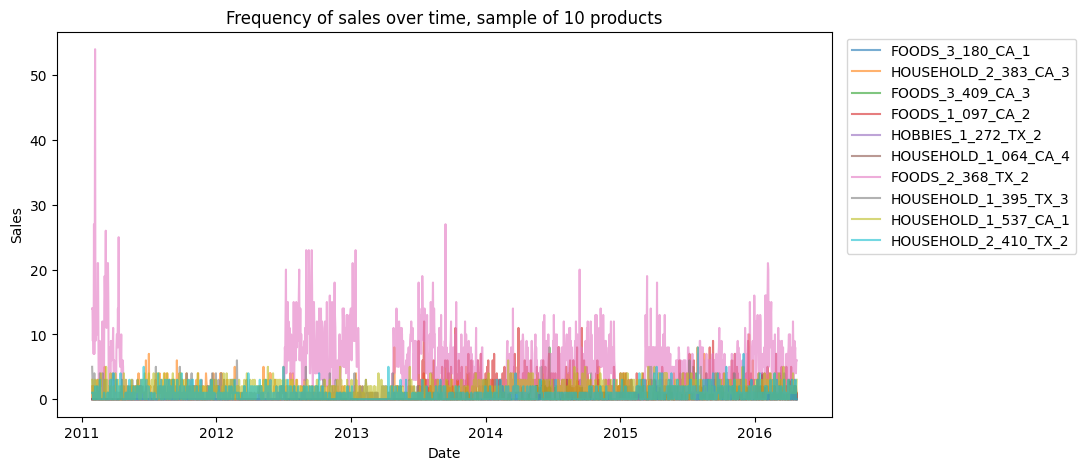

In [12]:
# Muestra del dataset
n_sample=10

sample=sales_train_validation.sample(n=n_sample, random_state=42)
sample_id=sample['id'].str.removesuffix('_validation').tolist()
sample_ts=sample.drop(['id','item_id','dept_id','cat_id','store_id','state_id'],axis=1)

# Calculo de la fecha
initial_date=date(2011,1,29)
day_list=[initial_date + timedelta(days=days_to_add) for days_to_add in range(1913)]

# Gráfico
plt.figure(figsize=(10, 5))
for i in range(n_sample):
    plt.plot(day_list, sample_ts.iloc[i].tolist(), label=sample_id[i], alpha=0.6)

plt.title('Frequency of sales over time, sample of %s products' %(n_sample))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

No se puede inferir mucho información de este gráfico. Veamos la cantidad de ventas totales por día.

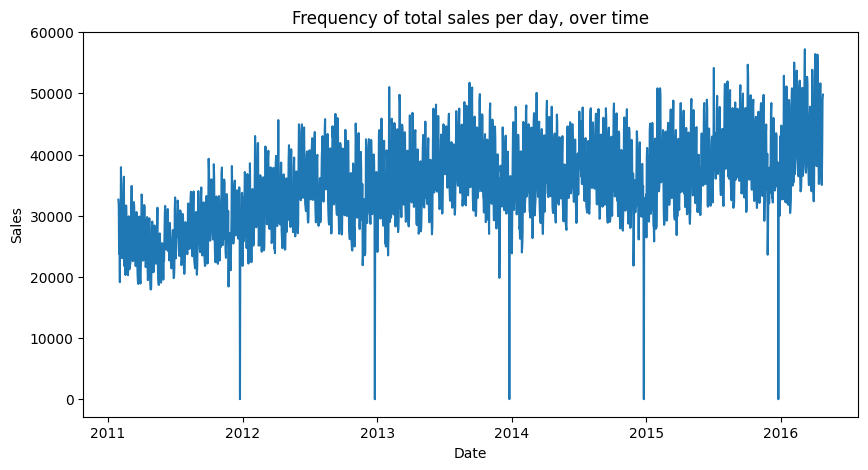

In [13]:
sales_full_ts=sales_train_validation.drop(['id','item_id','dept_id','cat_id','store_id','state_id'],axis=1)

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(day_list, sales_full_ts.sum().tolist())
plt.title('Frequency of total sales per day, over time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Podemos ver que las ventas totales andan subiendo con respecto al tiempo, y que hay un/unos día/dias a fines de cada año donde no se venden productos. Separemos estas ventas por estado para ver como aportan a este total.

In [14]:
sales_train_validation['state_id'].unique()

['CA', 'TX', 'WI']
Categories (3, object): ['CA', 'TX', 'WI']

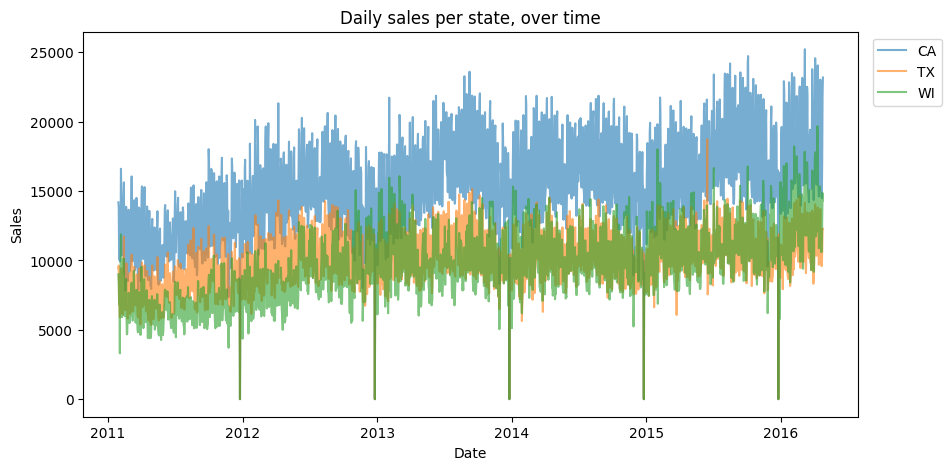

In [15]:
mask_CA=(sales_train_validation['state_id']=='CA')
mask_TX=(sales_train_validation['state_id']=='TX')
mask_WI=(sales_train_validation['state_id']=='WI')
mask_list=[mask_CA,mask_TX,mask_WI]
state_ids=['CA','TX','WI']

# Gráfico
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(day_list, sales_full_ts[mask_list[i]].sum().tolist(), label=state_ids[i], alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily sales per state, over time')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

Podemos ver que las ventas por estado son relativamente similares, y se observan patrones similares a la serie temporal agregada. California presenta mayor frecuencia de ventas por día, mientras que Texas y Wisconsin son relativamente similares. Ahora, separemos por estado cada local y veamos sus series temporales.

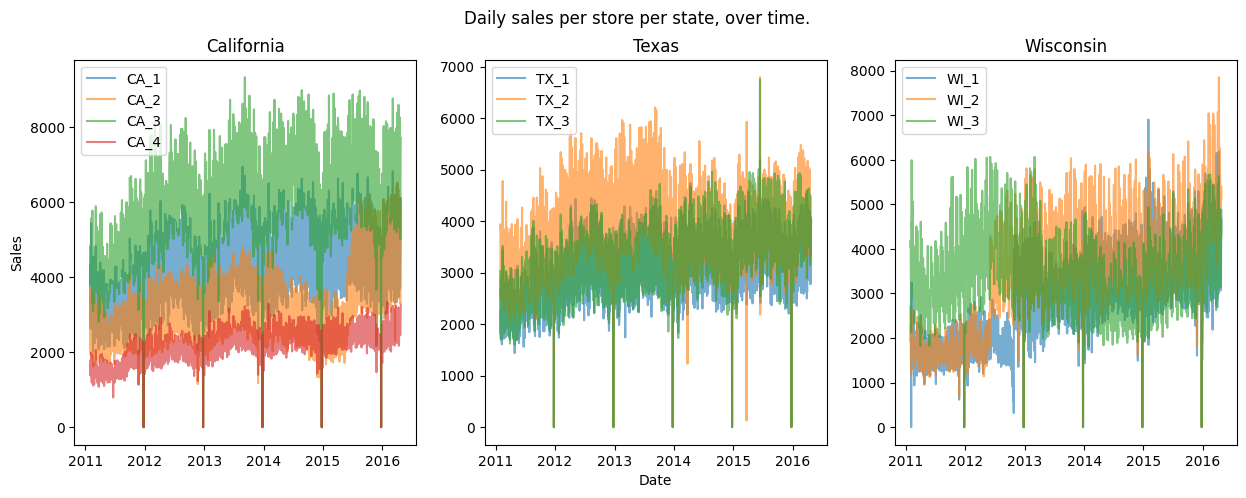

In [16]:
CA_stores=sales_train_validation[mask_CA]['store_id'].unique().tolist()
TX_stores=sales_train_validation[mask_TX]['store_id'].unique().tolist()
WI_stores=sales_train_validation[mask_WI]['store_id'].unique().tolist()
stores=[CA_stores,TX_stores,WI_stores]
state_names=['California','Texas','Wisconsin']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    for store in stores[i]:
        mask_store=(sales_train_evaluation['store_id']==store)
        store_ts=sales_full_ts[mask_store].sum().tolist()
        axes[i].plot(day_list, store_ts, label=store, alpha=0.6)
    axes[i].legend(loc='upper left')
    axes[i].set_title(state_names[i])

axes[1].set_xlabel('Date')
axes[0].set_ylabel('Sales')
plt.suptitle('Daily sales per store per state, over time.')
plt.show()

No se puede sacar información muy significativa de alguna tienda en específico. Veamos si podemos recuperar algún comportamiento si en vez de separar por tiendas separamos por departamento. Hagamos algo similar a lo anterior.

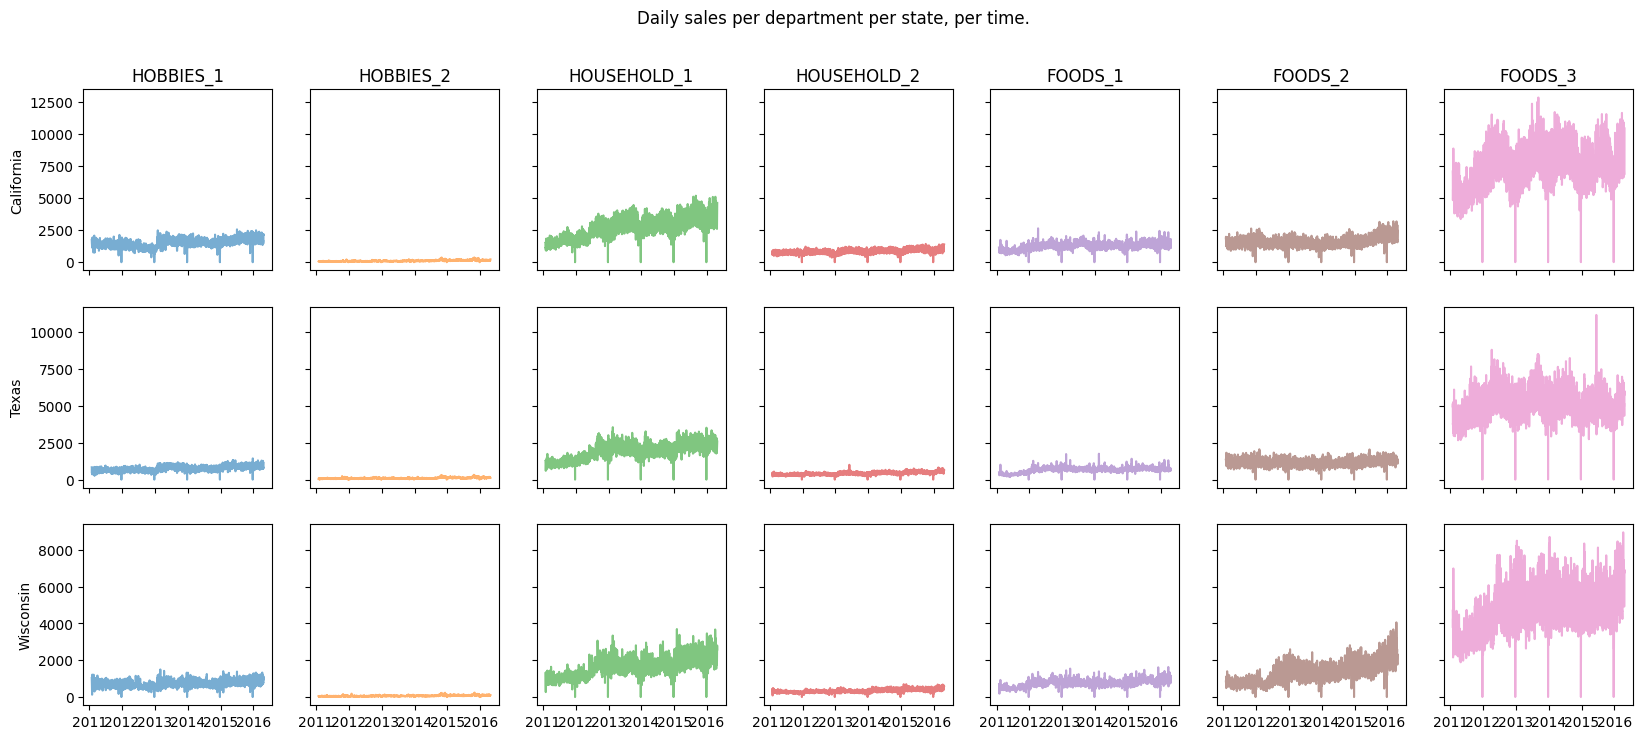

In [17]:
depts=sales_train_validation['dept_id'].unique().tolist()
num_depts=len(depts)

fig, axes = plt.subplots(3, num_depts, sharex='col', sharey='row', figsize=(20, 8))
for i in range(3):
    for j in range(num_depts):
        mask_dept=(sales_train_evaluation['dept_id']==depts[j]) & (sales_train_evaluation['state_id']==state_ids[i])
        dept_ts=sales_full_ts[mask_dept].sum().tolist()
        axes[i,j].plot(day_list, dept_ts, color=color10[j], alpha=0.6)
        axes[0,j].set_title(depts[j])
    axes[i,0].set_ylabel(state_names[i])
plt.suptitle('Daily sales per department per state, per time.')
plt.show()



Podemos ver que hay tres tipos distintos de productos, dados por Hobbies, Household y Foods. Estos productos se separan en 2, 2 y 3 departamentos respectivamente. Los departamentos donde se vende la mayor cantidad de productos parecenn ser Foods_3, Household_1 y Foods_2 en este orden, y se puede ver como la tendencia de comprar productos de cualquier tipo en cualquier estado ha subido ligeramente con respecto al tiempo.

Veamos ahora la cantidad de productos distintos vendidos por categoría. Primero veamos la suma agregada y luego la suma por departamento.

<Axes: title={'center': 'Unique products per category'}, xlabel='Category', ylabel='Amount of unique products'>

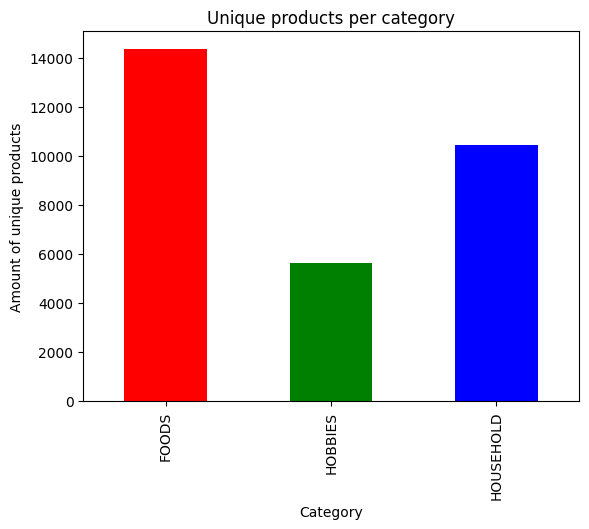

In [18]:
sales_train_validation['cat_id'].value_counts().sort_index(ascending=True).plot(kind='bar',title='Unique products per category',color=['red', 'green', 'blue'],xlabel='Category',ylabel='Amount of unique products')

<Axes: title={'center': 'Unique products per department'}, xlabel='Department', ylabel='Amount of unique products'>

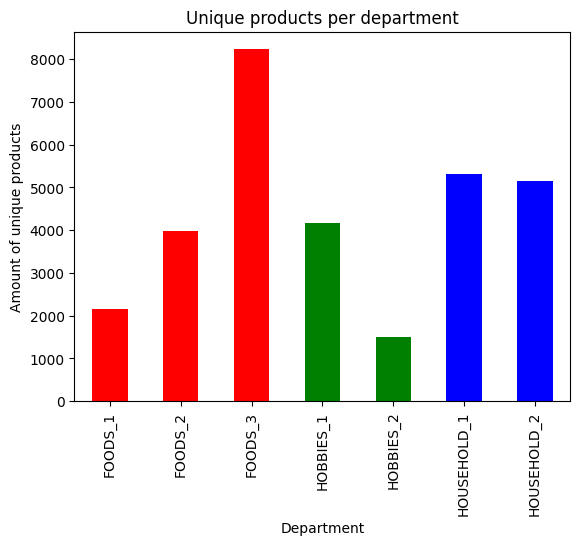

In [19]:
sales_train_validation['dept_id'].value_counts().sort_index(ascending=True).plot(kind='bar',title='Unique products per department',color=['red','red','red','green','green','blue','blue'],xlabel='Department',ylabel='Amount of unique products')

Podemos ver que los productos caen en tres categorías grandes, las cuales son Foods, Household y Hobbies. Se puede ver que el aporte por categoría de los productos en esta data siguen en el mismo orden mencionado. Además, parece que en la variedad de productos por departamento, Foods_3 tiene la mayor cantidad de productos, seguido por los productos Household.

Ahora, veamos la cantidad de ventas por día de la semana. Separemos por estado similarmente a como lo hemos hecho anteriormente.

/tmp/ipython-input-1026466070.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_days_state_list[-1]=df_days_state_list[-1].groupby(level=0, axis=1).sum()[days].sum()
/tmp/ipython-input-1026466070.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_days_state_list[-1]=df_days_state_list[-1].groupby(level=0, axis=1).sum()[days].sum()
/tmp/ipython-input-1026466070.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_days_state_list[-1]=df_days_state_list[-1].groupby(level=0, axis=1).sum()[days].sum()


<Axes: title={'center': 'Total sales every day of the week, per state'}, xlabel='Days of the week', ylabel='Amount sold'>

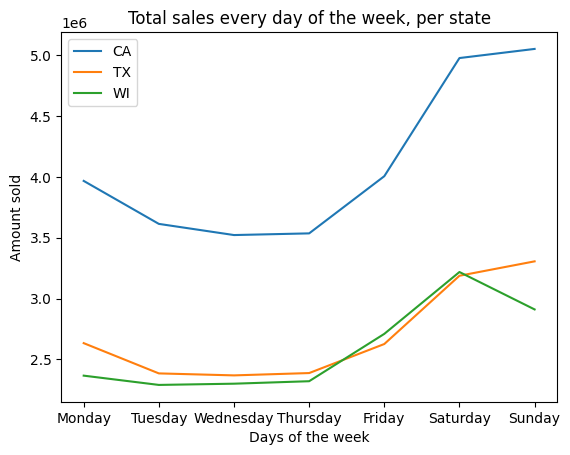

In [20]:
day_list_names=[day.strftime("%A") for day in day_list]
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

df_days_state_list=[]

for i in range(3):
    df_days_state_list.append(sales_full_ts[mask_list[i]].copy())
    df_days_state_list[-1].columns=day_list_names
    df_days_state_list[-1]=df_days_state_list[-1].groupby(level=0, axis=1).sum()[days].sum()

df_days_states=pd.concat(df_days_state_list,axis=1)
df_days_states.columns=state_ids
df_days_states.plot(kind='line',title='Total sales every day of the week, per state',xlabel='Days of the week',ylabel='Amount sold')

Podemos ver que el mayor volumen de las ventas ocurren los fines de semana, y los días con menor cantidad de ventas son durante los Martes, Miércoles y Jueves. Hagamos lo mismo ahora pero para los días de cada mes.

/tmp/ipython-input-3874049856.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_daysofmonth_state_list[-1]=df_daysofmonth_state_list[-1].groupby(level=0, axis=1).sum()[daysofmonth].sum()
/tmp/ipython-input-3874049856.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_daysofmonth_state_list[-1]=df_daysofmonth_state_list[-1].groupby(level=0, axis=1).sum()[daysofmonth].sum()
/tmp/ipython-input-3874049856.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_daysofmonth_state_list[-1]=df_daysofmonth_state_list[-1].groupby(level=0, axis=1).sum()[daysofmonth].sum()


<Axes: title={'center': 'Total sales every day of the month, per state'}, xlabel='Days of the month', ylabel='Amount sold'>

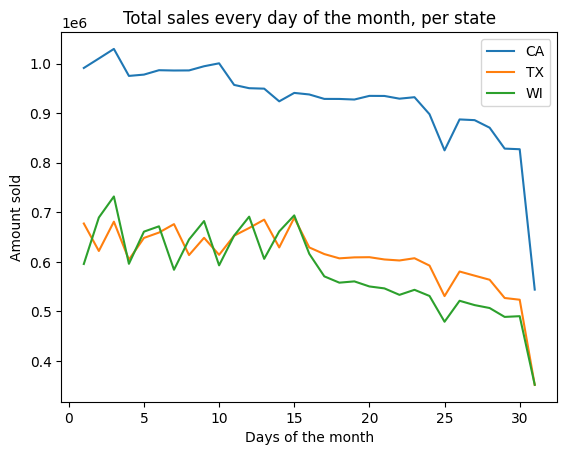

In [21]:
daysofmonth_list=[day.day for day in day_list]
daysofmonth=[i+1 for i in range(31)]

df_daysofmonth_state_list=[]

for i in range(3):
    df_daysofmonth_state_list.append(sales_full_ts[mask_list[i]].copy())
    df_daysofmonth_state_list[-1].columns=daysofmonth_list
    df_daysofmonth_state_list[-1]=df_daysofmonth_state_list[-1].groupby(level=0, axis=1).sum()[daysofmonth].sum()

df_daysofmonth_states=pd.concat(df_daysofmonth_state_list,axis=1)
df_daysofmonth_states.columns=state_ids
df_daysofmonth_states.plot(kind='line',title='Total sales every day of the month, per state',xlabel='Days of the month', ylabel='Amount sold')

Podemos ver que los primeros 15 días presentan mayor volumen de compras en cada estado, y desde el 15avo día las compras desaceleran. Los días 29, 30 y 31 claramente tiene menores compras, pues tales días no aparecen en Febrero (salvo 29 cada año bisiesto), y además vemos una baja grande en el día 31 pues solamente la mitad de los meses alcanzan a tener 31 días. Podemos ver que la proporción de ventas de estos días respecto al día 27 es bastante esperada de acuerdo a este fenómeno. Ahora, agrupemos las ventas mensuales durante el transcurso de los años, siguiendo con lo que hemos hecho con los dos gráficos anteriores.

/tmp/ipython-input-1268237358.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_months_state_list[-1]=df_months_state_list[-1].groupby(level=0, axis=1).sum()[months].sum()
/tmp/ipython-input-1268237358.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_months_state_list[-1]=df_months_state_list[-1].groupby(level=0, axis=1).sum()[months].sum()
/tmp/ipython-input-1268237358.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_months_state_list[-1]=df_months_state_list[-1].groupby(level=0, axis=1).sum()[months].sum()


<Axes: title={'center': 'Total sales every month, per state'}, xlabel='Months of the year', ylabel='Amount sold'>

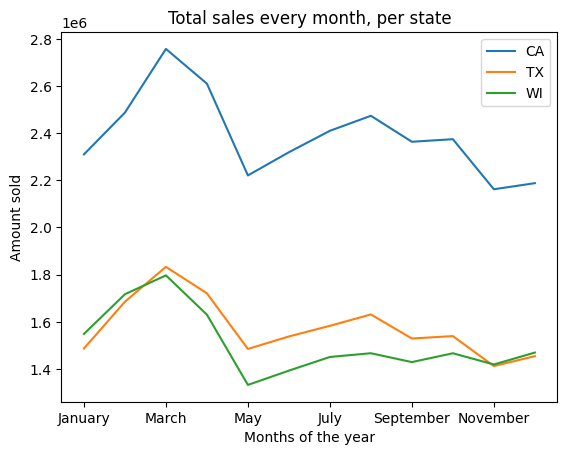

In [22]:
month_list_names=[day.strftime("%B") for day in day_list]
months=['January','February','March','April','May','June','July','August','September','October','November','December']

df_months_state_list=[]

for i in range(3):
    df_months_state_list.append(sales_full_ts[mask_list[i]].copy())
    df_months_state_list[-1].columns=month_list_names
    df_months_state_list[-1]=df_months_state_list[-1].groupby(level=0, axis=1).sum()[months].sum()

df_months_states=pd.concat(df_months_state_list,axis=1)
df_months_states.columns=state_ids
df_months_states.plot(kind='line',title='Total sales every month, per state',xlabel='Months of the year', ylabel='Amount sold')

Podemos ver que los meses de mayor demanda son los meses cercanos a Marzo, mientras que los de menor demanda son Noviembre y Diciembre, y Mayo.

Ahora, veamos detalles sobre el otro archivo del calendario. Veamos la frecuencia de eventos que hubo y de que tipo.

In [23]:
num_calendar_days=calendar['d'].nunique()

calendar_event_types_1=pd.get_dummies(calendar['event_type_1'])
calendar_event_types_2=pd.get_dummies(calendar['event_type_2'])
#No hay event_type_2 del tipo National y Sporting
calendar_event_types_2['National']=False
calendar_event_types_2['Sporting']=False

calendar_event_types=calendar_event_types_1|calendar_event_types_2
num_total_events=calendar_event_types.sum().sum()

Text(0.5, 1.0, 'Percentage of days with events taking place')

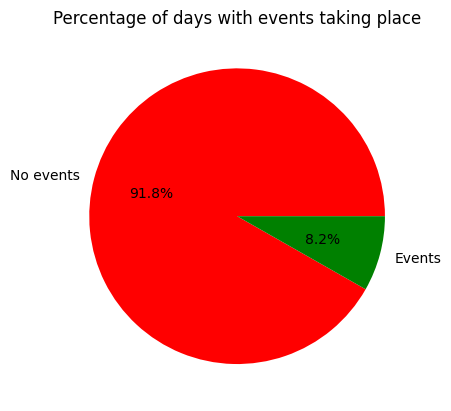

In [24]:
num_event_days=calendar_event_types[calendar_event_types.any(axis=1)].shape[0]
df_plot_event_days=pd.DataFrame({'Category': ['No events', 'Events'],'Value': [num_calendar_days-num_event_days,num_event_days]})
plt.pie(df_plot_event_days['Value'], labels=df_plot_event_days['Category'], autopct='%1.1f%%', colors=['red','green'])
plt.title('Percentage of days with events taking place')

<Axes: title={'center': 'Percentage of types of events'}>

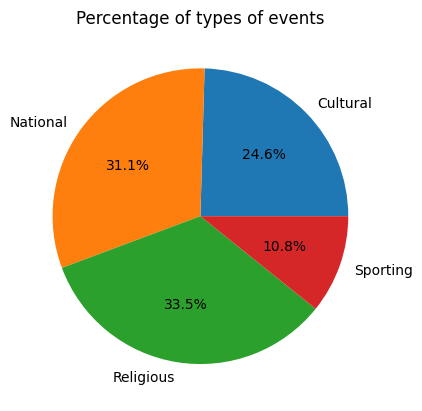

In [25]:
(calendar_event_types.sum()/num_total_events).plot(kind='pie',autopct="%1.1f%%",title='Percentage of types of events')

Podemos ver que el 10% de los días aproximadamente hubo algún evento, y la mayoría de este tipo de eventos fue de carácter religioso. Ahora veamos los días de disponibilidad de SNAP en cada estado.

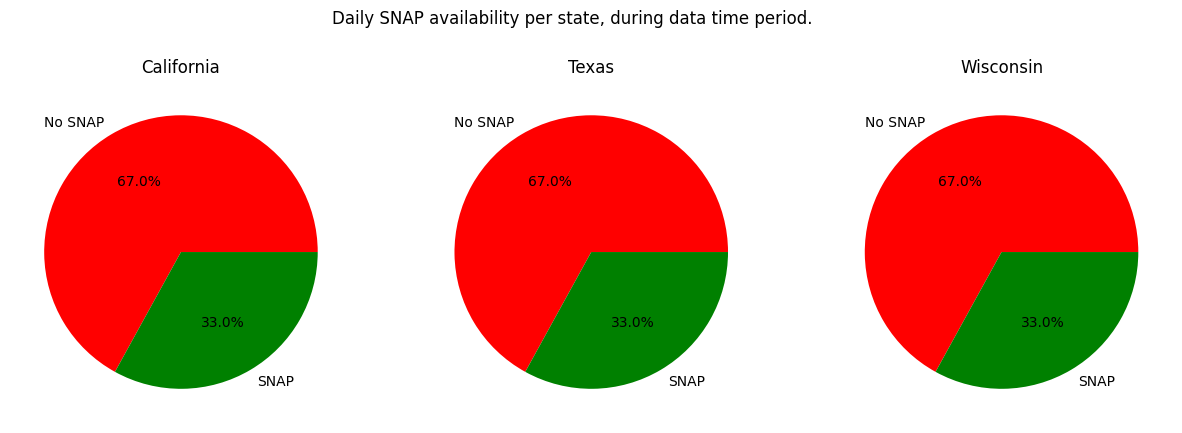

In [26]:
num_snap_CA_days=calendar[calendar['snap_CA']==1].shape[0]
num_snap_TX_days=calendar[calendar['snap_TX']==1].shape[0]
num_snap_WI_days=calendar[calendar['snap_WI']==1].shape[0]
num_snap_days=[num_snap_CA_days,num_snap_TX_days,num_snap_WI_days]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    df_plot_event_days=pd.DataFrame({'Category': ['No SNAP','SNAP'],'Value': [num_calendar_days-num_snap_days[i],num_snap_days[i]]})
    axes[i].pie(df_plot_event_days['Value'], labels=df_plot_event_days['Category'], autopct='%1.1f%%', colors=['red','green'])
    axes[i].set_title(state_names[i])

plt.suptitle('Daily SNAP availability per state, during data time period.')
plt.show()


Podemos ver que todos los estados tuvieron la misma cantidad de días con SNAP disponibles durante el periodo registrado en el dataset. Esto es pues SNAP solo está funcional por 10 días cada mes para cada estado (entre el 1 y el 15 de cada mes), y nuestro dataset parte y termina fuera de este periodo. Veamos los días que está disponible para cada estado.

In [27]:
day_list_calendar=[initial_date + timedelta(days=days_to_add) for days_to_add in range(num_calendar_days)]

snap_daysofmonth_CA=list(set([day_list_calendar[i].day for i in calendar[calendar['snap_CA']==1].index.tolist()]))
snap_daysofmonth_TX=list(set([day_list_calendar[i].day for i in calendar[calendar['snap_TX']==1].index.tolist()]))
snap_daysofmonth_WI=list(set([day_list_calendar[i].day for i in calendar[calendar['snap_WI']==1].index.tolist()]))

snap_daysofmonth=pd.DataFrame(data=np.array([snap_daysofmonth_CA,snap_daysofmonth_TX,snap_daysofmonth_WI]).T.tolist(),columns=state_ids)
snap_daysofmonth

CA  TX  WI
0   1   1   2
1   2   3   3
2   3   5   5
3   4   6   6
4   5   7   8
5   6   9   9
6   7  11  11
7   8  12  12
8   9  13  14
9  10  15  15

Podemos ver que California tiene todos los primeros 10 días del mes con SNAP, mientras que Texas y Wisconsin tienen 10 de los primeros 15 días con SNAP de forma distinta. Aprovechemos de comparar estos días donde SNAP está presente cada mes con el gráfico de ventas totales por mes que hicimos anteriormente. Separemos por estado obviamente.

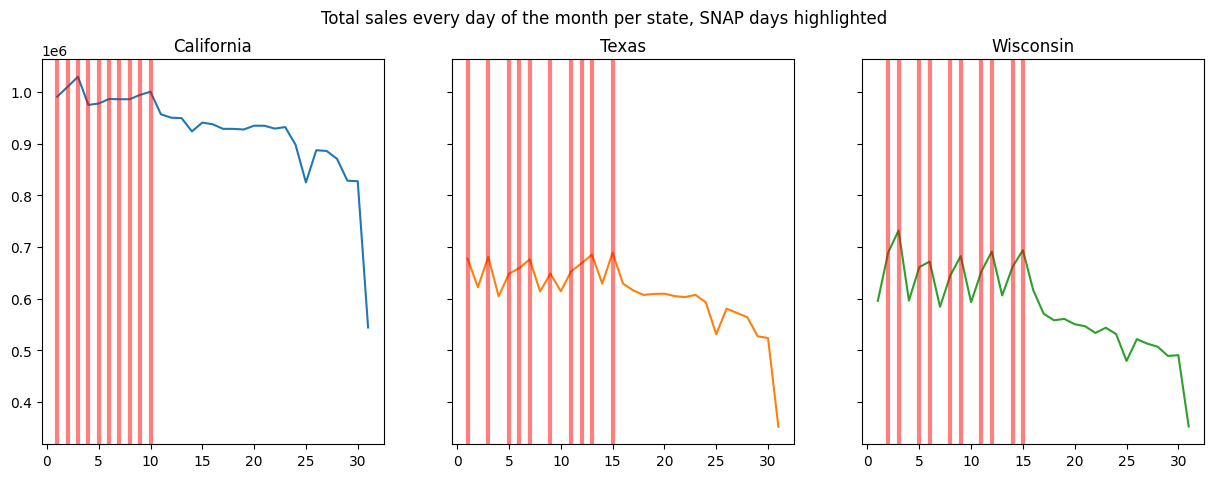

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5),sharey=True)
for i in range(3):
    axes[i].plot(df_daysofmonth_states.index,df_daysofmonth_states[state_ids[i]],color=color10[i])
    for x in snap_daysofmonth[state_ids[i]]:
        axes[i].axvline(x=x, linewidth=3, color='red', alpha=0.5)
    axes[i].set_title(state_names[i])

plt.suptitle('Total sales every day of the month per state, SNAP days highlighted')
plt.show()



Podemos ver que hay un claro patrón que en cada estado se ven la mayor cantidad de ventas cuando SNAP esta disponible. Ahora, visualicemos el último dataset de `sell_prices.csv`. Reformateemos este dataset para que sea más fácil trabajar con cada producto de cada estado, mostrando como ejemplo el dataframe correspondiente a los precios de California.

In [29]:
column_order=['item_id']+[f'd_{i+1}' for i in range(num_calendar_days)]
sell_prices_list=[sell_prices[sell_prices['store_id'].isin(state_stores)].drop(columns='store_id',axis=1) for state_stores in stores]
ts_prices=[pd.DataFrame(pd.merge(sell_prices_list[i],calendar,on='wm_yr_wk')[['item_id','d','sell_price']].pivot_table(index='item_id', columns='d', values='sell_price', aggfunc='mean').to_records())[column_order] for i in range(3)]
ts_prices[0] # Dataframe de California

/tmp/ipython-input-892851473.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ts_prices=[pd.DataFrame(pd.merge(sell_prices_list[i],calendar,on='wm_yr_wk')[['item_id','d','sell_price']].pivot_table(index='item_id', columns='d', values='sell_price', aggfunc='mean').to_records())[column_order] for i in range(3)]
/tmp/ipython-input-892851473.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ts_prices=[pd.DataFrame(pd.merge(sell_prices_list[i],calendar,on='wm_yr_wk')[['item_id','d','sell_price']].pivot_table(index='item_id', columns='d', values='sell_price', aggfunc='mean').to_records())[column_order] for i in range(3)]
/tmp/ipython-input-892851473.py:3: FutureWar

item_id        d_1        d_2        d_3        d_4        d_5  \
0         FOODS_1_001   2.000000   2.000000   2.000000   2.000000   2.000000   
1         FOODS_1_002   7.878906   7.878906   7.878906   7.878906   7.878906   
2         FOODS_1_003   2.880859   2.880859   2.880859   2.880859   2.880859   
3         FOODS_1_004        NaN        NaN        NaN        NaN        NaN   
4         FOODS_1_005   2.939453   2.939453   2.939453   2.939453   2.939453   
...               ...        ...        ...        ...        ...        ...   
3044  HOUSEHOLD_2_512   3.970703   3.970703   3.970703   3.970703   3.970703   
3045  HOUSEHOLD_2_513        NaN        NaN        NaN        NaN        NaN   
3046  HOUSEHOLD_2_514  18.968750  18.968750  18.968750  18.968750  18.968750   
3047  HOUSEHOLD_2_515        NaN        NaN        NaN        NaN        NaN   
3048  HOUSEHOLD_2_516   5.941406   5.941406   5.941406   5.941406   5.941406   

            d_6        d_7        d_8        d_9  ...     d_1960     d_1961  \
0      2.000000   2.000000   2.000000   2.000000  ...   2.240234   2.240234   
1      7.878906   7.878906   7.878906   7.878906  ...   9.476562   9.476562   
2      2.880859   2.880859   2.880859   2.880859  ...   3.230469   3.230469   
3           NaN        NaN        NaN        NaN  ...   1.959961   1.959961   
4      2.939453   2.939453   2.939453   2.939453  ...   3.539062   3.539062   
...         ...        ...        ...        ...  ...        ...        ...   
3044   3.970703   3.970703   3.970703   3.970703  ...   3.970703   3.970703   
3045        NaN        NaN        NaN        NaN  ...   2.779297   2.779297   
3046  18.968750  18.968750  18.968750  18.968750  ...  19.546875  19.546875   
3047        NaN        NaN        NaN        NaN  ...   1.969727   1.969727   
3048   5.941406   5.941406   5.941406   5.941406  ...   5.941406   5.941406   

         d_1962     d_1963     d_1964     d_1965     d_1966     d_1967  \
0      2.240234   2.240234   2.240234   2.240234   2.240234   2.240234   
1      9.476562   9.476562   9.476562   9.476562   9.476562   9.476562   
2      3.230469   3.230469   3.230469   3.230469   3.230469   3.230469   
3      1.959961   1.959961   1.959961   1.959961   1.959961   1.959961   
4      3.539062   3.539062   3.539062   3.539062   3.539062   3.539062   
...         ...        ...        ...        ...        ...        ...   
3044   3.970703   3.970703   3.970703   3.970703   3.970703   3.970703   
3045   2.779297   2.779297   2.779297   2.779297   2.779297   2.779297   
3046  19.546875  19.546875  19.546875  19.546875  19.546875  19.546875   
3047   1.969727   1.969727   1.969727   1.969727   1.969727   1.969727   
3048   5.941406   5.941406   5.941406   5.941406   5.941406   5.941406   

         d_1968     d_1969  
0      2.240234   2.240234  
1      9.476562   9.476562  
2      3.230469   3.230469  
3      1.959961   1.959961  
4      3.539062   3.539062  
...         ...        ...  
3044   3.970703   3.970703  
3045   2.779297   2.779297  
3046  19.546875  19.546875  
3047   1.969727   1.969727  
3048   5.941406   5.941406  

[3049 rows x 1970 columns]

Escojamos 10 productos aleatorios presentes en cada estado y veamos como cambian sus precios a lo largo del tiempo. Veamos gráficos de estos productos separados por estado, luego separados por producto.

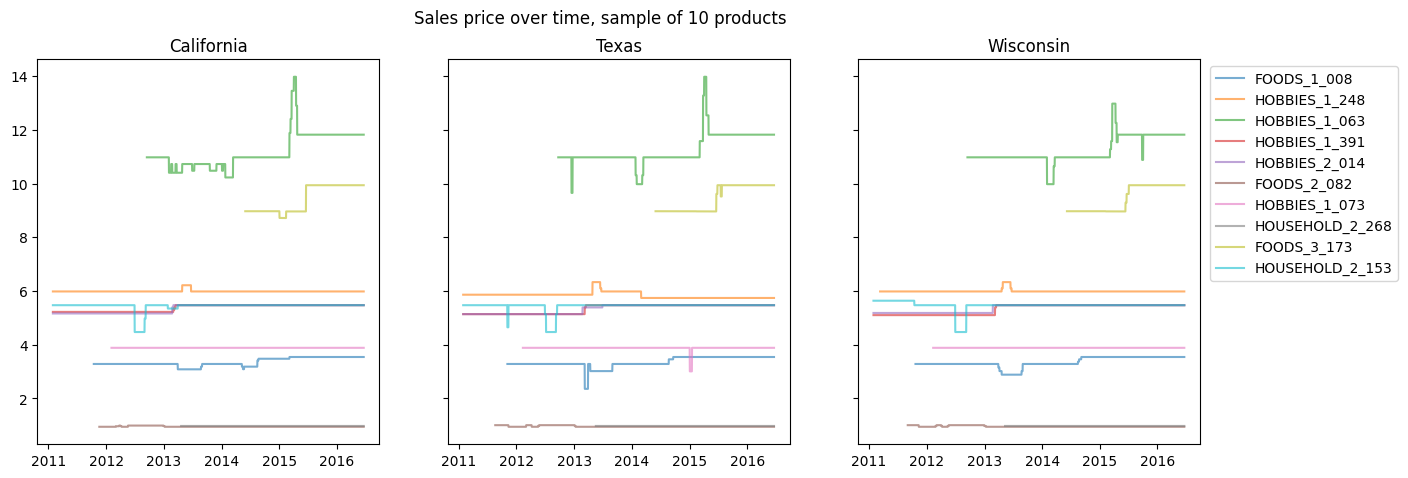

In [30]:
sample_products=ts_prices[0]['item_id'].sample(10, random_state=1).tolist()
df_product_sample=[ts_prices[i][ts_prices[i]['item_id'].isin(sample_products)] for i in range(3)]
n_sample=len(sample_products)

fig, axes = plt.subplots(1, 3, figsize=(15, 5),sharey=True,sharex=True)
for i in range(3):
    for j in range(n_sample):
        axes[i].plot(day_list_calendar, df_product_sample[i].drop(columns='item_id',axis=1).iloc[j].tolist(), label=sample_products[j], alpha=0.6)
    axes[i].set_title(state_names[i])

plt.suptitle('Sales price over time, sample of %s products' %(n_sample))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

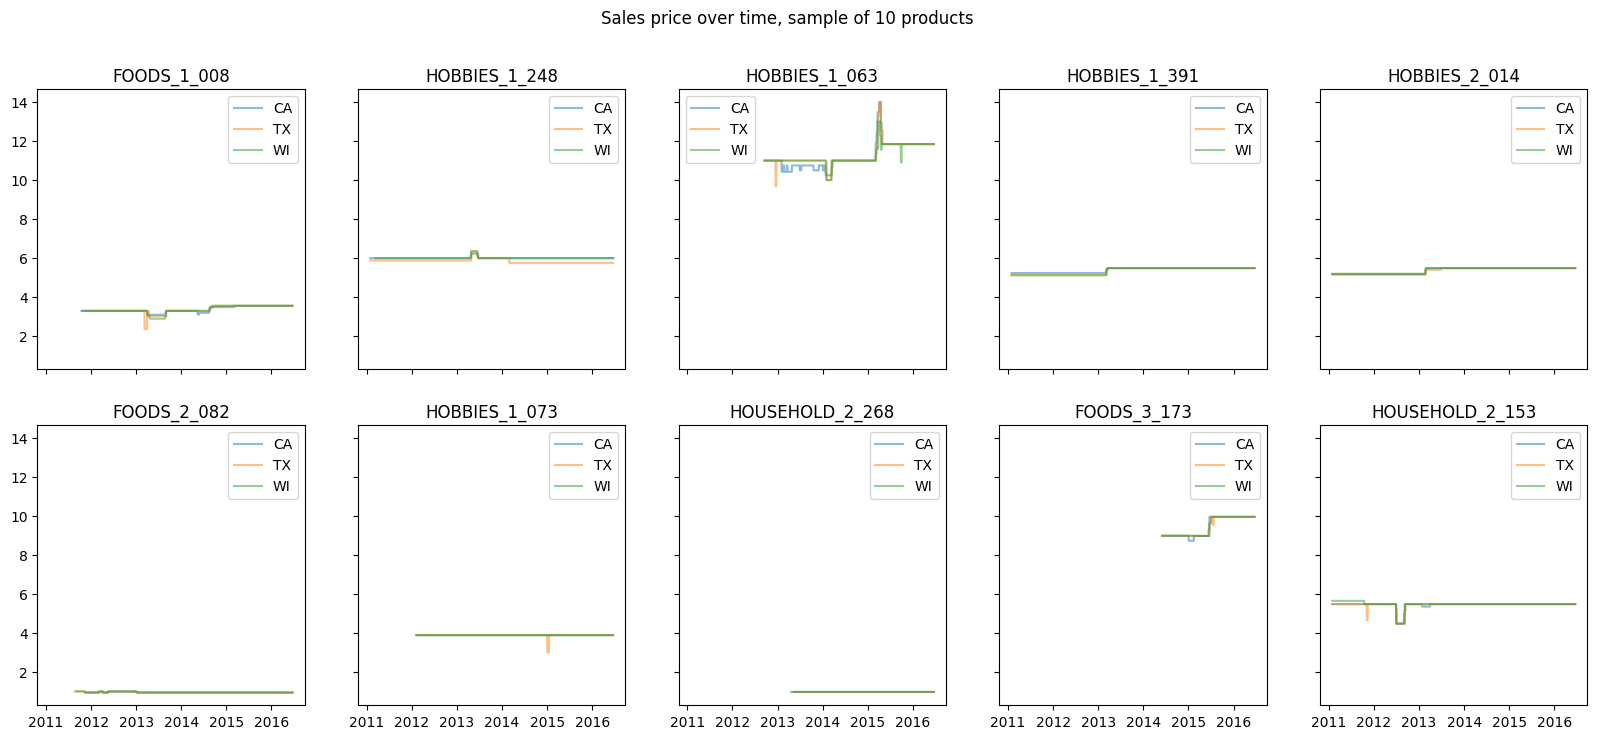

In [31]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True,sharey=True)
for i in range(2):
    for j in range(5):
        for k in range(3):
            axes[i,j].plot(day_list_calendar, df_product_sample[k].drop(columns='item_id',axis=1).iloc[5*i+j].tolist(), label=state_ids[k],alpha=0.5)
        axes[i,j].set_title(sample_products[5*i+j])
        axes[i,j].legend()

plt.suptitle('Sales price over time, sample of %s products' %(n_sample))
plt.show()

Podemos ver que la muestra de productos que sacamos presentan una variedad grande de precios a lo largo del tiempo, y con periodos de mediciones del precio durante el tiempo. Podemos ver que distintos productos son en general bien parecidos en precio a lo largo de cada estado, con algunas diferencias durante periodos de tiempo cortos. En general se puede observar que los precios andan aumentando ligeramente o estabilizandose a lo largo del tiempo.

#**4. Preprocesamiento**

* **Reformateo a largo** (melt) para *lags/rollings*.
* **Regresores exógenos**: precios (niveles/variaciones), eventos/feriados (`calendar`).
* **Feature engineering (mínimos)**:

* *Lags* (7, 28, …), *rolling means/std* (7/28/56), calendario (`dow`, `month`, fin de semana, proximidad a evento).
* Codificación categóricas (one-hot/target) evitando **leakage**.
* **Pipelines** (`sklearn`): imputación, escala, codificación y selección integradas.

Haremos el reformateo con melt para tener un formato long, de modo que el dia `d` corresponda a la columna de `d_x`y se permita hacer predicciones. Luego, se combinara con el calendario y su precio

In [32]:
### VAMOS A TRABAJAR CON LOS ULTIMOS 365 DIAS###
last_n_days = 365
last_d_columns = [f'd_{i}' for i in range(1913-last_n_days+1, 1913+1)]

sales_last_year = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] + last_d_columns].copy()

print(f"Tamaño del subset: {len(sales_last_year)}")
#### ESTO SE PUEDE SEPARAR POR EVENTOS IMPORTANTES TAMBIEN ###

Tamaño del subset: 30490


In [33]:
sales_long = pd.melt(sales_last_year,
                     id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                     var_name='d', value_name='sales')
sales_long = sales_long.merge(calendar[['d', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
                                       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
                                       'snap_CA', 'snap_TX', 'snap_WI']],
                             on='d', how='left')
sales_long = sales_long.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
display(sales_long.head())
display(sales_long.shape)

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id       d  sales       date  wm_yr_wk  ... month  year  event_name_1  \
0       CA  d_1549      0 2015-04-26     11513  ...     4  2015           NaN   
1       CA  d_1549      0 2015-04-26     11513  ...     4  2015           NaN   
2       CA  d_1549      0 2015-04-26     11513  ...     4  2015           NaN   
3       CA  d_1549      3 2015-04-26     11513  ...     4  2015           NaN   
4       CA  d_1549      0 2015-04-26     11513  ...     4  2015           NaN   

   event_type_1 event_name_2 event_type_2 snap_CA snap_TX  snap_WI  sell_price  
0           NaN          NaN          NaN       0       0        0    8.257812  
1           NaN          NaN          NaN       0       0        0    3.970703  
2           NaN          NaN          NaN       0       0        0    2.970703  
3           NaN          NaN          NaN       0       0        0    4.640625  
4           NaN          NaN          NaN       0       0        0    2.880859  

[5 rows x 22 columns]

(11128850, 22)

In [34]:
sales_long.isna().sum() / len(sales_long) * 100

id                0.000000
item_id           0.000000
dept_id           0.000000
cat_id            0.000000
store_id          0.000000
state_id          0.000000
d                 0.000000
sales             0.000000
date              0.000000
wm_yr_wk          0.000000
weekday           0.000000
wday              0.000000
month             0.000000
year              0.000000
event_name_1     92.328767
event_type_1     92.328767
event_name_2    100.000000
event_type_2    100.000000
snap_CA           0.000000
snap_TX           0.000000
snap_WI           0.000000
sell_price        0.287873
dtype: float64

De lo anterior sabemos que la mayor cantidad de columnas con NaN son las referente a las columnas que indican si tal dia hubo un evento y el tipo de esta. Como eliminarlas no es lo correcto, se imputaran con `no_event`.

In [35]:
missing_prices = sales_long[sales_long["sell_price"].isna()][["store_id", "item_id", "wm_yr_wk"]]
display(missing_prices)
display(missing_prices.shape)
test = sell_prices.merge(
    missing_prices.drop_duplicates(),
    on=["store_id", "item_id", "wm_yr_wk"],
    how="inner"
)
display(test)
display(test.shape)
missing_weeks = missing_prices['wm_yr_wk'].unique()
display(missing_weeks)

store_id          item_id  wm_yr_wk
547         CA_1    HOBBIES_2_132     11513
801         CA_1  HOUSEHOLD_1_242     11513
996         CA_1  HOUSEHOLD_1_441     11513
1067        CA_1  HOUSEHOLD_1_512     11513
1943        CA_1      FOODS_2_117     11513
...          ...              ...       ...
8910014     CA_3  HOUSEHOLD_1_278     11602
8911997     CA_3      FOODS_3_595     11602
8913182     CA_4  HOUSEHOLD_1_400     11602
8925366     WI_1  HOUSEHOLD_1_386     11602
8928056     WI_2  HOUSEHOLD_1_020     11602

[32037 rows x 3 columns]

(32037, 3)

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Empty DataFrame
Columns: [store_id, item_id, wm_yr_wk, sell_price]
Index: []

(0, 4)

array([11513, 11514, 11515, 11516, 11517, 11518, 11519, 11520, 11521,
       11522, 11523, 11524, 11525, 11526, 11527, 11528, 11529, 11530,
       11531, 11532, 11533, 11534, 11535, 11536, 11537, 11538, 11539,
       11540, 11541, 11542, 11543, 11544, 11545, 11546, 11547, 11548,
       11549, 11550, 11551, 11552, 11601, 11602], dtype=int16)

Los vacios en `sell_price` ocurre por que en el df `sells_price` no estan todas las semanas que aparecen en `missing_weeks` y esto es por que hemos escodigo un dia arbitrario para cortar el tamaño del dataset

In [36]:
valid_triples = sell_prices[["store_id", "item_id", "wm_yr_wk"]].drop_duplicates()
sales_long = sales_long.merge(
    valid_triples.assign(valid=1),
    on=["store_id", "item_id", "wm_yr_wk"],
    how="left"
)
sales_long = sales_long[sales_long["valid"] == 1].drop(columns=["valid"])
# Verificamos que la fecha tenga el formato correcto
sales_long['date'] = pd.to_datetime(sales_long['date'])
display(sales_long.isna().sum() / len(sales_long) * 100)


id                0.000000
item_id           0.000000
dept_id           0.000000
cat_id            0.000000
store_id          0.000000
state_id          0.000000
d                 0.000000
sales             0.000000
date              0.000000
wm_yr_wk          0.000000
weekday           0.000000
wday              0.000000
month             0.000000
year              0.000000
event_name_1     92.328491
event_type_1     92.328491
event_name_2    100.000000
event_type_2    100.000000
snap_CA           0.000000
snap_TX           0.000000
snap_WI           0.000000
sell_price        0.000000
dtype: float64

Construccion de funciones para el pipeline

In [37]:
class Sales_Lags(BaseEstimator, TransformerMixin):
    ## Calcula lag para ventas
    def __init__(self, lags=[7, 28]):
        self.lags = lags
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X = X.sort_values(['item_id', 'store_id', 'date'])
        for lag in self.lags:
            X[f"sales_lag_{lag}"] = X.groupby(['item_id', 'store_id'])["sales"].shift(lag)
        return X
class Sales_Rolling(BaseEstimator, TransformerMixin):
    ## Calcula window para ventas
    def __init__(self, windows=[7, 28]):
        self.windows = windows
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X = X.sort_values(['item_id', 'store_id', 'date'])
        for window in self.windows:
            shifted = X.groupby(['item_id', 'store_id'])['sales'].shift(1) ## Corremos la data hacia atras para evitar
                                                                            ## leakege
            X[f'sales_rolling_mean_{window}'] = X.groupby(['item_id', 'store_id'])['sales'].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean())
            X[f'sales_rolling_std_{window}'] = X.groupby(['item_id', 'store_id'])['sales'].transform(
                lambda x: x.rolling(window=window, min_periods=1).std())
        return X
class Price_Lags(BaseEstimator, TransformerMixin):
    ## Calcula el lag para prico
    def __init__(self, lags=[7, 28]):
        self.lags = lags
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X = X.sort_values(['item_id', 'store_id', 'date'])
        for lag in self.lags:
            X[f"price_lag_{lag}"] = X.groupby(['item_id', 'store_id'])["sell_price"].shift(lag)
        return X

class Price_Rolling(BaseEstimator, TransformerMixin):
    ## Calcula window para precio
    def __init__(self, windows=[7, 28]):
        self.windows = windows
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X = X.sort_values(['item_id', 'store_id', 'date'])
        for window in self.windows:
            shifted = X.groupby(['item_id', 'store_id'])['sell_price'].shift(1)
            X[f'price_rolling_mean_{window}'] = X.groupby(['item_id', 'store_id'])['sell_price'].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean())
            X[f'price_rolling_std_{window}'] = X.groupby(['item_id', 'store_id'])['sell_price'].transform(
                lambda x: x.rolling(window=window, min_periods=1).std())
        return X

La creación de lag o de windows temporales genera muchos datos `NaN`, pues, puede haber semanas sin que se venda un producto en particular.
(Voy a llenar con -1 por que hace sentido asignar un valor que no existe anteriormente, tambien se puede llenar con back fill que es el primer valor valido cercano en la serie)

In [38]:
class NullLags(BaseEstimator, TransformerMixin):
    ## Reemplaza con -1 a los vacios generados por lag y rolling
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X=X.copy()
        lag_cols = [col for col in X.columns if ('lag' in col) or ('rolling' in col)]
        for col in lag_cols:
            X[col] = X[col].fillna(-1)
        return X

In [39]:
class PriceFeatures(BaseEstimator, TransformerMixin):
    ## Calcula el precio absoluto dentro de un diff dias
    ## y calcula el ratio de precio en diff dias
    def __init__(self, diffs=[7, 28]):
        self.diffs = diffs
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy()
        X_ = X_.sort_values(['item_id', 'store_id'] + ['date'])
        group = X_.groupby(['item_id', 'store_id'])["sell_price"]
        for diff in self.diffs:
            # Variaciones (diferencia absoluta de precio)
            X_[f"price_diff_{diff}"] = group.diff(diff)
            # Ratios
            X_[f"price_ratio_{diff}"] = group.transform(lambda x: x / x.shift(diff))
            X_[f"price_diff_{diff}"]=X_[f"price_diff_{diff}"].fillna(-1)
            X_[f"price_ratio_{diff}"]=X_[f"price_ratio_{diff}"].fillna(-1)
        return X_

In [40]:
class EventFeatureEngineer(BaseEstimator, TransformerMixin):
    ## Maneja null de eventos y agrega una variable indicadora si hay evento o no
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
        for col in event_cols:
            X[col]=X[col].fillna('no_event')
        X['has_event'] = ((X['event_name_1'] != 'no_event') |
                         (X['event_name_2'] != 'no_event')).astype(int)
        return X

In [41]:
class EventProximity(BaseEstimator, TransformerMixin):
    ## Calcula la proximidad de una lista de eventos dados respecto a
    ## una lista de dias proximo
    def __init__(self, target_events=None, proximity_bands=[3, 7, 14, 30]):
        self.target_events = target_events if target_events is not None else []
        self.proximity_bands = proximity_bands
        self.event_dates_cache = {}

    def fit(self, X, y=None):
        if 'date' in X.columns:
            X_temp = X.copy()
            if not pd.api.types.is_datetime64_any_dtype(X_temp['date']):
                X_temp['date'] = pd.to_datetime(X_temp['date'])

            self._cache_event_dates(X_temp)
        return self

    def _cache_event_dates(self, df):
        event_cols = [col for col in df.columns if 'event_name' in col]

        for event in self.target_events:
            event_dates = set()
            for col in event_cols:
                mask = df[col].astype(str).str.contains(event, case=False, na=False)
                event_dates.update(df[mask]['date'].unique())
            self.event_dates_cache[event] = sorted(list(event_dates))

    def transform(self, X, y=None):
        X_ = X.copy()
        if not pd.api.types.is_datetime64_any_dtype(X_['date']):
            X_['date'] = pd.to_datetime(X_['date'])

        for event in self.target_events:
            X_ = self._calculate_single_event_proximity(X_, event)
        return X_

    def _calculate_single_event_proximity(self, df, event):

        event_lower = event.lower()
        event_dates = self.event_dates_cache.get(event, [])
        if not event_dates:
            df[f'days_until_{event_lower}'] = 999
            df[f'days_since_{event_lower}'] = 999
            for band in self.proximity_bands:
                df[f'within_{band}d_before_{event_lower}'] = 0
                df[f'within_{band}d_after_{event_lower}'] = 0
            return df

        date_index = pd.Series(df['date'].unique()).sort_values()
        is_event = date_index.isin(event_dates)
        event_series = pd.Series(is_event.values, index=date_index)

        last_event_date = event_series[event_series].index.to_series()
        last_event_map = last_event_date.reindex(date_index, method='ffill')

        days_since_last = (date_index - last_event_map).dt.days.fillna(999)
        df[f'days_since_{event_lower}'] = df['date'].map(days_since_last).fillna(999).astype(int)

        next_event_date = event_series[event_series].index.to_series()
        next_event_map = next_event_date.reindex(date_index, method='bfill')

        days_until_next = (next_event_map - date_index).dt.days.fillna(999)
        df[f'days_until_{event_lower}'] = df['date'].map(days_until_next).fillna(999).astype(int)


        for band in self.proximity_bands:

            df[f'within_{band}d_before_{event_lower}'] = (
                (df[f'days_until_{event_lower}'] <= band) &
                (df[f'days_until_{event_lower}'] > 0)
            ).astype(int)

            df[f'within_{band}d_after_{event_lower}'] = (
                (df[f'days_since_{event_lower}'] <= band) &
                (df[f'days_since_{event_lower}'] > 0)
            ).astype(int)
        return df

In [42]:
feature_engineering_pipeline = Pipeline([
    ('sales_lags', Sales_Lags(lags=[7])),
    ('sales_rolling', Sales_Rolling(windows=[7])),
    ('price_lags', Price_Lags(lags=[1])),
    ('price_rolling', Price_Rolling(windows=[7])),
    ('price_ratio', PriceFeatures(diffs=[1])),
    ('null_handler', NullLags())
])
df_transformado = feature_engineering_pipeline.fit_transform(sales_long)
display(df_transformado.head())
display(df_transformado.tail())
display(df_transformado.shape)


/tmp/ipython-input-647132369.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X[f"sales_lag_{lag}"] = X.groupby(['item_id', 'store_id'])["sales"].shift(lag)
/tmp/ipython-input-647132369.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shifted = X.groupby(['item_id', 'store_id'])['sales'].shift(1) ## Corremos la data hacia atras para evitar
/tmp/ipython-input-647132369.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this war

id      item_id  dept_id cat_id store_id  \
1612    FOODS_1_001_CA_1_validation  FOODS_1_001  FOODS_1  FOODS     CA_1   
32102   FOODS_1_001_CA_1_validation  FOODS_1_001  FOODS_1  FOODS     CA_1   
62592   FOODS_1_001_CA_1_validation  FOODS_1_001  FOODS_1  FOODS     CA_1   
93082   FOODS_1_001_CA_1_validation  FOODS_1_001  FOODS_1  FOODS     CA_1   
123572  FOODS_1_001_CA_1_validation  FOODS_1_001  FOODS_1  FOODS     CA_1   

       state_id       d  sales       date  wm_yr_wk  ... snap_WI  sell_price  \
1612         CA  d_1549      0 2015-04-26     11513  ...       0    2.240234   
32102        CA  d_1550      1 2015-04-27     11513  ...       0    2.240234   
62592        CA  d_1551      0 2015-04-28     11513  ...       0    2.240234   
93082        CA  d_1552      0 2015-04-29     11513  ...       0    2.240234   
123572       CA  d_1553      0 2015-04-30     11513  ...       0    2.240234   

        sales_lag_7  sales_rolling_mean_7 sales_rolling_std_7 price_lag_1  \
1612           -1.0              0.000000           -1.000000   -1.000000   
32102          -1.0              0.500000            0.707107    2.240234   
62592          -1.0              0.333333            0.577350    2.240234   
93082          -1.0              0.250000            0.500000    2.240234   
123572         -1.0              0.200000            0.447214    2.240234   

       price_rolling_mean_7 price_rolling_std_7  price_diff_1  price_ratio_1  
1612               2.240234                -1.0          -1.0           -1.0  
32102              2.240234                 0.0           0.0            1.0  
62592              2.240234                 0.0           0.0            1.0  
93082              2.240234                 0.0           0.0            1.0  
123572             2.240234                 0.0           0.0            1.0  

[5 rows x 30 columns]

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


id          item_id      dept_id  \
11005452  HOUSEHOLD_2_516_WI_3_validation  HOUSEHOLD_2_516  HOUSEHOLD_2   
11035942  HOUSEHOLD_2_516_WI_3_validation  HOUSEHOLD_2_516  HOUSEHOLD_2   
11066432  HOUSEHOLD_2_516_WI_3_validation  HOUSEHOLD_2_516  HOUSEHOLD_2   
11096922  HOUSEHOLD_2_516_WI_3_validation  HOUSEHOLD_2_516  HOUSEHOLD_2   
11127412  HOUSEHOLD_2_516_WI_3_validation  HOUSEHOLD_2_516  HOUSEHOLD_2   

             cat_id store_id state_id       d  sales       date  wm_yr_wk  \
11005452  HOUSEHOLD     WI_3       WI  d_1909      0 2016-04-20     11612   
11035942  HOUSEHOLD     WI_3       WI  d_1910      0 2016-04-21     11612   
11066432  HOUSEHOLD     WI_3       WI  d_1911      0 2016-04-22     11612   
11096922  HOUSEHOLD     WI_3       WI  d_1912      0 2016-04-23     11613   
11127412  HOUSEHOLD     WI_3       WI  d_1913      0 2016-04-24     11613   

          ... snap_WI  sell_price  sales_lag_7  sales_rolling_mean_7  \
11005452  ...       0    5.941406          0.0                   0.0   
11035942  ...       0    5.941406          0.0                   0.0   
11066432  ...       0    5.941406          0.0                   0.0   
11096922  ...       0    5.941406          0.0                   0.0   
11127412  ...       0    5.941406          0.0                   0.0   

         sales_rolling_std_7 price_lag_1 price_rolling_mean_7  \
11005452                 0.0    5.941406             5.941406   
11035942                 0.0    5.941406             5.941406   
11066432                 0.0    5.941406             5.941406   
11096922                 0.0    5.941406             5.941406   
11127412                 0.0    5.941406             5.941406   

         price_rolling_std_7  price_diff_1  price_ratio_1  
11005452                 0.0           0.0            1.0  
11035942                 0.0           0.0            1.0  
11066432                 0.0           0.0            1.0  
11096922                 0.0           0.0            1.0  
11127412                 0.0           0.0            1.0  

[5 rows x 30 columns]

(11096813, 30)

Ahora vamos con el pipeline de escalado y codificación.

In [43]:
numerical_features = df_transformado.select_dtypes(include=['number']).columns
categorical_features = df_transformado.select_dtypes(include=['object', 'category']).columns

display(numerical_features)
display(categorical_features)

Index(['sales', 'wm_yr_wk', 'wday', 'month', 'year', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'sales_lag_7', 'sales_rolling_mean_7',
       'sales_rolling_std_7', 'price_lag_1', 'price_rolling_mean_7',
       'price_rolling_std_7', 'price_diff_1', 'price_ratio_1'],
      dtype='object')

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'weekday', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2'],
      dtype='object')

Pipeline para modelos basados en arboles de decision o de clasificación

In [44]:
preprocessor_lgbm = ColumnTransformer(
    transformers=[
        ('cat_pipeline', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_features),
        ('num_pipeline', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
            ('scaler', 'passthrough')
        ]), numerical_features)
    ],
    remainder='drop'
)
"""
#Pipeline de ejemplo
pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor_lgbm),
    ('model', LGBMRegressor(random_state=42, n_jobs=-1)) # El modelo final
])
"""

"\n#Pipeline de ejemplo\npipeline_lgbm = Pipeline([\n    ('preprocessor', preprocessor_lgbm),\n    ('model', LGBMRegressor(random_state=42, n_jobs=-1)) # El modelo final\n])\n"

Pipeline para modelos de regresión o NN.

Solo aplicamos OHE a categorías con BAJA cardinalidad (< 50) para evitar explosión

In [45]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('cat_ohe_pipeline', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), [col for col in categorical_features if col not in ['item_id', 'store_id']]),

        ('num_scale_pipeline', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
            ('scaler', StandardScaler())
        ]), numerical_features)
    ],
    remainder='drop'
)

"""
## Ejemplo pipelne
pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('model', Ridge(alpha=1.0))
])
"""

"\n## Ejemplo pipelne\npipeline_ridge = Pipeline([\n    ('preprocessor', preprocessor_linear),\n    ('model', Ridge(alpha=1.0))\n])\n"

# **5. Modelamiento (comparativa ≥ 4)**

* **Baselines**: Naive / SNaive (estacional) o media móvil.
* **Clásicos**: ARIMA/SARIMA/ETS (por unidad o segmentos).
* **Regresión con lags**: Linear/Elastic Net y **Gradient Boosting** (XGBoost/LightGBM/CatBoost).
* **Multivariados**: Prophet (con regresores) o VAR (si agrupas pocas series correlrelacionadas).
* **Opcional**: LSTM/RNN/DeepAR/Temporal Fusion (si justificas costo y comparas).

## 5.1 Modelo Snaive con estacionalidad semanal


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [207]:
s = 7
f = 28

df_snaive = sales_long.copy()
df_snaive = df_snaive.sort_values(['id', 'date'])

df_snaive['snaive_7'] = (
    df_snaive
    .groupby('id')['sales']
    .shift(s)
)

/tmp/ipython-input-3819622343.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('id')['sales']


In [208]:
last_date = df_snaive['date'].max()
val_start = last_date - pd.Timedelta(days=f-1)

mask_val = df_snaive['date'].between(val_start, last_date)
eval_df = df_snaive[mask_val & df_snaive['snaive_7'].notna()]

y_true = eval_df['sales'].values
y_pred = eval_df['snaive_7'].values


In [209]:
#Sumamos ventas a nivel de tienda, tanto para los datos reales como para los datos de Snaive
store_daily = (
    df_snaive
    .groupby(['store_id', 'date'])[['sales', 'snaive_7']]
    .sum()
    .reset_index()
)

#Suma a nivel de estados
state_daily = (
    df_snaive
    .groupby(['state_id', 'date'])[['sales', 'snaive_7']]
    .sum()
    .reset_index()
)

#suma total
total_daily = (
    df_snaive
    .groupby('date')[['sales', 'snaive_7']]
    .sum()
    .reset_index()
)


/tmp/ipython-input-4288144145.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['store_id', 'date'])[['sales', 'snaive_7']]
/tmp/ipython-input-4288144145.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['state_id', 'date'])[['sales', 'snaive_7']]


In [210]:
state_daily

state_id       date  sales  snaive_7
0          CA 2015-04-26  19426       0.0
1          CA 2015-04-27  14773       0.0
2          CA 2015-04-28  13044       0.0
3          CA 2015-04-29  12509       0.0
4          CA 2015-04-30  12985       0.0
...       ...        ...    ...       ...
1090       WI 2016-04-20  10595   10885.0
1091       WI 2016-04-21  10943   12168.0
1092       WI 2016-04-22  12807   14734.0
1093       WI 2016-04-23  14862   15338.0
1094       WI 2016-04-24  14326   14899.0

[1095 rows x 4 columns]

In [211]:
days_plot = 90
plot_start = last_date - pd.Timedelta(days=days_plot-1)

store_daily_plot = store_daily[store_daily['date'].between(plot_start, last_date)]
state_daily_plot = state_daily[state_daily['date'].between(plot_start, last_date)]
total_daily_plot = total_daily[total_daily['date'].between(plot_start, last_date)]


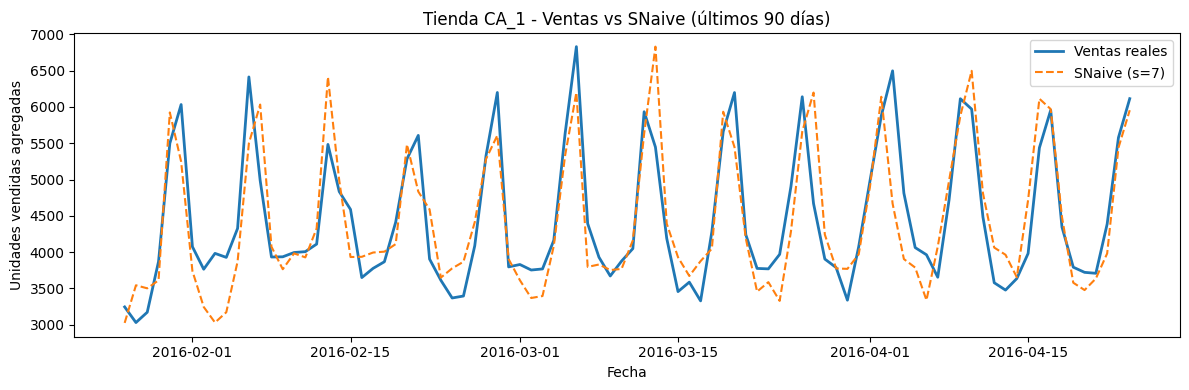

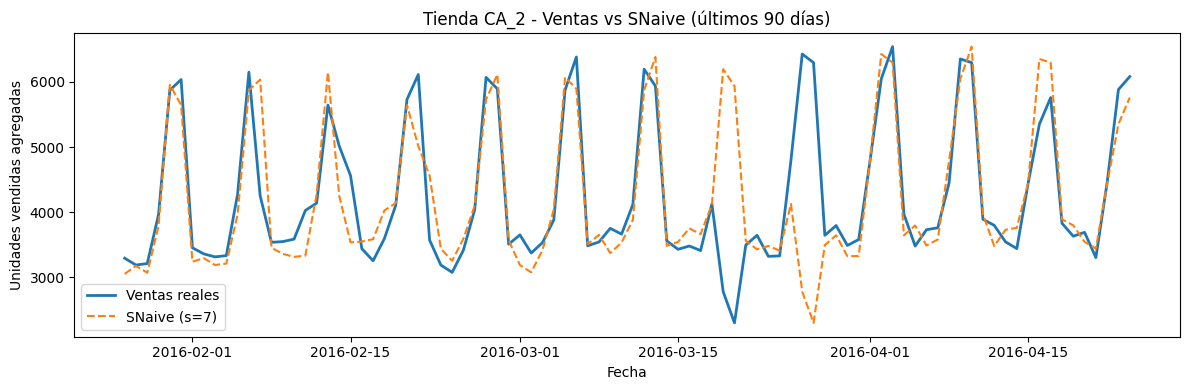

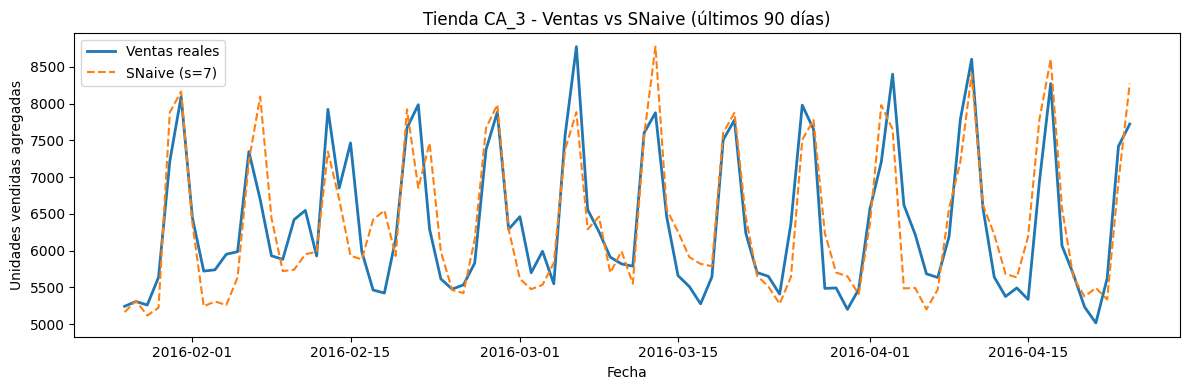

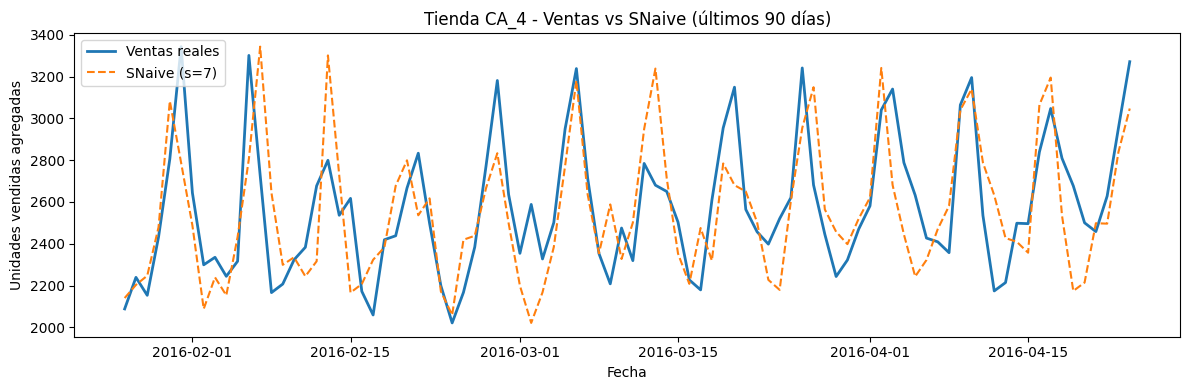

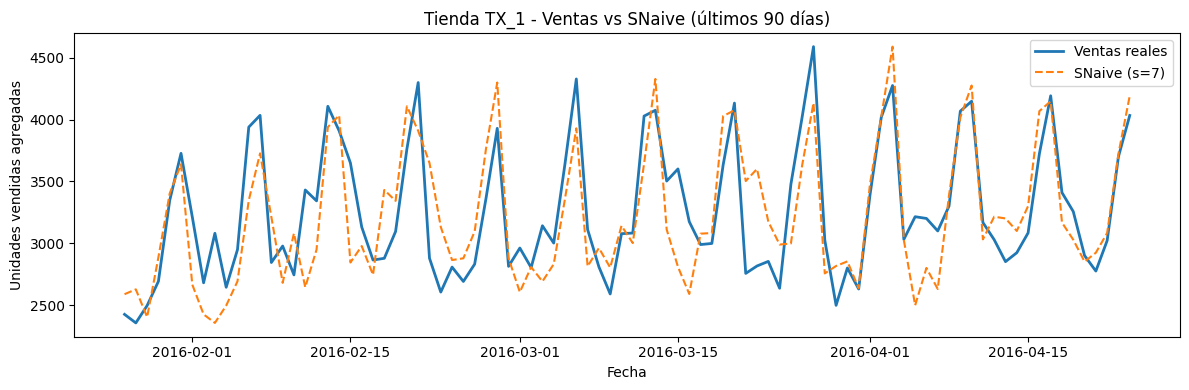

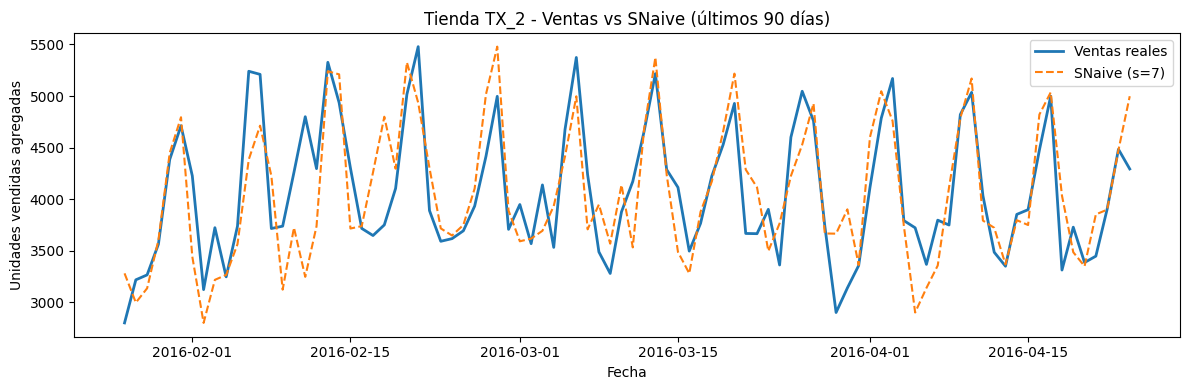

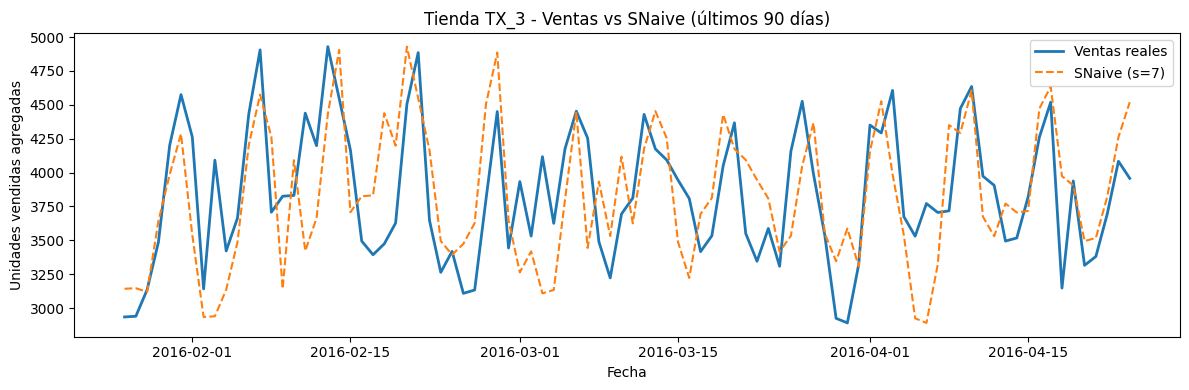

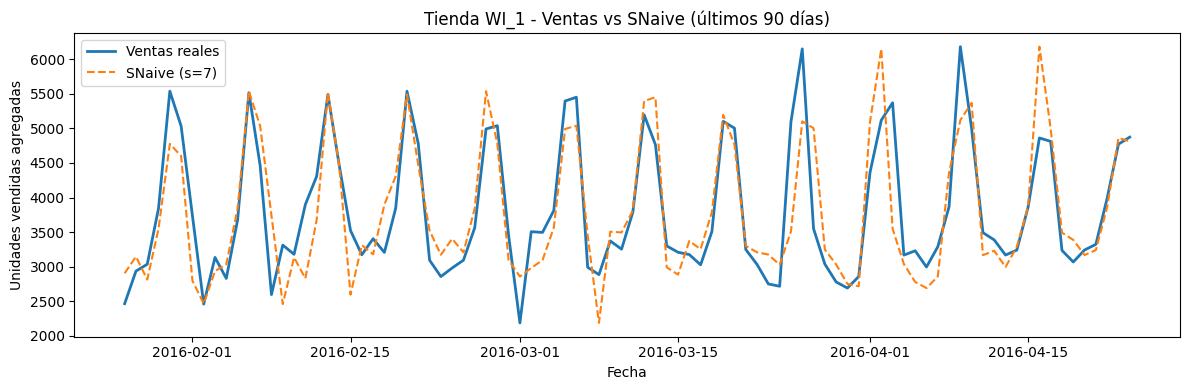

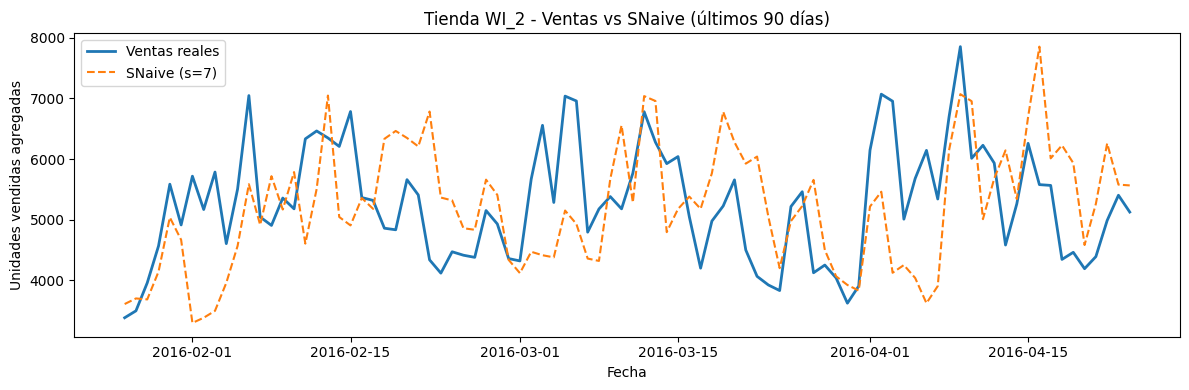

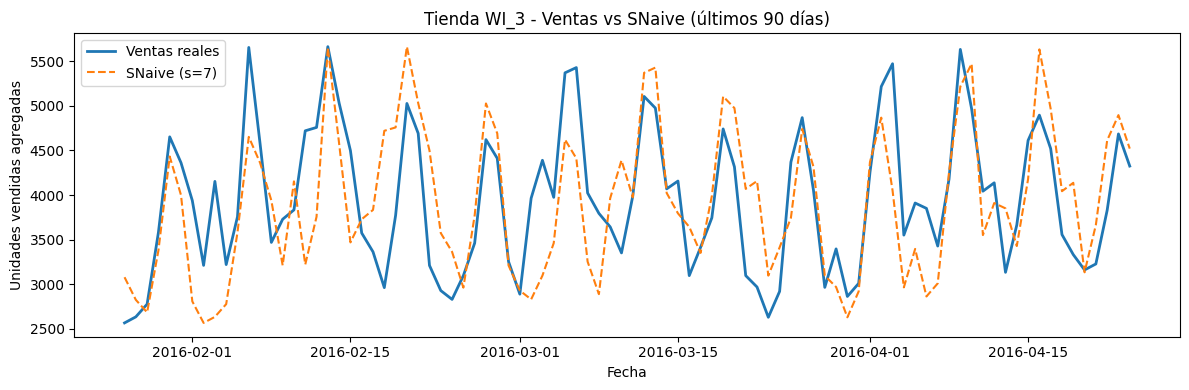

In [212]:
# Graficamos una serie por tienda
store_ids = store_daily_plot['store_id'].unique()

for store in store_ids:
    data_store = store_daily_plot[store_daily_plot['store_id'] == store]

    plt.figure(figsize=(12, 4))
    plt.plot(data_store['date'], data_store['sales'],
             label='Ventas reales', linewidth=2)
    plt.plot(data_store['date'], data_store['snaive_7'],
             label='SNaive (s=7)', linestyle='--')
    plt.title(f'Tienda {store} - Ventas vs SNaive (últimos {days_plot} días)')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades vendidas agregadas')
    plt.legend()
    plt.tight_layout()
    plt.show()

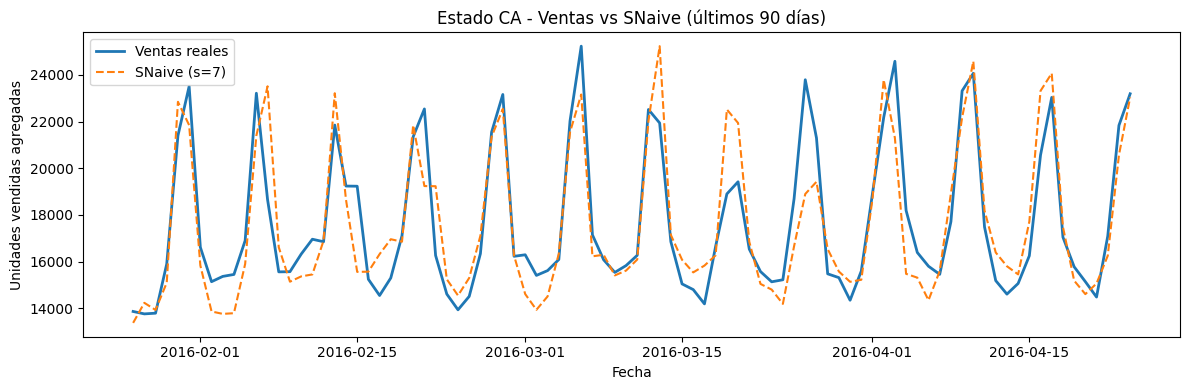

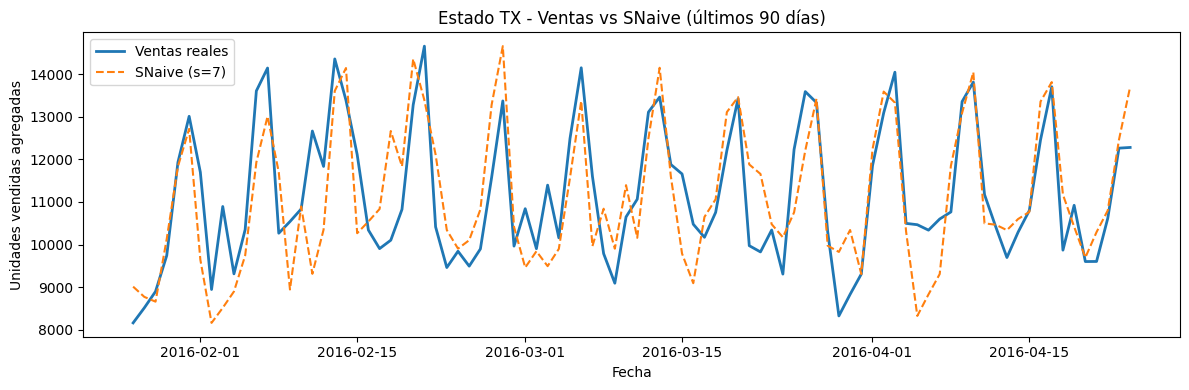

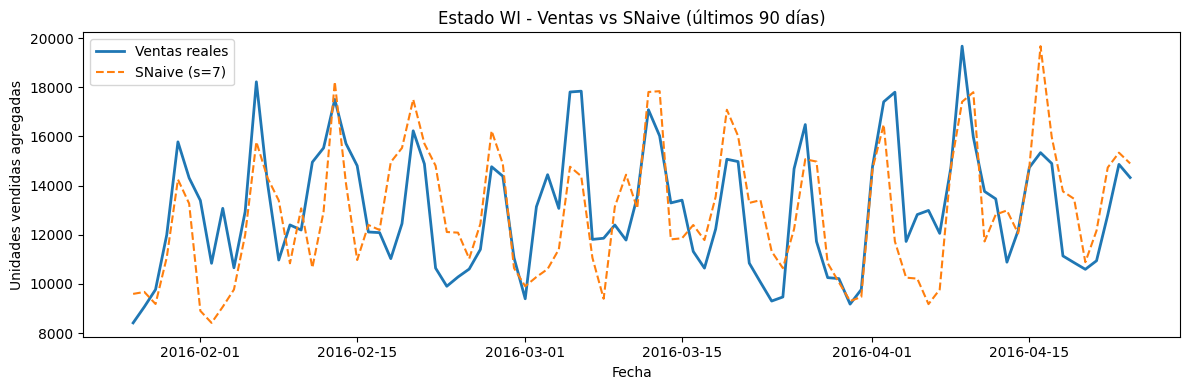

In [213]:
#Grafico por estado
for state in state_ids:
    data_state = state_daily_plot[state_daily_plot['state_id'] == state]

    plt.figure(figsize=(12, 4))
    plt.plot(data_state['date'], data_state['sales'],
             label='Ventas reales', linewidth=2)
    plt.plot(data_state['date'], data_state['snaive_7'],
             label='SNaive (s=7)', linestyle='--')
    plt.title(f'Estado {state} - Ventas vs SNaive (últimos {days_plot} días)')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades vendidas agregadas')
    plt.legend()
    plt.tight_layout()
    plt.show()

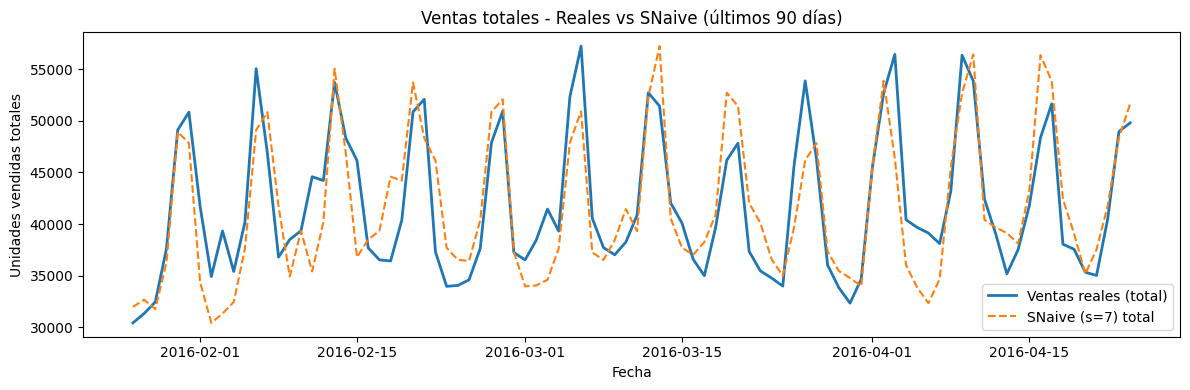

In [214]:
#Grafico Ventas Totales
plt.figure(figsize=(12, 4))
plt.plot(total_daily_plot['date'], total_daily_plot['sales'],
         label='Ventas reales (total)', linewidth=2)
plt.plot(total_daily_plot['date'], total_daily_plot['snaive_7'],
         label='SNaive (s=7) total', linestyle='--')
plt.title(f'Ventas totales - Reales vs SNaive (últimos {days_plot} días)')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas totales')
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
def rmse_mae_group(g):
    err = g['sales'] - g['snaive_7']
    mse = (err ** 2).mean()
    rmse = np.sqrt(mse)
    mae = err.abs().mean()
    return pd.Series({'RMSE': rmse, 'MAE': mae})

rmse_mae_store = (
    eval_df
    .groupby('store_id')
    .apply(rmse_mae_group)
    .reset_index()
)

rmse_mae_state = (
    eval_df
    .groupby('state_id')
    .apply(rmse_mae_group)
    .reset_index()
)

/tmp/ipython-input-68068666.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('store_id')
/tmp/ipython-input-68068666.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(rmse_mae_group)
/tmp/ipython-input-68068666.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('state_id')
/tmp/ipython-

In [56]:

# RMSSE por serie y agregación a tienda / estado

# a) tramo de entrenamiento (para calcular escala)
train_df = df_snaive[df_snaive['date'] < val_start].copy()
train_df = train_df.sort_values(['id', 'date'])

diff = train_df.groupby('id')['sales'].diff()
scale = diff.pow(2).groupby(train_df['id']).mean()
scale = scale.replace(0, np.nan)

# b) MSE de errores en validación por serie
eval_df = eval_df.sort_values(['id', 'date'])
err2 = (eval_df['sales'] - eval_df['snaive_7'])**2
mse_id = err2.groupby(eval_df['id']).mean()

# c) RMSSE por id
common_ids = mse_id.index.intersection(scale.index)
rmsse_id = np.sqrt(mse_id[common_ids] / scale[common_ids])
rmsse_id = rmsse_id.dropna().rename('RMSSE')

# d) metadatos de cada id
meta = (
    df_snaive[['id', 'store_id', 'state_id']]
    .drop_duplicates('id')
    .set_index('id')
)
rmsse_meta = meta.join(rmsse_id, how='inner')

# e) RMSSE promedio por tienda / estado
rmsse_store = (
    rmsse_meta
    .groupby('store_id')['RMSSE']
    .mean()
    .reset_index()
)

rmsse_state = (
    rmsse_meta
    .groupby('state_id')['RMSSE']
    .mean()
    .reset_index()
)

# 4. Combinar tablas: RMSSE + RMSE + MAE

store_metrics = (
    rmse_mae_store
    .merge(rmsse_store, on='store_id', how='left')
    [['store_id', 'RMSSE', 'RMSE', 'MAE']]
    .sort_values('RMSSE')
)

state_metrics = (
    rmse_mae_state
    .merge(rmsse_state, on='state_id', how='left')
    [['state_id', 'RMSSE', 'RMSE', 'MAE']]
    .sort_values('RMSSE')
)

print("\nMétricas por tienda (SNaive s=7):")
display(store_metrics)

print("\nMétricas por estado (SNaive s=7):")
display(state_metrics)


# 5. Métricas para ventas totales (agregado global)

# Serie total en entrenamiento (para RMSSE)
train_total = (
    df_snaive[df_snaive['date'] < val_start]
    .groupby('date')['sales']
    .sum()
    .sort_index()
)
diff_total = train_total.diff()
scale_total = diff_total.pow(2).mean()

# Serie total en validación
eval_total = (
    eval_df
    .groupby('date')[['sales', 'snaive_7']]
    .sum()
    .sort_index()
)

err_total = eval_total['sales'] - eval_total['snaive_7']
mse_total = (err_total**2).mean()
rmse_total = np.sqrt(mse_total)
mae_total = err_total.abs().mean()
rmsse_total = np.sqrt(mse_total / scale_total)

total_metrics = pd.DataFrame({
    'nivel' : ['TOTAL'],
    'RMSSE' : [rmsse_total],
    'RMSE'  : [rmse_total],
    'MAE'   : [mae_total]
})

print("\nMétricas para ventas totales (agregado global):")
display(total_metrics)


/tmp/ipython-input-1081819777.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diff = train_df.groupby('id')['sales'].diff()
/tmp/ipython-input-1081819777.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scale = diff.pow(2).groupby(train_df['id']).mean()
/tmp/ipython-input-1081819777.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mse_id = err2.groupby(eval_df['id']).mean()



Métricas por tienda (SNaive s=7):


/tmp/ipython-input-1081819777.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('store_id')['RMSSE']
/tmp/ipython-input-1081819777.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('state_id')['RMSSE']


store_id     RMSSE      RMSE       MAE
5     TX_2  0.976992  2.286152  1.103758
0     CA_1  0.985106  2.806559  1.309680
4     TX_1  0.990563  2.192008  0.980485
6     TX_3  1.016935  2.339467  1.087781
7     WI_1  1.030592  2.220062  1.145001
2     CA_3  1.055492  3.415601  1.621375
3     CA_4  1.056107  1.858822  0.914714
8     WI_2  1.063550  3.751668  1.453380
9     WI_3  1.077825  2.574459  1.120789
1     CA_2  1.099491  2.574411  1.316556


Métricas por estado (SNaive s=7):


state_id     RMSSE      RMSE       MAE
1       TX  0.994794  2.273360  1.057341
0       CA  1.049055  2.721485  1.290581
2       WI  1.057327  2.922985  1.239723


Métricas para ventas totales (agregado global):


nivel    RMSSE         RMSE          MAE
0  TOTAL  0.54323  3652.352974  2762.321429

In [58]:
n_splits = 4          # splits de walk-forward
h=28

# Walk-forward, métricas por split
results = []

for k in range(n_splits):
    # Ventana de validación k-ésima (de atrás hacia adelante)
    val_end = last_date - pd.Timedelta(days=h * k)
    val_start = val_end - pd.Timedelta(days=h - 1)

    mask_val = df_snaive['date'].between(val_start, val_end)
    eval_df = df_snaive[mask_val & df_snaive['snaive_7'].notna()]

    y_true = eval_df['sales'].values
    y_pred = eval_df['snaive_7'].values

    mse = mean_squared_error(y_true, y_pred)
    rmse=np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100

    results.append({
        'split'    : k + 1,
        'val_start': val_start,
        'val_end'  : val_end,
        'MSE'      : mse,
        'RMSE'     : rmse,
        'MAE'      : mae,
        'MAPE'     : mape
    })

results_df = pd.DataFrame(results)
print("Métricas por split (SNaive s=7):")
display(results_df)


Métricas por split (SNaive s=7):


split  val_start    val_end       MSE      RMSE       MAE       MAPE
0      1 2016-03-28 2016-04-24  7.076195  2.660112  1.205352  66.635427
1      2 2016-02-29 2016-03-27  7.578294  2.752870  1.201650  65.856426
2      3 2016-02-01 2016-02-28  8.063154  2.839569  1.206640  65.514732
3      4 2016-01-04 2016-01-31  7.512660  2.740923  1.141020  62.567552

In [59]:
# Tabla media ± DE para cada métrica
summary = results_df[['MSE','RMSE', 'MAE', 'MAPE']].agg(['mean', 'std']).T.reset_index()
summary.columns = ['Métrica', 'Media', 'DE']

summary['Media ± DE'] = (
    summary['Media'].round(3).astype(str)
    + ' ± '
    + summary['DE'].round(3).astype(str)
)

print("Resumen media ± DE (SNaive s=7, sobre", n_splits, "splits):")
display(summary)


Resumen media ± DE (SNaive s=7, sobre 4 splits):


Métrica      Media        DE     Media ± DE
0     MSE   7.557576  0.404056  7.558 ± 0.404
1    RMSE   2.748369  0.073445  2.748 ± 0.073
2     MAE   1.188666  0.031834  1.189 ± 0.032
3    MAPE  65.143534  1.780209  65.144 ± 1.78

## 5.2 Modelos Arima a Nivel de Estados

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [84]:
class SarimaModels:
    def __init__(self, params):
        # params = ((p,d,q), (P,D,Q,s))
        self.params = params

    @property
    def name_model(self):
        return f"SARIMA{self.params[0]}X{self.params[1]}".replace(' ', '')

    @staticmethod
    def test_train_model(y, date):
        """
        Separa la serie en train/test según 'date'
        y: Serie con índice datetime
        date: fecha de corte (str o Timestamp)
        """
        mask_ds = y.index < pd.to_datetime(date)
        y_train = y[mask_ds]
        y_test  = y[~mask_ds]
        return y_train, y_test

    def fit_model(self, y, date):
        y_train, y_test = self.test_train_model(y, date)
        model = SARIMAX(
            y_train,
            order=self.params[0],
            seasonal_order=self.params[1],
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=0)
        return model_fit

    def df_testig(self, y, date):
        """
        Ajusta el modelo y devuelve un DataFrame con
        valores reales y predichos en el período de test.
        """
        y_train, y_test = self.test_train_model(y, date)

        model = SARIMAX(
            y_train,
            order=self.params[0],
            seasonal_order=self.params[1],
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index   = y_test.index.max()

        preds = model_fit.get_prediction(
            start=start_index,
            end=end_index,
            dynamic=False
        )

        df_temp = pd.DataFrame({
            'y'   : y_test.values,
            'yhat': preds.predicted_mean.values
        }, index=y_test.index)

        return df_temp

    def metrics(self, y, date):
        df_temp    = self.df_testig(y, date)
        df_metrics = regression_metrics(df_temp)
        df_metrics['model'] = self.name_model
        return df_metrics


In [89]:
import re

def parse_model_name(name):
    """
    Acepta nombres tipo:
    'SARIMA_(0,1,0)X(1,0,0,7)' o 'SARIMA(0,1,0)X(1,0,0,7)' o variantes.

    Devuelve:
      (p,d,q), (P,D,Q,s)
    """
    # Extraemos TODOS los enteros (incluye negativos si los hubiera)
    nums = [int(n) for n in re.findall(r'-?\d+', name)]

    # Deben ser 7 números: p,d,q,P,D,Q,s
    if len(nums) != 7:
        raise ValueError(f"No se pudieron extraer 7 parámetros de: {name} -> {nums}")

    p, d, q, P, D, Q, s = nums
    order    = (p, d, q)
    seasonal = (P, D, Q, s)
    return order, seasonal

In [117]:
d=range(0,2)
p = q = range(0, 3)
s=7
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [
    (x[0], x[1], x[2], s)  # estacionalidad semanal y mensual (28 dias)
    for x in itertools.product(p, d, q)
]

params = list(itertools.product(pdq, seasonal_pdq))

# últimos 28 dias
last_date   = store_daily['date'].max()
target_date = (last_date - pd.Timedelta(days=28)).strftime('%Y-%m-%d')
target_date


'2016-03-27'

In [104]:
all_state_frames  = []   # todas las combinaciones por estado
all_state_results = []   # mejor modelo por estado
all_state_preds   = []   # predicciones del mejor modelo por estado

for state in state_ids:
    print(f"=== Estado {state} ===")

    df_state = state_daily[state_daily['state_id'] == state].copy()
    y = (
        df_state
        .set_index('date')['sales']
        .asfreq('D')
    )

    frames = []
    for param in params:
        try:
            sarima_model = SarimaModels(param)
            df_metrics   = sarima_model.metrics(y, target_date)
            df_metrics['state_id'] = state
            frames.append(df_metrics)
        except Exception as e:
            print(f"Error en estado {state} con params {param}: {e}")
            continue

    if not frames:
        print(f" No se obtuvieron modelos válidos para estado {state}")
        continue

    # Todas las métricas de este estado
    df_metrics_state = pd.concat(frames, ignore_index=True)
    all_state_frames.append(df_metrics_state)

    # ===== seleccionar el mejor modelo (mínimo MAE) =====
    best_idx = df_metrics_state['MAE'].idxmin()
    best_row = df_metrics_state.loc[best_idx].copy()
    all_state_results.append(best_row)

    best_model_name = best_row['model']
    order_best, seasonal_best = parse_model_name(best_model_name)
    best_param = (order_best, seasonal_best)

    # ===== obtener predicciones del mejor modelo por estado =====
    best_sarima = SarimaModels(best_param)
    df_pred_state = best_sarima.df_testig(y, target_date)

    df_pred_state = (
        df_pred_state
        .reset_index()
        .rename(columns={'index': 'date', 'yhat': 'sarima_pred'})
    )
    df_pred_state['state_id'] = state

    all_state_preds.append(df_pred_state[['state_id', 'date', 'sarima_pred']])


=== Estado CA ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

=== Estado TX ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

=== Estado WI ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [162]:
# Unir todos los resultados en un solo DataFrame
all_state_results_df = pd.concat(all_state_frames, ignore_index=True)

# Ordenar por estado y por MAE
all_state_results_df = all_state_results_df.sort_values(['state_id', 'MAE'])

# Tomar los 5 mejores por estado (menor MAE)
top5_by_state = (
    all_state_results_df
    .groupby('state_id')
    .head(5)
    .reset_index(drop=True)
)

print("Mejores 5 modelos por estado (según MAE):")
display(top5_by_state[['state_id', 'model', 'MAE', 'RMSE', 'MAPE', 'sMAPE']])


Mejores 5 modelos por estado (según MAE):


state_id                    model          MAE         RMSE      MAPE  \
0        CA  SARIMA(0,1,1)X(2,0,2,7)   773.422902   980.744581  4.216633   
1        CA  SARIMA(0,0,0)X(2,1,2,7)   789.465238  1021.215759  4.148939   
2        CA  SARIMA(1,0,0)X(2,0,2,7)   793.046293   974.622639  4.310324   
3        CA  SARIMA(1,0,0)X(2,0,1,7)   797.711914  1003.594138  4.268426   
4        CA  SARIMA(1,0,2)X(2,0,2,7)   799.083403  1020.037589  4.237774   
5        TX  SARIMA(0,0,0)X(1,1,1,7)   496.558896   616.380094  4.735672   
6        TX  SARIMA(0,0,0)X(2,1,2,7)   499.537941   648.424051  4.797877   
7        TX  SARIMA(0,0,1)X(1,1,1,7)   501.414458   624.272569  4.773314   
8        TX  SARIMA(0,0,1)X(2,1,2,7)   505.726544   634.831311  4.804492   
9        TX  SARIMA(0,0,0)X(2,1,1,7)   508.201790   635.116431  4.859045   
10       WI  SARIMA(0,0,0)X(2,1,2,7)  1191.539442  1523.784626  9.113705   
11       WI  SARIMA(0,0,1)X(2,1,2,7)  1216.537047  1504.155857  9.315575   
12       WI  SARIMA(0,0,0)X(2,1,1,7)  1219.889645  1514.764542  9.267362   
13       WI  SARIMA(0,0,1)X(2,1,1,7)  1238.894447  1506.970500  9.398154   
14       WI  SARIMA(0,0,2)X(2,1,2,7)  1240.513766  1537.923664  9.509407   

       sMAPE  
0   4.199403  
1   4.207000  
2   4.291155  
3   4.265421  
4   4.254448  
5   4.623214  
6   4.640146  
7   4.661097  
8   4.692741  
9   4.718947  
10  8.970648  
11  9.192694  
12  9.185773  
13  9.373544  
14  9.360767

In [163]:
best_models_per_state = pd.DataFrame(all_state_results)

# nos quedamos con columnas ordenadas
best_models_per_state = best_models_per_state[
    ['state_id', 'model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'sMAPE']
].sort_values('MAE')

print("\nMejores modelos SARIMA por estado:")
display(best_models_per_state)


Mejores modelos SARIMA por estado:


state_id                    model          MAE           MSE         RMSE  \
10       TX  SARIMA(0,0,0)X(1,1,1,7)   496.558896  3.799244e+05   616.380094   
86       CA  SARIMA(0,1,1)X(2,0,2,7)   773.422902  9.618599e+05   980.744581   
17       WI  SARIMA(0,0,0)X(2,1,2,7)  1191.539442  2.321920e+06  1523.784626   

        MAPE     sMAPE  
10  4.735672  4.623214  
86  4.216633  4.199403  
17  9.113705  8.970648

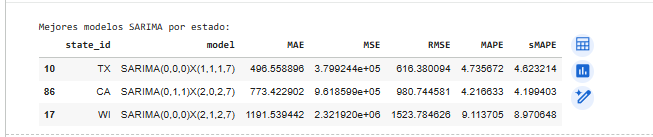

In [164]:
best_models_per_state = pd.DataFrame(all_state_results)

# nos quedamos con columnas ordenadas
best_models_per_state = best_models_per_state[
    ['state_id', 'model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'sMAPE']
].sort_values('MAE')

print("\nMejores modelos SARIMA por estado:")
display(best_models_per_state)



Mejores modelos SARIMA por estado:


state_id                    model          MAE           MSE         RMSE  \
10       TX  SARIMA(0,0,0)X(1,1,1,7)   496.558896  3.799244e+05   616.380094   
86       CA  SARIMA(0,1,1)X(2,0,2,7)   773.422902  9.618599e+05   980.744581   
17       WI  SARIMA(0,0,0)X(2,1,2,7)  1191.539442  2.321920e+06  1523.784626   

        MAPE     sMAPE  
10  4.735672  4.623214  
86  4.216633  4.199403  
17  9.113705  8.970648

In [165]:
sarima_preds_state = pd.concat(all_state_preds, ignore_index=True)
print("\nEjemplo de predicciones SARIMA por estado:")
display(sarima_preds_state.head())



Ejemplo de predicciones SARIMA por estado:


state_id       date   sarima_pred
0       CA 2016-03-27  22337.579598
1       CA 2016-03-28  17159.486287
2       CA 2016-03-29  15641.920849
3       CA 2016-03-30  15276.920911
4       CA 2016-03-31  15344.337250

In [166]:
# Unimos ventas reales con predicciones por estado
state_daily_arima = state_daily.merge(
    sarima_preds_state,
    on=['state_id', 'date'],
    how='left'
)

state_daily_arima = state_daily_arima.sort_values(['state_id', 'date'])

# Fecha máxima disponible (para acotar a 90 días)
last_date = state_daily_arima['date'].max()
days_plot = 90
plot_start = last_date - pd.Timedelta(days=days_plot - 1)

# Filtramos solo los últimos 90 días
state_daily_plot = state_daily_arima[
    state_daily_arima['date'].between(plot_start, last_date)
].copy()

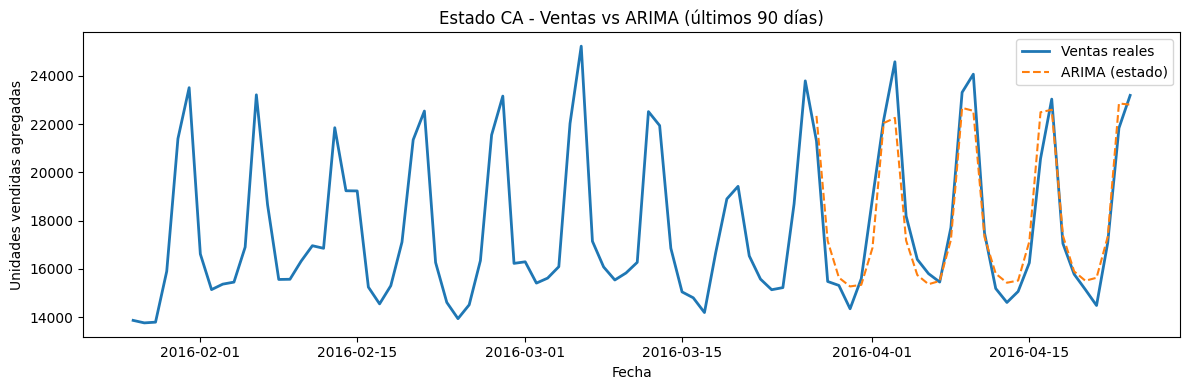

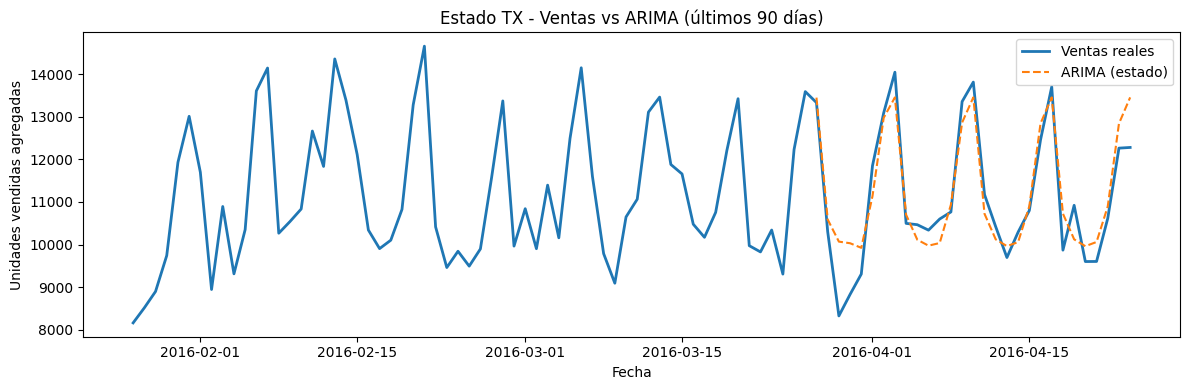

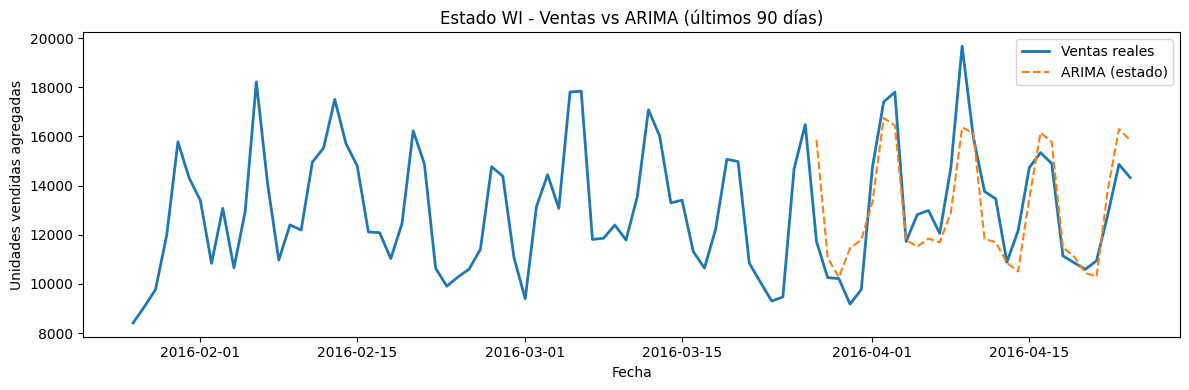

In [167]:
state_ids = state_daily_plot['state_id'].unique()

for state in state_ids:
    data_state = state_daily_plot[state_daily_plot['state_id'] == state]

    plt.figure(figsize=(12, 4))
    plt.plot(
        data_state['date'],
        data_state['sales'],
        label='Ventas reales',
        linewidth=2
    )
    plt.plot(
        data_state['date'],
        data_state['sarima_pred'],
        label='ARIMA (estado)',
        linestyle='--'
    )
    plt.title(f'Estado {state} - Ventas vs ARIMA (últimos {days_plot} días)')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades vendidas agregadas')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [168]:
# Agregado total (sumando todos los estados)
total_daily_arima = (
    state_daily_arima
    .groupby('date')[['sales', 'sarima_pred']]
    .sum()
    .reset_index()
)

# Filtrar últimos 90 días
total_daily_plot = total_daily_arima[
    total_daily_arima['date'].between(plot_start, last_date)
].copy()


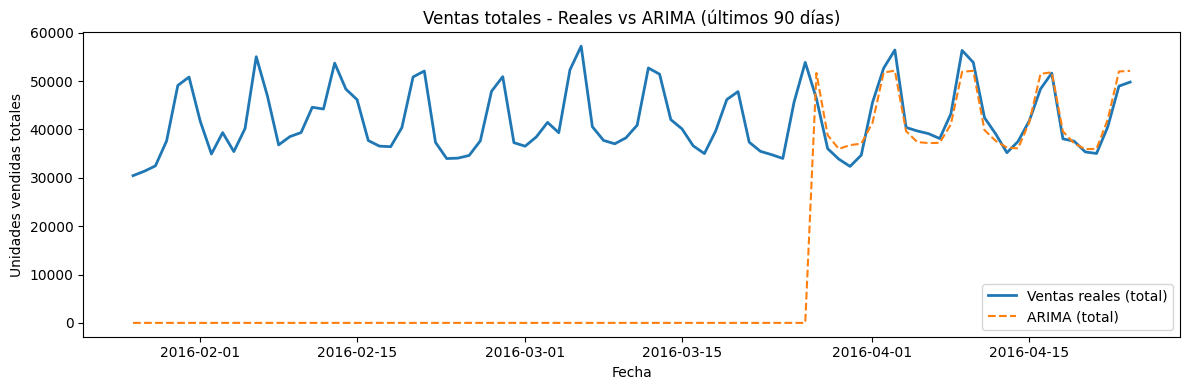

In [169]:
plt.figure(figsize=(12, 4))
plt.plot(
    total_daily_plot['date'],
    total_daily_plot['sales'],
    label='Ventas reales (total)',
    linewidth=2
)
plt.plot(
    total_daily_plot['date'],
    total_daily_plot['sarima_pred'],
    label='ARIMA (total)',
    linestyle='--'
)
plt.title(f'Ventas totales - Reales vs ARIMA (últimos {days_plot} días)')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas totales')
plt.legend()
plt.tight_layout()
plt.show()


## 5.3 XGBoost

In [ ]:
trainning_features = ['snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'sales_lag_7', 'sales_rolling_mean_7','sales_rolling_std_7','price_lag_1','price_rolling_mean_7','price_rolling_std_7','price_diff_1','price_ratio_1','sales','dates']
trainning_features2 = ['snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'sales_lag_7', 'sales_rolling_mean_7','sales_rolling_std_7','price_lag_1','price_rolling_mean_7','price_rolling_std_7','price_diff_1','price_ratio_1','sales'] #Datos contemplados para entrenar los modelos.

In [ ]:
df_m_mc = df_transformado.sort_values(by = 'date')

df_m_mc = df_m_mc.set_index("date")


In [ ]:
df_tiendas_mc = df_m_mc.groupby(["store_id","date"])[trainning_features2].sum().reset_index().set_index('date')
df_estados_mc = df_m_mc.groupby(["state_id","date"])[trainning_features2].sum().reset_index().set_index('date')

C:\Users\jqnra\AppData\Local\Temp\ipykernel_10944\762262274.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tiendas_mc = df_m_mc.groupby(["store_id","date"])[trainning_features2].sum().reset_index().set_index('date')
C:\Users\jqnra\AppData\Local\Temp\ipykernel_10944\762262274.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_estados_mc = df_m_mc.groupby(["state_id","date"])[trainning_features2].sum().reset_index().set_index('date')


In [ ]:
df_tiendas_mc.head()

store_id  snap_CA  snap_TX  snap_WI    sell_price  sales_lag_7  \
date                                                                        
2015-04-26     CA_1        0        0        0  13639.047852      -3036.0   
2015-04-27     CA_1        0        0        0  13639.047852      -3036.0   
2015-04-28     CA_1        0        0        0  13639.047852      -3036.0   
2015-04-29     CA_1        0        0        0  13639.047852      -3036.0   
2015-04-30     CA_1        0        0        0  13639.047852      -3036.0   

            sales_rolling_mean_7  sales_rolling_std_7   price_lag_1  \
date                                                                  
2015-04-26           5815.000000         -3036.000000  -3036.000000   
2015-04-27           4905.000000          3030.659664  13639.047852   
2015-04-28           4445.333333          3310.609332  13639.047852   
2015-04-29           4224.000000          3381.263926  13639.047852   
2015-04-30           4072.400000          3381.003595  13639.047852   

            price_rolling_mean_7  price_rolling_std_7  price_diff_1  \
date                                                                  
2015-04-26          13639.047852              -3036.0       -3036.0   
2015-04-27          13639.047852                  0.0           0.0   
2015-04-28          13639.047852                  0.0           0.0   
2015-04-29          13639.047852                  0.0           0.0   
2015-04-30          13639.047852                  0.0           0.0   

            price_ratio_1  sales  
date                              
2015-04-26        -3036.0   5815  
2015-04-27         3036.0   3995  
2015-04-28         3036.0   3526  
2015-04-29         3036.0   3560  
2015-04-30         3036.0   3466

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb_models = {}
rmse_xgb = {}
tiendas = df_tiendas_mc["store_id"].unique()
for tienda in tiendas:

    df_tienda = df_tiendas_mc[df_tiendas_mc["store_id"] == tienda].copy()

    # --- Ordenar por fecha ---
    df_tienda = df_tienda.sort_values("date")

    # --- 1. Construcción de X e y ---
    X = df_tienda[trainning_features2].drop('sales', axis=1).iloc[25:]
    y = df_tienda['sales'].iloc[25:]

    # --- 2. Train-test split (temporal) ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False
    )

    # --- 3. Definir modelo XGBoost ---
    xgb_models[tienda] = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        tree_method='hist'   # más rápido
    )

    # --- 4. Entrenamiento ---
    xgb_models[tienda].fit(X_train, y_train)

    # --- 5. Predicción ---
    y_pred_xgb = xgb_models[tienda].predict(X_test)

    # --- 6. RMSE ---
    rmse_xgb[tienda] = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

    print(f"Producto {i} → RMSE XGBoost: {rmse_xgb[tienda]:.3f}")

Producto 1 → RMSE XGBoost: 511.895
Producto 1 → RMSE XGBoost: 881.125
Producto 1 → RMSE XGBoost: 860.499
Producto 1 → RMSE XGBoost: 276.156
Producto 1 → RMSE XGBoost: 347.152
Producto 1 → RMSE XGBoost: 565.053
Producto 1 → RMSE XGBoost: 360.703
Producto 1 → RMSE XGBoost: 683.881
Producto 1 → RMSE XGBoost: 961.780
Producto 1 → RMSE XGBoost: 660.227


In [ ]:
y_pred_true_xgb = {}
y_true_testing = {}
true_rmse_xgb = {}
for tienda in tiendas:

    df_tienda = df_tiendas_mc[df_tiendas_mc["store_id"] == tienda].copy()

    # --- Ordenar por fecha ---
    df_tienda = df_tienda.sort_values("date")


    X = df_tienda[trainning_features2].drop('sales', axis=1).iloc[:25]
    y_true_testing[tienda] = df_tienda['sales'].iloc[:25]
    y_pred_true_xgb[tienda] = xgb_models[tienda].predict(X)
    true_rmse_xgb[tienda] = np.sqrt(mean_squared_error(y_true_testing[tienda], y_pred_true_xgb[tienda]))
    print(f"Producto {tienda} → RMSE XGBoost: {true_rmse_xgb[tienda]:.3f}")

Producto CA_1 → RMSE XGBoost: 665.890
Producto CA_2 → RMSE XGBoost: 517.884
Producto CA_3 → RMSE XGBoost: 752.897
Producto CA_4 → RMSE XGBoost: 251.820
Producto TX_1 → RMSE XGBoost: 387.623
Producto TX_2 → RMSE XGBoost: 454.659
Producto TX_3 → RMSE XGBoost: 637.299
Producto WI_1 → RMSE XGBoost: 519.750
Producto WI_2 → RMSE XGBoost: 738.860
Producto WI_3 → RMSE XGBoost: 638.858


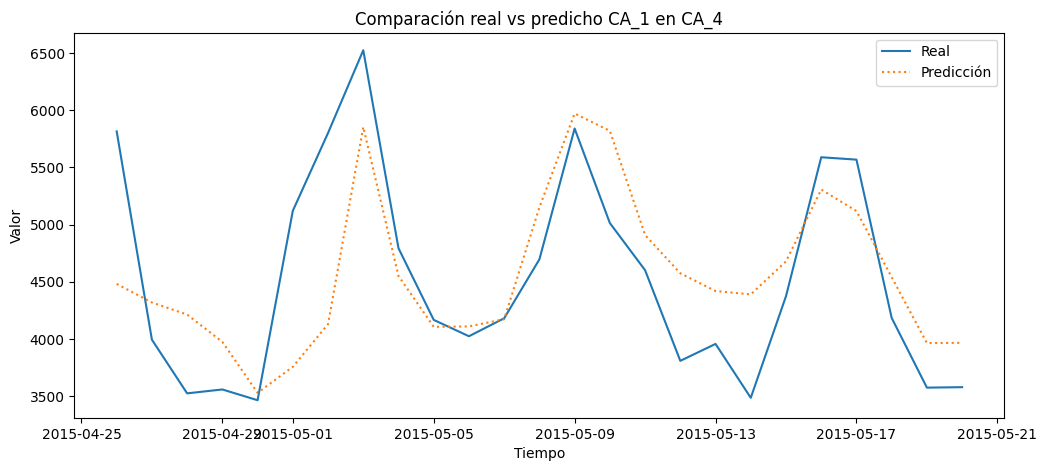

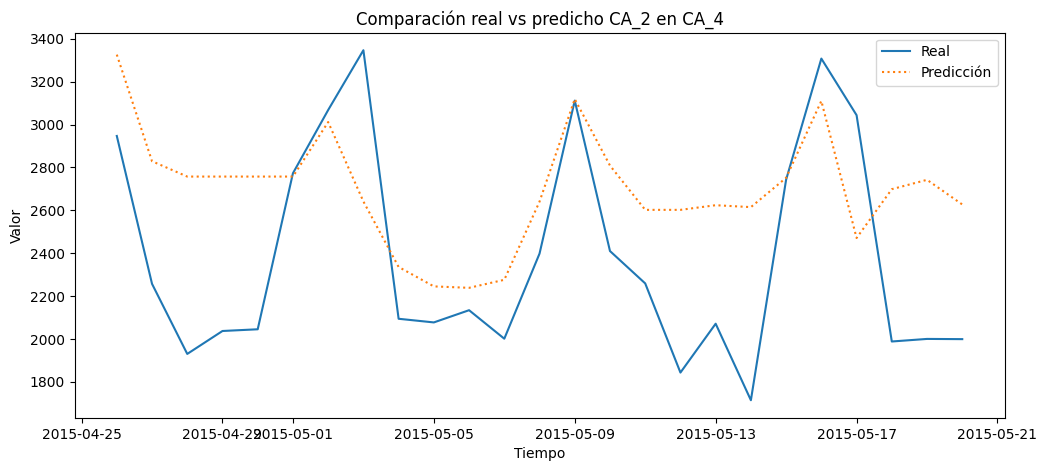

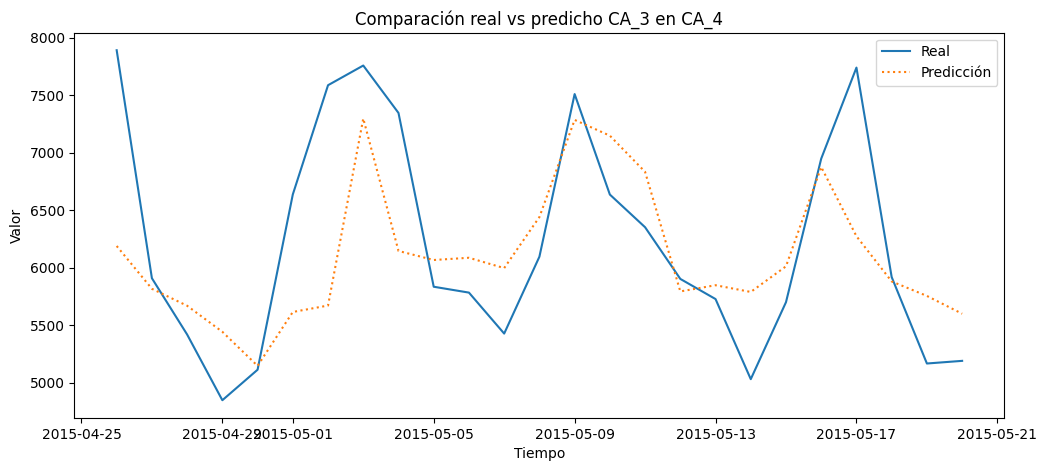

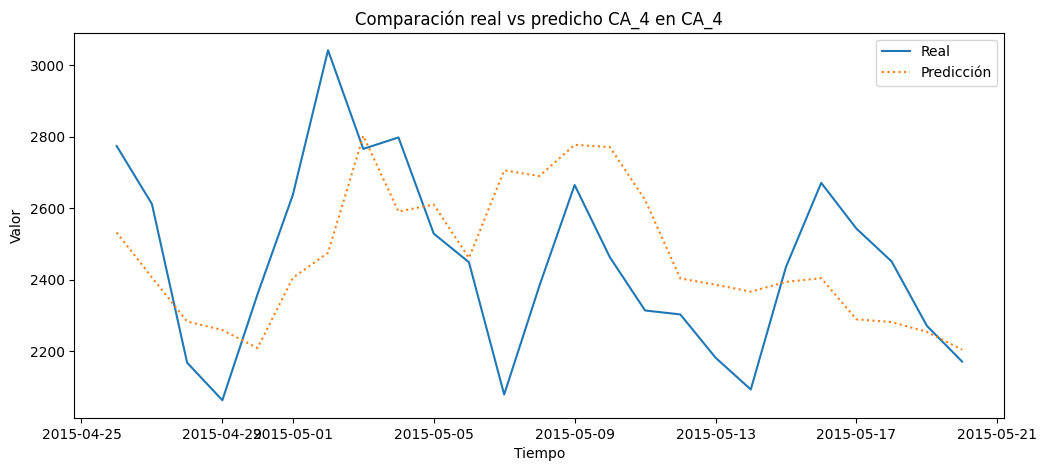

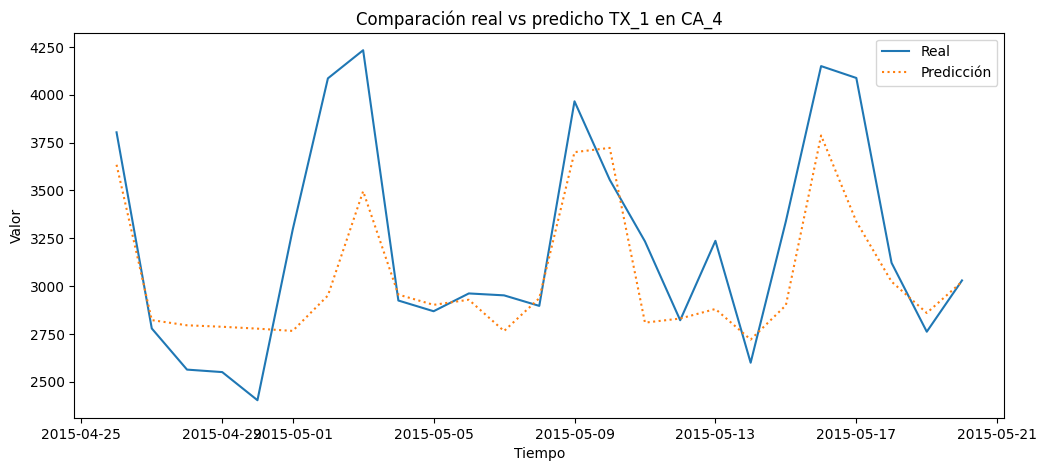

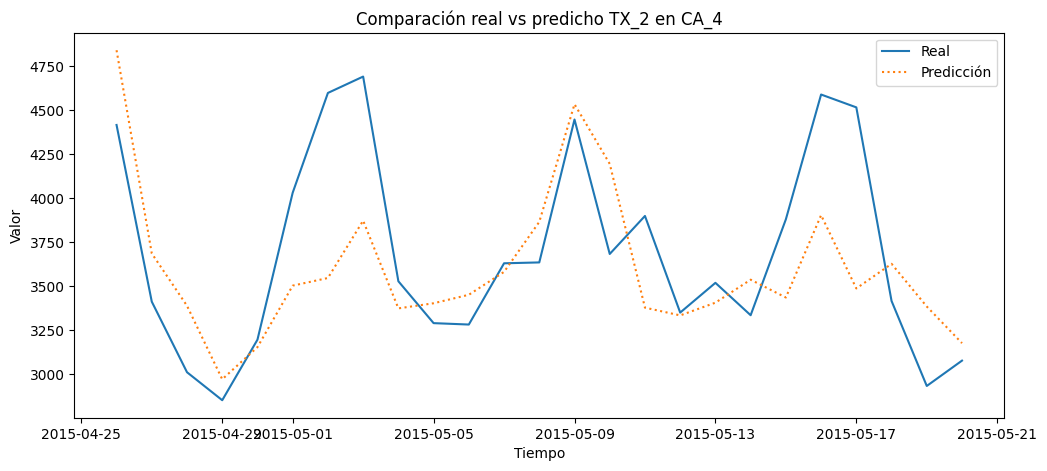

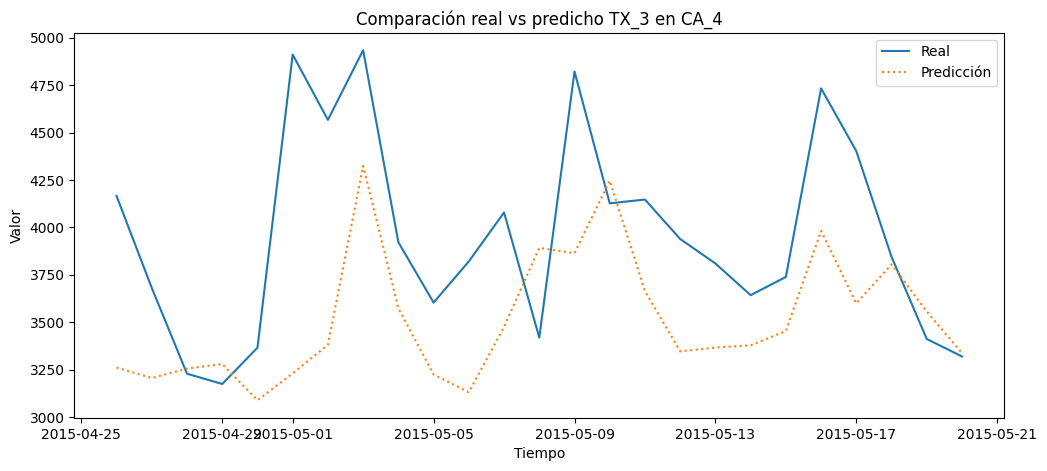

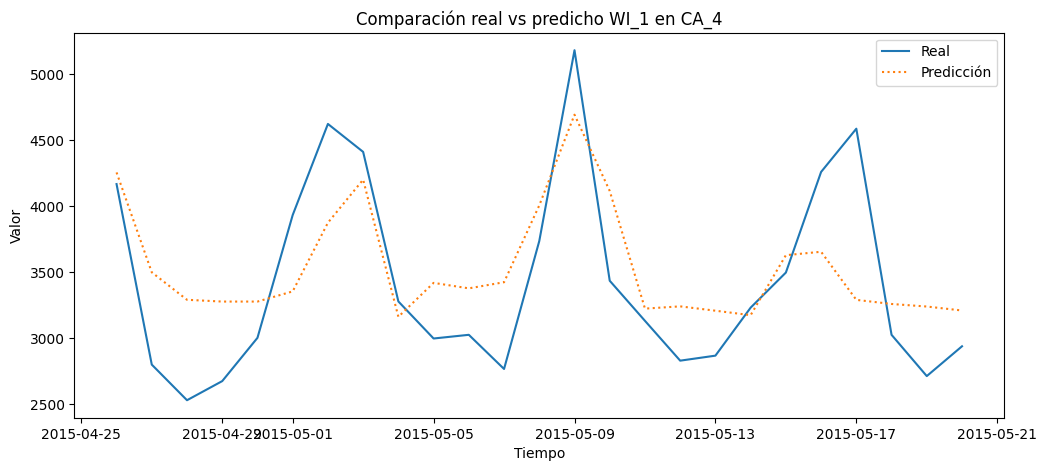

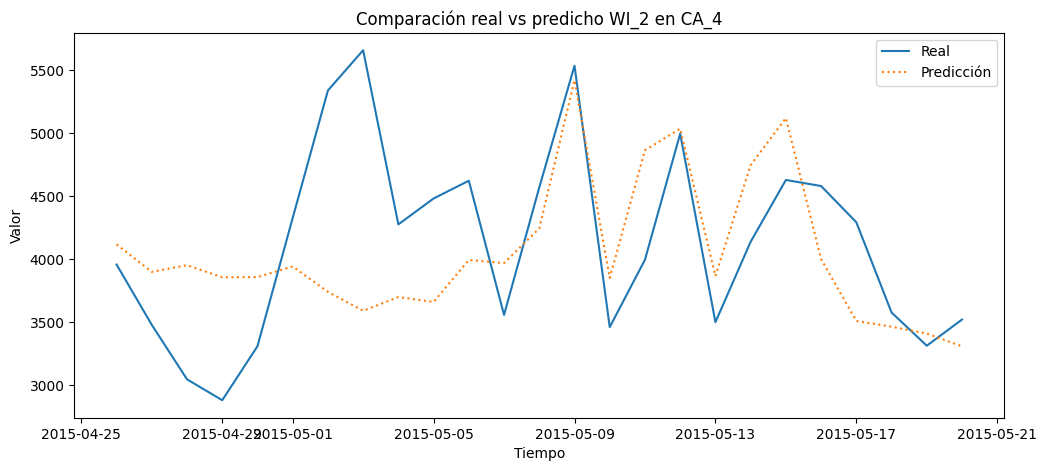

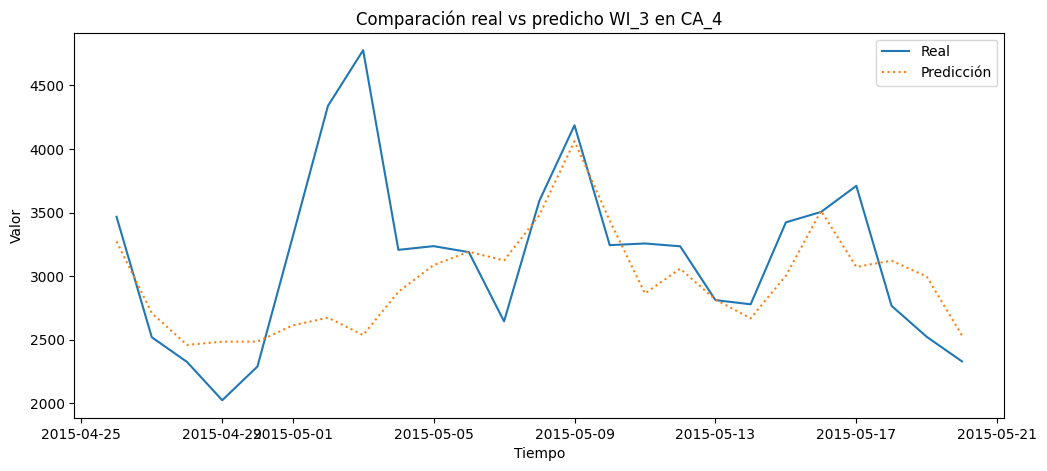

In [ ]:
for i in tiendas:
    plt.figure(figsize=(12,5))

    plt.plot(y_true_testing[i].index, y_true_testing[i].values, label="Real")
    plt.plot(y_true_testing[i].index, y_pred_true_xgb[i], label="Predicción", linestyle= ":")

    plt.legend()
    plt.title("Comparación real vs predicho " + i)
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")

    plt.show()

Por estado

In [ ]:
xgb_models2 = {}
rmse_xgb2 = {}
estados = df_estados_mc["state_id"].unique()
for estado in estados:

    df_estado = df_estados_mc[df_estados_mc["state_id"] == estado].copy()

    # --- Ordenar por fecha ---
    df_estado = df_estado.sort_values("date")

    # --- 1. Construcción de X e y ---
    X = df_estado[trainning_features2].drop('sales', axis=1).iloc[25:]
    y = df_estado['sales'].iloc[25:]

    # --- 2. Train-test split (temporal) ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False
    )

    # --- 3. Definir modelo XGBoost ---
    xgb_models2[estado] = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        tree_method='hist'   # más rápido
    )

    # --- 4. Entrenamiento ---
    xgb_models2[estado].fit(X_train, y_train)

    # --- 5. Predicción ---
    y_pred_xgb = xgb_models2[estado].predict(X_test)

    # --- 6. RMSE ---
    rmse_xgb2[estado] = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

    print(f"Producto {i} → RMSE XGBoost: {rmse_xgb2[estado]:.3f}")

Producto WI_3 → RMSE XGBoost: 1723.650
Producto WI_3 → RMSE XGBoost: 992.959
Producto WI_3 → RMSE XGBoost: 3034.374


In [ ]:
y_pred_true_xgb2 = {}
y_true_testing2 = {}
true_rmse_xgb2 = {}
for estado in estados:

    df_estado = df_estados_mc[df_estados_mc["state_id"] == estado].copy()

    # --- Ordenar por fecha ---
    df_estado = df_estado.sort_values("date")


    X = df_estado[trainning_features2].drop('sales', axis=1).iloc[:25]
    y_true_testing2[estado] = df_estado['sales'].iloc[:25]
    y_pred_true_xgb2[estado] = xgb_models2[estado].predict(X)
    true_rmse_xgb2[estado] = np.sqrt(mean_squared_error(y_true_testing2[estado], y_pred_true_xgb2[estado]))
    print(f"Producto {estado} → RMSE XGBoost: {true_rmse_xgb2[estado]:.3f}")

Producto CA → RMSE XGBoost: 2131.617
Producto TX → RMSE XGBoost: 1333.556
Producto WI → RMSE XGBoost: 1783.532


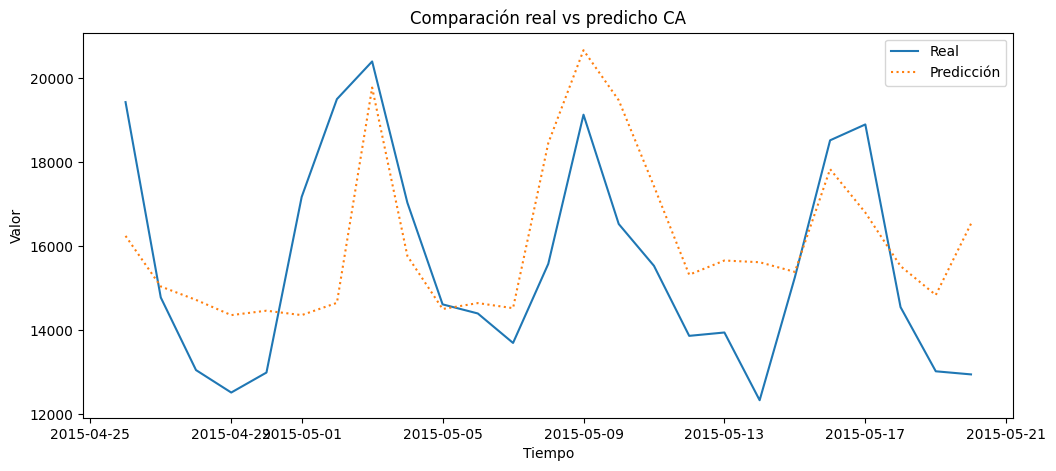

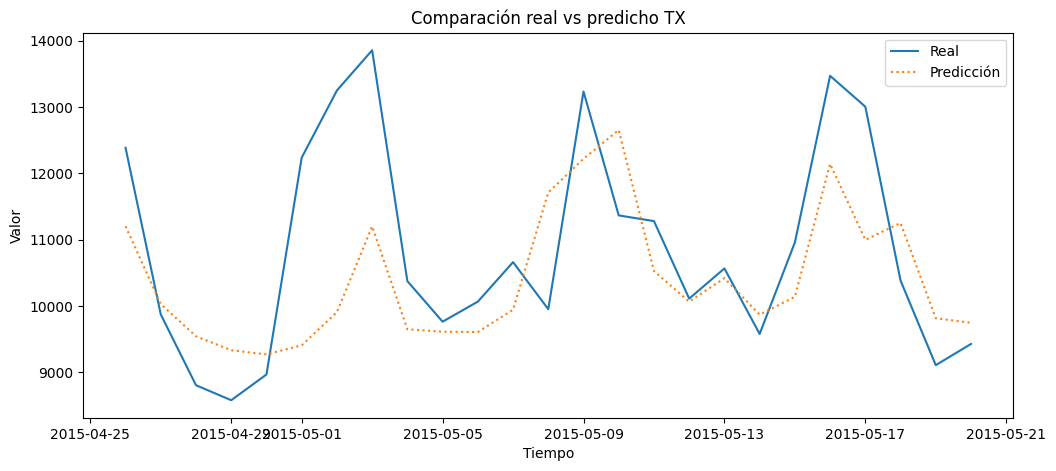

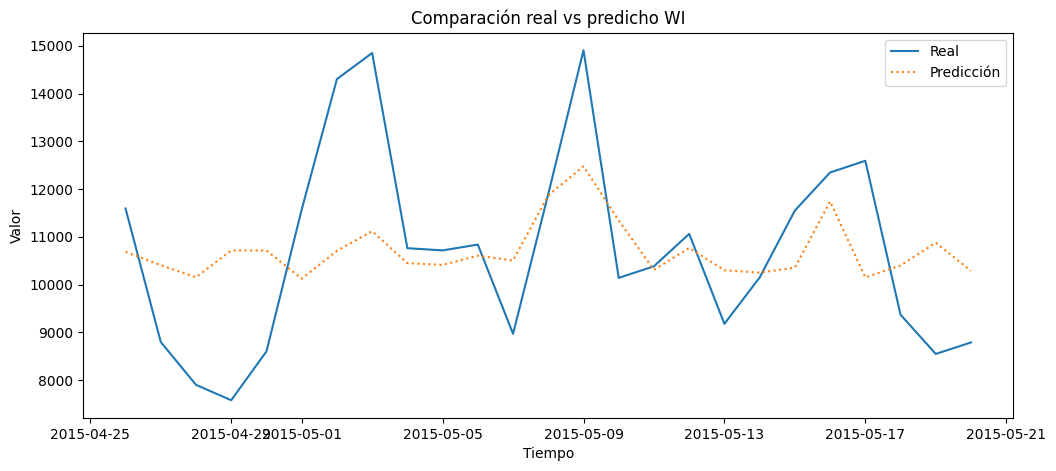

In [ ]:
for i in estados:
    plt.figure(figsize=(12,5))

    plt.plot(y_true_testing2[i].index, y_true_testing2[i].values, label="Real")
    plt.plot(y_true_testing2[i].index, y_pred_true_xgb2[i], label="Predicción", linestyle= ":")

    plt.legend()
    plt.title("Comparación real vs predicho " + i )
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")

    plt.show()

## 5.4 Red neuronal

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Por Tienda

In [ ]:
model = {}
rmse_rrn = {}

tiendas = df_tiendas_mc["store_id"].unique()

for tienda in tiendas:

    # --- Filtrar por tienda ---
    df_tienda = df_tiendas_mc[df_tiendas_mc["store_id"] == tienda].copy()

    # --- Orden temporal ---
    df_tienda = df_tienda.sort_values("date")

    # --- Features y target ---
    X = df_tienda[trainning_features2].drop("sales", axis=1).iloc[25:]
    y = df_tienda["sales"].iloc[25:]

    # --- Train-test split (temporal, sin shuffle) ---
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        shuffle=False
    )

    # --- Modelo neural ---
    model[tienda] = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model[tienda].compile(optimizer='adam', loss='mse')

    # --- Entrenamiento ---
    history = model[tienda].fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=1
    )

    # --- Predicción ---
    y_pred = model[tienda].predict(X_test).flatten()

    # --- RMSE ---
    rmse_rrn[tienda] = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Tienda {tienda} → RMSE RRN: {rmse_rrn[tienda]:.3f}")

Epoch 1/50


c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 11075824.0000 - val_loss: 970273.4375
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3219631.7500 - val_loss: 3242090.2500
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2921760.0000 - val_loss: 944952.2500
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1185466.7500 - val_loss: 2760358.2500
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1522546.3750 - val_loss: 1604311.0000
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 860008.9375 - val_loss: 891355.9375
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 982983.9375 - val_loss: 889774.0000
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 796078.8750 - val_loss: 1201374.7500
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 806940.3750 - val_loss: 1194324.0000
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 753141.5625 - val_loss: 932495.1875
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 736726.3750 - val_l

c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8428440.0000 - val_loss: 900931.4375
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1508682.2500 - val_loss: 3510048.0000
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2231752.5000 - val_loss: 1302332.1250
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 656556.3125 - val_loss: 1041326.7500
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 937476.1875 - val_loss: 1041937.0000
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 575417.9375 - val_loss: 793799.4375
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 551993.5000 - val_loss: 952259.2500
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 498484.8125 - val_loss: 763451.6875
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 438085.8125 - val_loss: 776983.9375
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 433794.6250 - val_loss: 748252.1875
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 392475.0000 - val_loss

c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 89410912.0000 - val_loss: 37252996.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 33668468.0000 - val_loss: 8105045.5000
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8109698.0000 - val_loss: 1295471.6250
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1351774.1250 - val_loss: 3195138.0000
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1534145.1250 - val_loss: 4901094.5000
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1786337.6250 - val_loss: 4052107.0000
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1184197.0000 - val_loss: 2609886.2500
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 796674.6875 - val_loss: 1675518.8750
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 728719.0000 - val_loss: 1374206.3750
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 764963.8125 - val_loss: 1365855.7500
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 72234

c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4436820.0000 - val_loss: 286618.7188
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 399545.9375 - val_loss: 1483376.8750
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 804910.7500 - val_loss: 847429.1875
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 225792.9688 - val_loss: 215010.7344
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 171149.7969 - val_loss: 191444.7031
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 189851.5312 - val_loss: 186647.0000
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 106181.5156 - val_loss: 292061.0938
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 109244.7891 - val_loss: 316052.8750
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 99260.2344 - val_loss: 243547.3750
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 92117.2656 - val_loss: 206548.2969
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 91183.5781 - val_loss: 217524.

c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5262243.5000 - val_loss: 694081.7500
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1225298.5000 - val_loss: 1080619.3750
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1363616.6250 - val_loss: 455658.3750
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 607463.8125 - val_loss: 1247266.6250
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 712719.3125 - val_loss: 952930.6875
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 489680.0938 - val_loss: 460566.2500
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 510067.9688 - val_loss: 459050.6562
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 434075.5000 - val_loss: 675575.5000
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 433935.1250 - val_loss: 693758.5625
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 415177.7812 - val_loss: 543762.3125
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 406958.3125 - val_loss:

c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 87336264.0000 - val_loss: 46807200.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 36924400.0000 - val_loss: 18382522.0000
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13927889.0000 - val_loss: 4743871.5000
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3055707.5000 - val_loss: 543585.7500
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 583589.4375 - val_loss: 1637240.6250
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1365580.1250 - val_loss: 2221238.7500
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1243727.0000 - val_loss: 1293933.8750
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 580902.5625 - val_loss: 676331.9375
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 389523.8750 - val_loss: 539415.1875
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 417767.1250 - val_loss: 534301.7500
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 432023.

c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2626365.0000 - val_loss: 1680597.3750
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1281108.2500 - val_loss: 2249908.0000
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 570384.3750 - val_loss: 444047.0312
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 595545.6250 - val_loss: 399845.7188
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 409885.0000 - val_loss: 837742.0000
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 389376.3438 - val_loss: 992943.3125
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 353513.5625 - val_loss: 537786.2500
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 337617.1250 - val_loss: 528169.9375
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 321674.2812 - val_loss: 737706.5000
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 318124.7812 - val_loss: 638601.3125
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 315374.1562 - val_l

c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 17930712.0000 - val_loss: 7807962.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3052450.0000 - val_loss: 977037.9375
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 969183.5000 - val_loss: 2430997.7500
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1945518.1250 - val_loss: 1807858.5000
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 895250.1875 - val_loss: 931238.5000
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 481584.4062 - val_loss: 1136383.3750
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 617432.4375 - val_loss: 1087855.2500
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 487315.2812 - val_loss: 908391.5000
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 390229.1875 - val_loss: 897353.5000
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 408169.5625 - val_loss: 885834.0625
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 383692.8438 - val_

c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 896720.7500 - val_loss: 1206247.5000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 473770.6875 - val_loss: 785004.8125
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 418794.0938 - val_loss: 1006478.4375
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 380322.0938 - val_loss: 677853.5625
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 335295.3125 - val_loss: 746849.5000
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 302010.9062 - val_loss: 691955.8125
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 285922.3438 - val_loss: 643061.9375
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 280654.1562 - val_loss: 680521.3125
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 261473.8906 - val_loss: 621754.8125
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 257906.5625 - val_loss: 666075.3125
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 257138.1406 - val_loss: 6121

c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8513291.0000 - val_loss: 3115803.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1220838.2500 - val_loss: 736203.2500
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1034376.7500 - val_loss: 1480271.1250
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1011325.8125 - val_loss: 775333.4375
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 423653.3125 - val_loss: 669681.0625
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 443087.1562 - val_loss: 771815.0000
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 445038.6562 - val_loss: 669490.4375
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 352669.5938 - val_loss: 583424.0625
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 314001.5625 - val_loss: 571755.6875
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 307142.3125 - val_loss: 551390.8125
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 283618.7500 - val

In [ ]:
y_pred_true_rrn = {}
true_rmse_rrn = {}
y_true_testing = {}

for tienda in tiendas:

    df_tienda = df_tiendas_mc[df_tiendas_mc["store_id"] == tienda].copy()

    # --- Ordenar por fecha ---
    df_tienda = df_tienda.sort_values("date")

    # --- Tomar las primeras 25 filas (igual que hiciste con XGB) ---
    X = df_tienda[trainning_features2].drop("sales", axis=1).iloc[:25]
    y_true_testing[tienda] = df_tienda["sales"].iloc[:25]

    # --- Predicción con tu red neuronal ---
    y_pred_true_rrn[tienda] = model[tienda].predict(X).flatten()

    # --- RMSE ---
    true_rmse_rrn[tienda] = np.sqrt(mean_squared_error(
        y_true_testing[tienda],
        y_pred_true_rrn[tienda]
    ))

    print(f"Tienda {tienda} → RMSE RRN: {true_rmse_rrn[tienda]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Tienda CA_1 → RMSE RRN: 2234.742
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Tienda CA_2 → RMSE RRN: 1281.136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Tienda CA_3 → RMSE RRN: 2535.077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tienda CA_4 → RMSE RRN: 925.223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tienda TX_1 → RMSE RRN: 747.677
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tienda TX_2 → RMSE RRN: 1091.446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Tienda TX_3 → RMSE RRN: 1492.714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Tienda WI_1 → RMSE RRN: 1836.889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Tienda WI_2 → RMSE RRN: 1099.027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Tienda WI_3 → RMSE RRN: 525.826


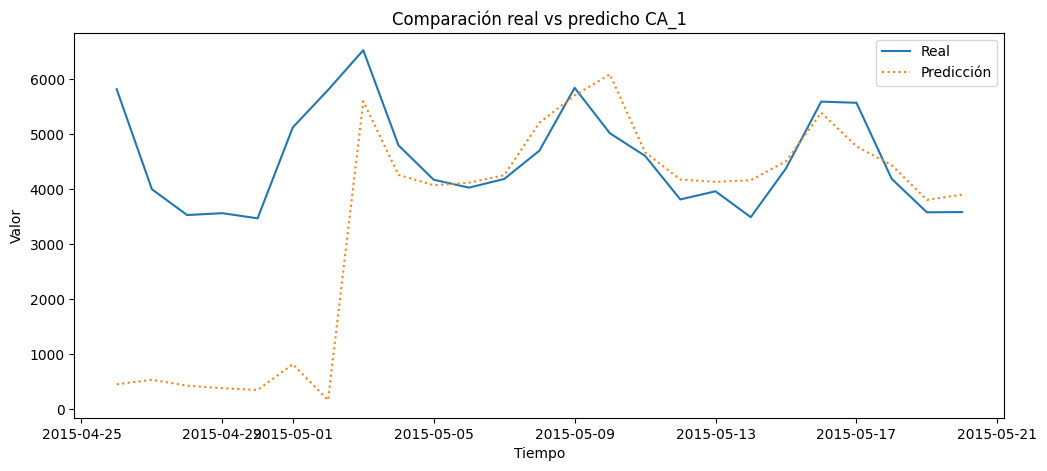

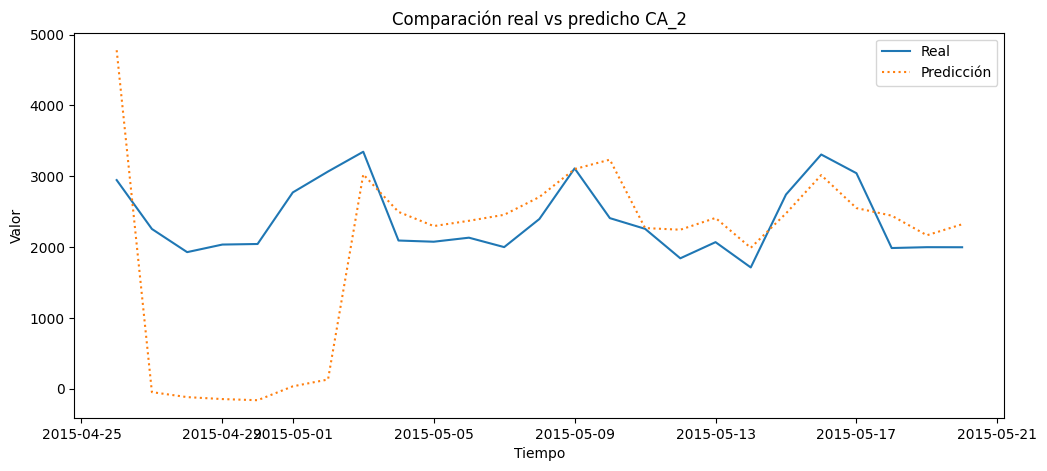

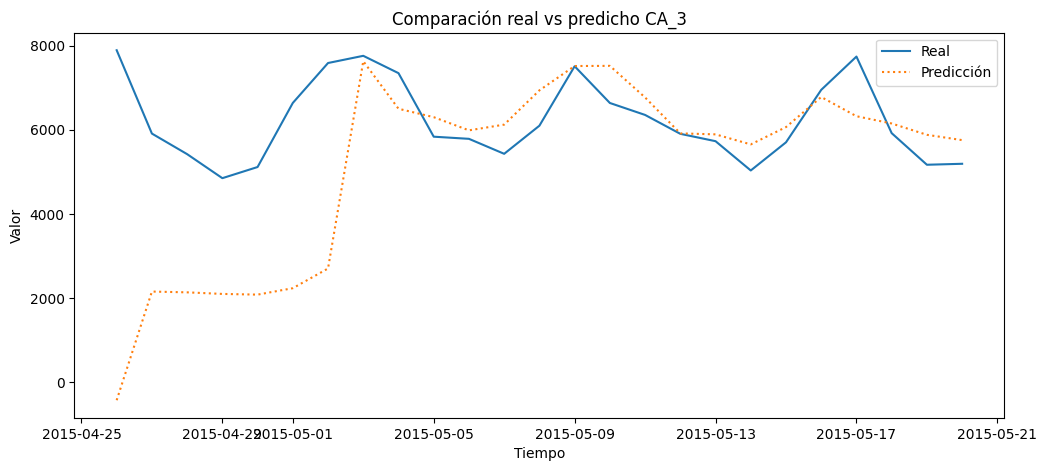

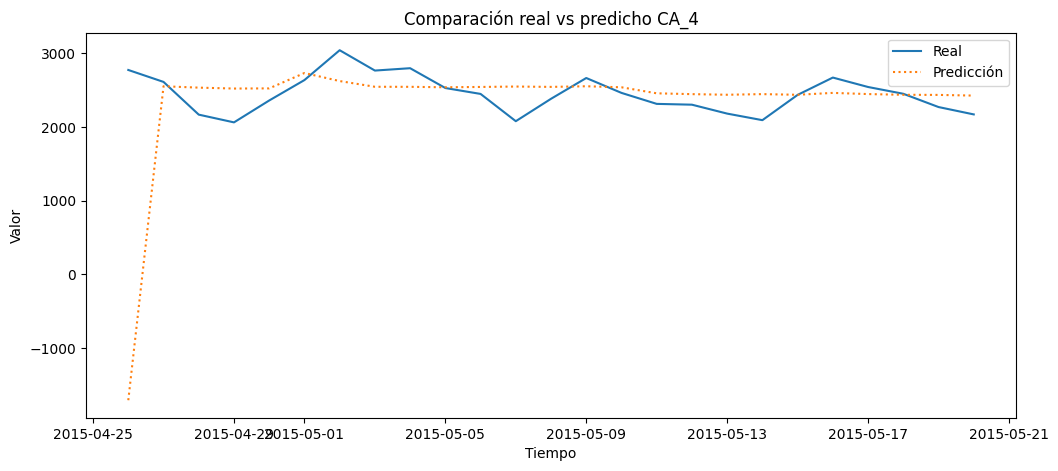

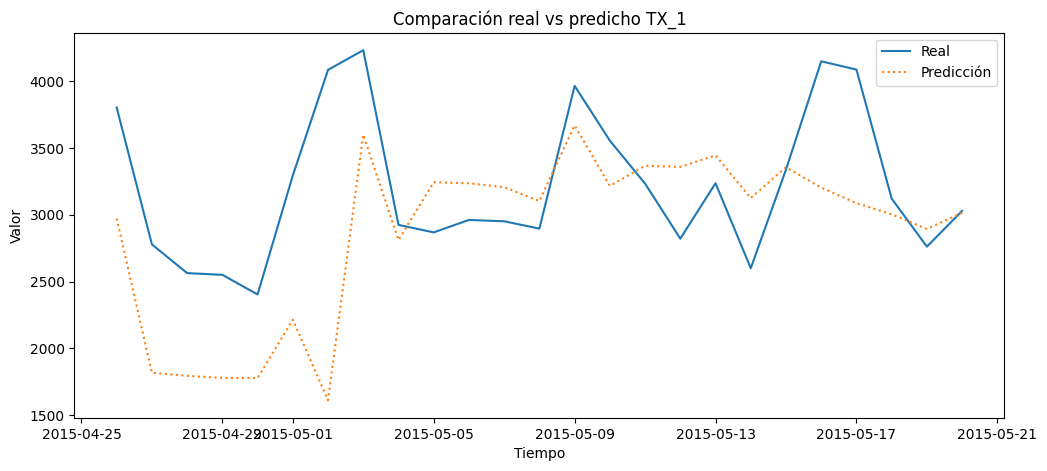

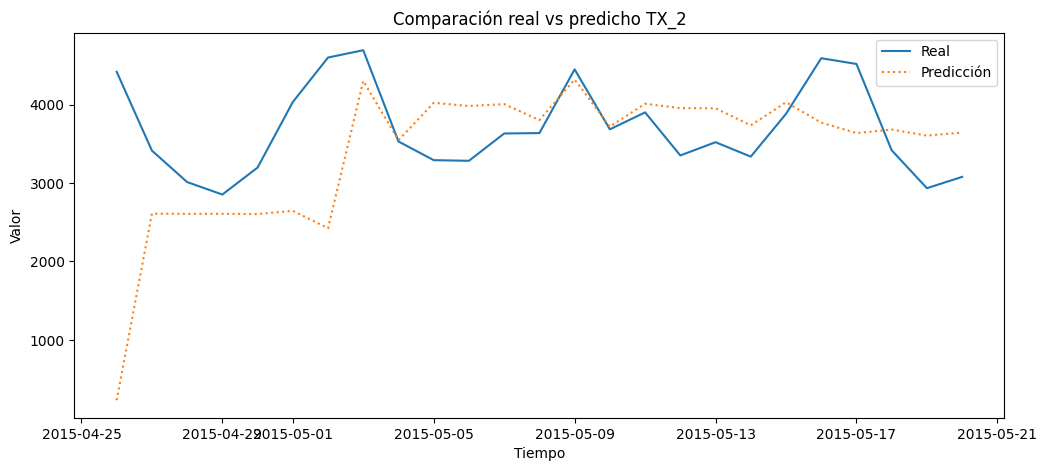

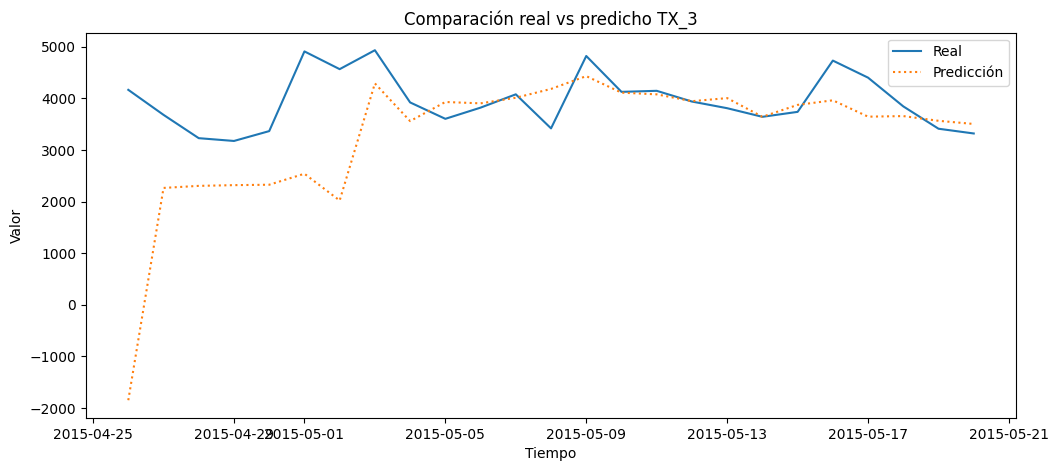

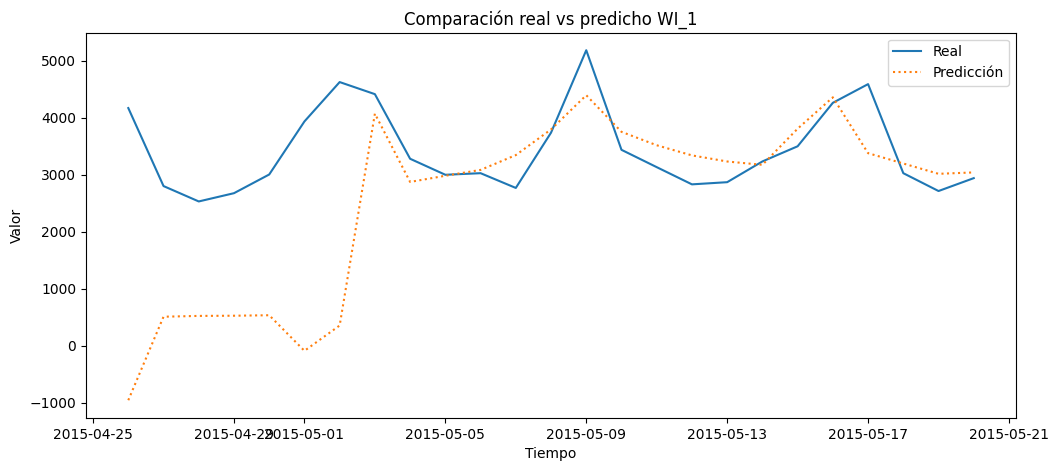

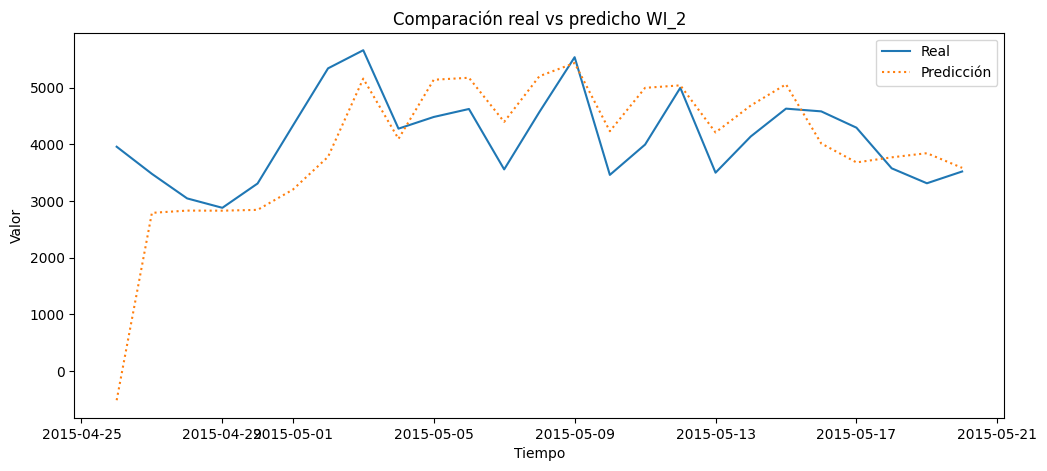

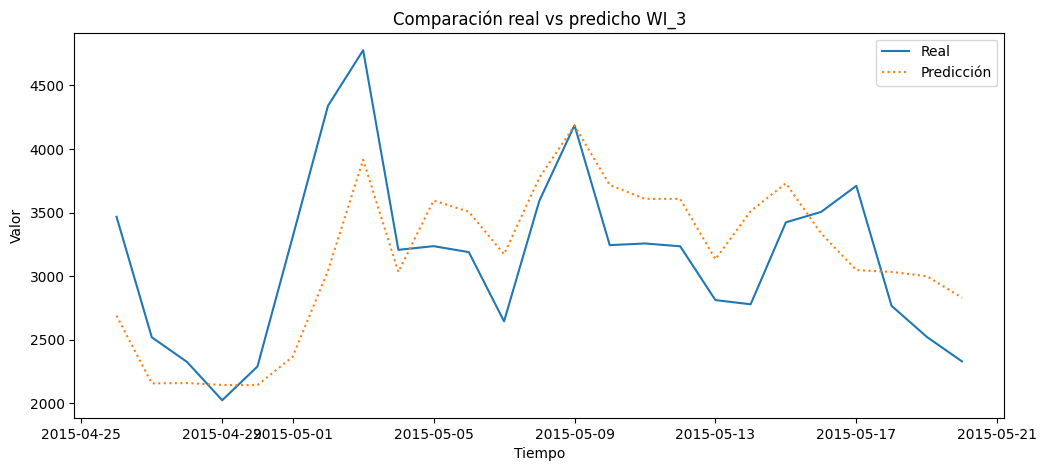

In [ ]:
for i in tiendas:
    plt.figure(figsize=(12,5))

    plt.plot(y_true_testing[i].index, y_true_testing[i].values, label="Real")
    plt.plot(y_true_testing[i].index, y_pred_true_rrn[i], label="Predicción", linestyle= ":")

    plt.legend()
    plt.title("Comparación real vs predicho " + i)
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")

    plt.show()

Por estado

In [ ]:
model2 = {}
rmse_rrn2 = {}

estados = df_estados_mc["state_id"].unique()

for estado in estados:

    # --- Filtrar por estado ---
    df_estado = df_estados_mc[df_estados_mc["state_id"] == estado].copy()

    # --- Orden temporal ---
    df_estado = df_estado.sort_values("date")

    # --- Features y target ---
    X = df_estado[trainning_features2].drop("sales", axis=1).iloc[25:]
    y = df_estado["sales"].iloc[25:]

    # --- Train-test split (temporal, sin shuffle) ---
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        shuffle=False
    )

    # --- Modelo neural ---
    model2[estado] = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model2[estado].compile(optimizer='adam', loss='mse')

    # --- Entrenamiento ---
    history = model2[estado].fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=1
    )

    # --- Predicción ---
    y_pred = model2[estado].predict(X_test).flatten()

    # --- RMSE ---
    rmse_rrn2[estado] = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Estado {estado} → RMSE RRN: {rmse_rrn2[estado]:.3f}")

Epoch 1/50


c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1343163136.0000 - val_loss: 584147968.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 386786496.0000 - val_loss: 114835224.0000
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 62440864.0000 - val_loss: 11255472.0000
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8477983.0000 - val_loss: 36462044.0000
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 28037332.0000 - val_loss: 53290560.0000
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 30764442.0000 - val_loss: 40539652.0000
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17999970.0000 - val_loss: 22813368.0000
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8848868.0000 - val_loss: 13757559.0000
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7121233.0000 - val_loss: 11559413.0000
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7918649.5000 - val_loss: 11263356.0000
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms

c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 11829980.0000 - val_loss: 16906908.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5665184.5000 - val_loss: 3840947.2500
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4890164.0000 - val_loss: 3797039.0000
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3456148.2500 - val_loss: 7588294.5000
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3244366.2500 - val_loss: 3744680.2500
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2948027.2500 - val_loss: 3955134.0000
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2735261.7500 - val_loss: 5139871.5000
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2608600.2500 - val_loss: 3717740.7500
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2496008.5000 - val_loss: 4249303.5000
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2553153.7500 - val_loss: 4241518.5000
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 240

c:\Users\jqnra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 295694976.0000 - val_loss: 83176896.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33335172.0000 - val_loss: 6216908.5000
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10591303.0000 - val_loss: 29995766.0000
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24744736.0000 - val_loss: 26205728.0000
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13259012.0000 - val_loss: 9204620.0000
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3472414.0000 - val_loss: 5772314.0000
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4428372.5000 - val_loss: 7182876.0000
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4848782.0000 - val_loss: 6018565.5000
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3155733.0000 - val_loss: 5571061.0000
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2742654.0000 - val_loss: 6203585.5000
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 290

In [ ]:
y_pred_true_rrn2 = {}
true_rmse_rrn2 = {}
y_true_testing2 = {}

for estado in estados:

    df_estado = df_estados_mc[df_estados_mc["state_id"] == estado].copy()

    # --- Ordenar por fecha ---
    df_estado = df_estado.sort_values("date")

    # --- Tomar las primeras 25 filas (igual que hiciste con XGB) ---
    X = df_estado[trainning_features2].drop("sales", axis=1).iloc[:25]
    y_true_testing2[estado] = df_estado["sales"].iloc[:25]

    # --- Predicción con tu red neuronal ---
    y_pred_true_rrn2[estado] = model2[estado].predict(X).flatten()

    # --- RMSE ---
    true_rmse_rrn2[estado] = np.sqrt(mean_squared_error(
        y_true_testing2[estado],
        y_pred_true_rrn2[estado]
    ))

    print(f"estado {estado} → RMSE RRN: {true_rmse_rrn2[estado]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
estado CA → RMSE RRN: 4490.481
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
estado TX → RMSE RRN: 3445.804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
estado WI → RMSE RRN: 4099.790


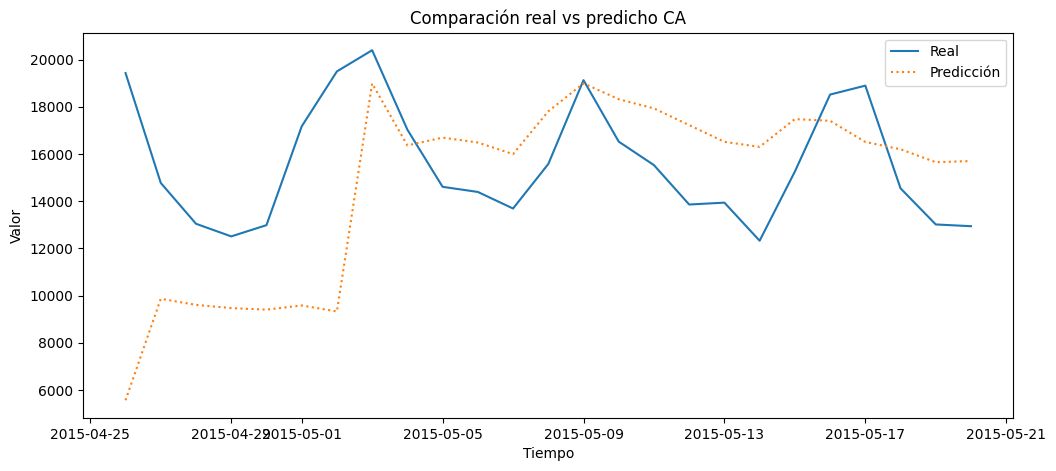

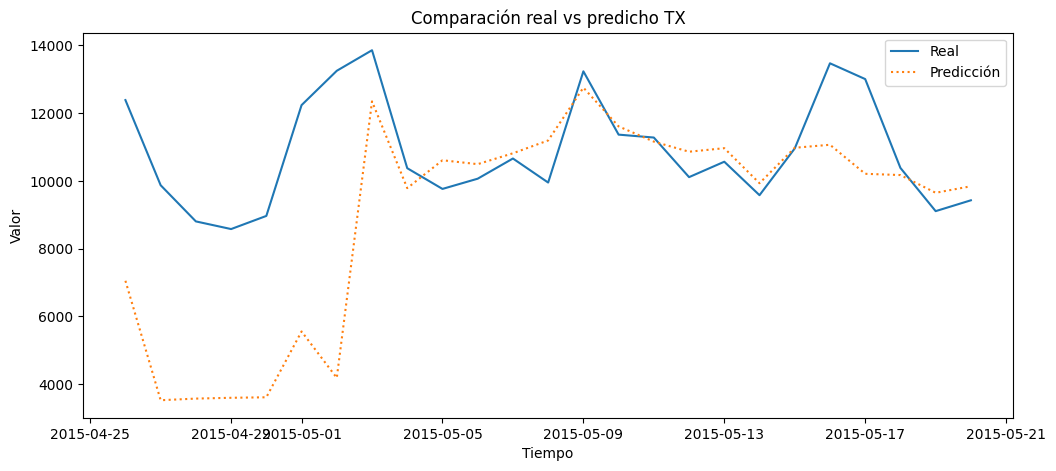

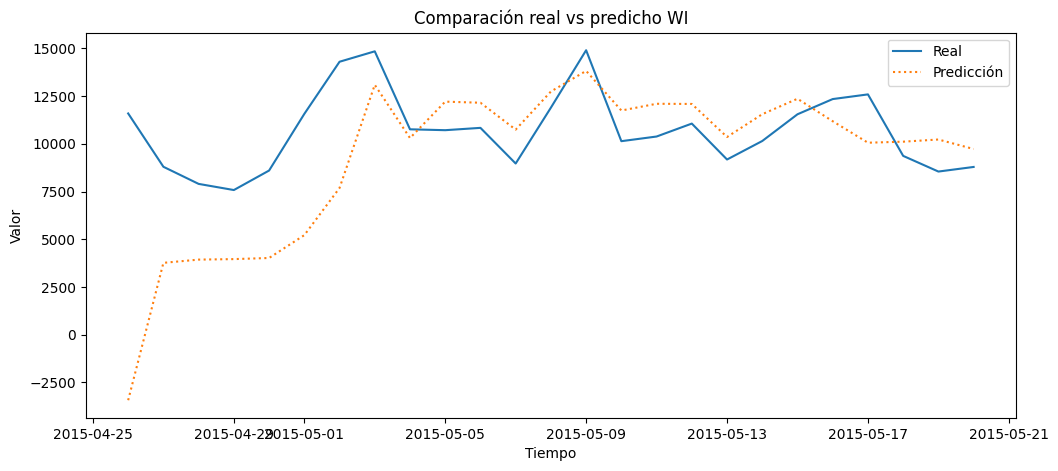

In [ ]:
for i in estados:
    plt.figure(figsize=(12,5))

    plt.plot(y_true_testing2[i].index, y_true_testing2[i].values, label="Real")
    plt.plot(y_true_testing2[i].index, y_pred_true_rrn2[i], label="Predicción", linestyle= ":")

    plt.legend()
    plt.title("Comparación real vs predicho " + i)
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")

    plt.show()

El XGBoosting parece predecir bastante mejor el fenómeno que la red neuronal, por ellos nos centraremos en calcular las métricas de este último.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_xgb_analisis_tiendas = {}
mae_xgb_analisis_tiendas = {}
r2_xgb_analisis_tiendas = {}

for tienda in tiendas:
    rmse_xgb_analisis_tiendas[tienda] = np.sqrt(mean_squared_error(y_pred_true_xgb[tienda], y_true_testing[tienda]))
    mae_xgb_analisis_tiendas[tienda] = mean_absolute_error(y_pred_true_xgb[tienda], y_true_testing[tienda])
    r2_xgb_analisis_tiendas[tienda] = r2_score(y_pred_true_xgb[tienda], y_true_testing[tienda])

    print(f"RMSE XGBoost predicción últimos 25 días tienda {tienda}: {rmse_xgb_analisis_tiendas[tienda]}")
    print(f"MAE XGBoost predicción últimos 25 días tienda {tienda}: {mae_xgb_analisis_tiendas[tienda]}")
    print(f"R2 XGBoost predicción últimos 25 días tienda {tienda}: {r2_xgb_analisis_tiendas[tienda]}")



RMSE XGBoost predicción últimos 25 días tienda CA_1: 665.890381369186
MAE XGBoost predicción últimos 25 días tienda CA_1: 516.9865112304688
R2 XGBoost predicción últimos 25 días tienda CA_1: -0.0735851526260376
RMSE XGBoost predicción últimos 25 días tienda CA_2: 517.8842474433839
MAE XGBoost predicción últimos 25 días tienda CA_2: 433.749755859375
R2 XGBoost predicción últimos 25 días tienda CA_2: -2.9244725704193115
RMSE XGBoost predicción últimos 25 días tienda CA_3: 752.8968222804504
MAE XGBoost predicción últimos 25 días tienda CA_3: 552.0848999023438
R2 XGBoost predicción últimos 25 días tienda CA_3: -0.7856099605560303
RMSE XGBoost predicción últimos 25 días tienda CA_4: 251.81995366233392
MAE XGBoost predicción últimos 25 días tienda CA_4: 202.77066040039062
R2 XGBoost predicción últimos 25 días tienda CA_4: -0.9017863273620605
RMSE XGBoost predicción últimos 25 días tienda TX_1: 387.62292405119695
MAE XGBoost predicción últimos 25 días tienda TX_1: 275.06915283203125
R2 XGBoos

In [ ]:
df_errores_tiendas = pd.DataFrame({
    "RMSE": rmse_xgb_analisis_tiendas,
    "MAE": mae_xgb_analisis_tiendas,
    "R2": r2_xgb_analisis_tiendas
}).T

In [ ]:
rmse_xgb_analisis_estados = {}
mae_xgb_analisis_estados = {}
r2_xgb_analisis_estados = {}

for estado in estados:
    rmse_xgb_analisis_estados[estado] = np.sqrt(mean_squared_error(y_pred_true_xgb2[estado], y_true_testing2[estado]))
    mae_xgb_analisis_estados[estado] = mean_absolute_error(y_pred_true_xgb2[estado], y_true_testing2[estado])
    r2_xgb_analisis_estados[estado] = r2_score(y_pred_true_xgb2[estado], y_true_testing2[estado])

    print(f"RMSE XGBoost predicción últimos 25 días estado {estado}: {rmse_xgb_analisis_estados[estado]}")
    print(f"MAE XGBoost predicción últimos 25 días estado {estado}: {mae_xgb_analisis_estados[estado]}")
    print(f"R2 XGBoost predicción últimos 25 días estado {estado}: {r2_xgb_analisis_estados[estado]}")



RMSE XGBoost predicción últimos 25 días estado CA: 2131.6169918632195
MAE XGBoost predicción últimos 25 días estado CA: 1767.364013671875
R2 XGBoost predicción últimos 25 días estado CA: -0.3955392837524414
RMSE XGBoost predicción últimos 25 días estado TX: 1333.5561480492674
MAE XGBoost predicción últimos 25 días estado TX: 1014.94921875
R2 XGBoost predicción últimos 25 días estado TX: -0.906338095664978
RMSE XGBoost predicción últimos 25 días estado WI: 1783.5317490866262
MAE XGBoost predicción últimos 25 días estado WI: 1421.107177734375
R2 XGBoost predicción últimos 25 días estado WI: -8.541585922241211


In [ ]:
df_errores_estados = pd.DataFrame({
    "RMSE": rmse_xgb_analisis_estados,
    "MAE": mae_xgb_analisis_estados,
    "R2": r2_xgb_analisis_estados
}).T

In [ ]:
df_errores_tiendas

CA_1        CA_2        CA_3        CA_4        TX_1        TX_2  \
RMSE  665.890381  517.884247  752.896822  251.819954  387.622924  454.659213   
MAE   516.986511  433.749756  552.084900  202.770660  275.069153  348.885071   
R2     -0.073585   -2.924473   -0.785610   -0.901786   -0.325785   -0.229720   

            TX_3        WI_1        WI_2        WI_3  
RMSE  637.299209  519.750361  738.859890  638.858014  
MAE   506.264526  436.970459  580.237549  397.711884  
R2     -2.776066   -0.618028   -0.799429   -1.751694

In [ ]:
promedioR2tiendas = df_errores_tiendas.T["R2"].mean()
print(promedioR2tiendas)

-1.1186176776885985


Notamos que el $R^2$ es negativo, los que nos indica que el modelo que predice los datos con el promedio es mejor que hacer XGBoost.

In [ ]:
promedioR2estados = df_errores_estados.T["R2"].mean()
print(promedioR2estados)

-3.28115443388621


Notamos que el $R^2$ es negativo, los que nos indica que el modelo que predice los datos con el promedio es mejor que hacer XGBoost incluso en el caso de predecir las ventas totales por estado.

# **6. Validación**

* **Backtesting / walk-forward** con **origen rodante** y ventana creciente.
     
* Explicitar **fechas** de *train/validation* por *split* y mantener causalidad temporal.

* *Grid/random/Optuna* **dentro** del esquema temporal (sin mirar el futuro).

## **6.2 Validación ARIMA**

In [170]:
import re

#Extraemos parametros
def extract_params(name):
    """
    name: string tipo 'SARIMA_(0,1,1)X(0,1,1,7)' o similar.
    Devuelve (p,d,q,P,D,Q,s).
    """
    nums = [int(n) for n in re.findall(r'-?\d+', name)]
    if len(nums) != 7:
        raise ValueError(f"No se pudieron extraer 7 números de: {name} -> {nums}")
    return nums  # [p, d, q, P, D, Q, s]

# Construimos la lista params a partir de los 5 mejores por estado
param_tuples = []

# Usamos los modelos únicos que aparecen en los top 5 de todos los estados
for m in top5_by_state['model'].unique():
    p, d, q, P, D, Q, s = extract_params(m)
    param_tuples.append(((p, d, q), (P, D, Q, s)))

# Eliminamos duplicados
params = list(dict.fromkeys(param_tuples))

print("Lista final de params para el walk-forward:")
print(params)


Lista final de params para el walk-forward:
[((0, 1, 1), (2, 0, 2, 7)), ((0, 0, 0), (2, 1, 2, 7)), ((1, 0, 0), (2, 0, 2, 7)), ((1, 0, 0), (2, 0, 1, 7)), ((1, 0, 2), (2, 0, 2, 7)), ((0, 0, 0), (1, 1, 1, 7)), ((0, 0, 1), (1, 1, 1, 7)), ((0, 0, 1), (2, 1, 2, 7)), ((0, 0, 0), (2, 1, 1, 7)), ((0, 0, 1), (2, 1, 1, 7)), ((0, 0, 2), (2, 1, 2, 7))]


[((0, 1, 1), (2, 0, 2, 7)), ((0, 0, 0), (2, 1, 2, 7)), ((1, 0, 0), (2, 0, 2, 7)), ((1, 0, 0), (2, 0, 1, 7)), ((1, 0, 2), (2, 0, 2, 7)), ((0, 0, 0), (1, 1, 1, 7)), ((0, 0, 1), (1, 1, 1, 7)), ((0, 0, 1), (2, 1, 2, 7)), ((0, 0, 0), (2, 1, 1, 7)), ((0, 0, 1), (2, 1, 1, 7)), ((0, 0, 2), (2, 1, 2, 7))]

In [171]:
def generate_split_dates(y, n_splits=4, val_horizon=28):
    """
    Devuelve una lista de fechas 'split_date' que serán el INICIO
    de cada ventana de validación. El train siempre es todo lo anterior.
    """
    last_date = y.index.max()
    split_dates = []
    for k in range(n_splits):
        # Cada split "retrocede" una ventana de 28 días desde el final
        split_start = last_date - pd.Timedelta(days=val_horizon * (k+1) - 1)
        split_dates.append(split_start)
    split_dates = sorted(split_dates)
    return split_dates


In [151]:
from tqdm import tqdm
val_horizon = 28
n_splits = 4

cv_rows = []   # aquí guardaremos las métricas (por estado, modelo, split)

state_ids = state_daily['state_id'].unique()

for state in state_ids:
    print(f"\n=== Estado {state} ===")

    # Serie del estado: ventas diarias agregadas
    df_state = (
        state_daily[state_daily['state_id'] == state]
        .sort_values('date')
        .copy()
    )

    y = (
        df_state
        .set_index('date')['sales']
        .asfreq('D')
        .fillna(0)
    )

    split_dates = generate_split_dates(y, n_splits=n_splits, val_horizon=val_horizon)
    print("Splits (inicio validación):", split_dates)

    for split_date in split_dates:
        print(f"  -> Split con validación desde {split_date.date()}")

        for param in params:
            try:
                sarima_model = SarimaModels(param)

                # Predicciones usando SOLO datos hasta 'split_date'
                df_pred = sarima_model.df_testig(y, split_date)   # y, split_date vienen definidos arriba

                # Nos quedamos sólo con los primeros 'val_horizon' días de test
                df_val = df_pred.iloc[:val_horizon].copy()

                # Aseguramos nombres de columnas para regression_metrics
                df_val.columns = ['y', 'yhat']

                # Calculamos métricas en esa ventana
                df_metrics = regression_metrics(df_val)

                # Añadimos info del estado, modelo y fechas de train/validación
                df_metrics['state_id']   = state
                df_metrics['model']      = sarima_model.name_model
                df_metrics['split_date'] = split_date
                df_metrics['train_end']  = split_date - pd.Timedelta(days=1)
                df_metrics['val_start']  = df_val.index.min()
                df_metrics['val_end']    = df_val.index.max()
                df_metrics['horizon']    = val_horizon

                cv_rows.append(df_metrics)

            except Exception as e:
                print(f"    Error en estado {state} split {split_date.date()} params {param}: {e}")
                continue

# DataFrame con todos los resultados de backtesting SARIMA
sarima_cv_results = pd.concat(cv_rows, ignore_index=True)

display(sarima_cv_results.head())


=== Estado CA ===
Splits (inicio validación): [Timestamp('2016-01-04 00:00:00'), Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-28 00:00:00')]
  -> Split con validación desde 2016-01-04


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  -> Split con validación desde 2016-02-01


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  -> Split con validación desde 2016-02-29


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  -> Split con validación desde 2016-03-28


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Estado TX ===
Splits (inicio validación): [Timestamp('2016-01-04 00:00:00'), Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-28 00:00:00')]
  -> Split con validación desde 2016-01-04


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  -> Split con validación desde 2016-02-01


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  -> Split con validación desde 2016-02-29


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  -> Split con validación desde 2016-03-28


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Estado WI ===
Splits (inicio validación): [Timestamp('2016-01-04 00:00:00'), Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-28 00:00:00')]
  -> Split con validación desde 2016-01-04


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  -> Split con validación desde 2016-02-01


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  -> Split con validación desde 2016-02-29


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  -> Split con validación desde 2016-03-28


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE           MSE         RMSE       MAPE      sMAPE state_id  \
0  2426.941513  9.883409e+06  3143.788977  13.334622  14.950069       CA   
1  2800.870938  1.219010e+07  3491.431833  16.159554  18.194893       CA   
2  2489.648398  9.455439e+06  3074.969826  14.123522  15.585357       CA   
3  2876.058016  1.301320e+07  3607.381021  16.632203  18.815359       CA   
4  2602.449172  1.024153e+07  3200.239697  15.021472  16.567646       CA   

                     model split_date  train_end  val_start    val_end  \
0  SARIMA(0,1,1)X(2,0,2,7) 2016-01-04 2016-01-03 2016-01-04 2016-01-31   
1  SARIMA(0,0,0)X(2,1,2,7) 2016-01-04 2016-01-03 2016-01-04 2016-01-31   
2  SARIMA(1,0,0)X(2,0,2,7) 2016-01-04 2016-01-03 2016-01-04 2016-01-31   
3  SARIMA(1,0,0)X(2,0,1,7) 2016-01-04 2016-01-03 2016-01-04 2016-01-31   
4  SARIMA(1,0,2)X(2,0,2,7) 2016-01-04 2016-01-03 2016-01-04 2016-01-31   

   horizon  
0       28  
1       28  
2       28  
3       28  
4       28

In [172]:
sarima_cv_summary = (
    sarima_cv_results
    .groupby(['state_id', 'model'])[['MAE', 'MSE', 'RMSE', 'MAPE', 'sMAPE']]
    .mean()
    .reset_index()
    .sort_values(['state_id', 'MAE'])
)

print("Resumen de backtesting SARIMA (media de métricas por estado y modelo):")
display(sarima_cv_summary)


Resumen de backtesting SARIMA (media de métricas por estado y modelo):


state_id                    model          MAE           MSE         RMSE  \
7        CA  SARIMA(0,1,1)X(2,0,2,7)  1293.457090  3.619036e+06  1709.862086   
10       CA  SARIMA(1,0,2)X(2,0,2,7)  1384.158183  3.803608e+06  1757.633918   
9        CA  SARIMA(1,0,0)X(2,0,2,7)  1394.972560  3.729190e+06  1774.423616   
1        CA  SARIMA(0,0,0)X(2,1,1,7)  1446.370221  4.184646e+06  1844.839750   
2        CA  SARIMA(0,0,0)X(2,1,2,7)  1449.006782  4.333392e+06  1843.123128   
6        CA  SARIMA(0,0,2)X(2,1,2,7)  1450.661112  3.981533e+06  1828.424519   
5        CA  SARIMA(0,0,1)X(2,1,2,7)  1455.626888  3.988134e+06  1830.684452   
4        CA  SARIMA(0,0,1)X(2,1,1,7)  1456.489288  4.168865e+06  1843.871194   
8        CA  SARIMA(1,0,0)X(2,0,1,7)  1468.155325  4.585409e+06  1894.784089   
0        CA  SARIMA(0,0,0)X(1,1,1,7)  1497.590360  4.584794e+06  1913.105914   
3        CA  SARIMA(0,0,1)X(1,1,1,7)  1499.547225  4.521968e+06  1904.995581   
19       TX  SARIMA(1,0,0)X(2,0,1,7)   786.597800  1.001222e+06   954.960009   
18       TX  SARIMA(0,1,1)X(2,0,2,7)   881.456855  1.302232e+06  1101.286141   
14       TX  SARIMA(0,0,1)X(1,1,1,7)   964.076330  1.560894e+06  1182.181511   
11       TX  SARIMA(0,0,0)X(1,1,1,7)   969.423765  1.545006e+06  1182.497442   
12       TX  SARIMA(0,0,0)X(2,1,1,7)   976.728040  1.586434e+06  1195.632532   
15       TX  SARIMA(0,0,1)X(2,1,1,7)   979.372622  1.561117e+06  1198.378050   
16       TX  SARIMA(0,0,1)X(2,1,2,7)   995.229482  1.663485e+06  1220.416032   
20       TX  SARIMA(1,0,0)X(2,0,2,7)  1003.773343  1.752181e+06  1234.206477   
13       TX  SARIMA(0,0,0)X(2,1,2,7)  1007.039621  1.742594e+06  1245.423579   
21       TX  SARIMA(1,0,2)X(2,0,2,7)  1010.950607  1.684563e+06  1230.474657   
17       TX  SARIMA(0,0,2)X(2,1,2,7)  1017.796398  1.687028e+06  1238.396540   
30       WI  SARIMA(1,0,0)X(2,0,1,7)  1436.130308  3.259121e+06  1787.623338   
31       WI  SARIMA(1,0,0)X(2,0,2,7)  1444.888992  3.305137e+06  1798.327876   
23       WI  SARIMA(0,0,0)X(2,1,1,7)  1471.161694  3.693476e+06  1875.267615   
32       WI  SARIMA(1,0,2)X(2,0,2,7)  1491.384878  3.573567e+06  1868.172084   
26       WI  SARIMA(0,0,1)X(2,1,1,7)  1492.254926  3.786694e+06  1899.511331   
24       WI  SARIMA(0,0,0)X(2,1,2,7)  1498.377415  4.034316e+06  1924.155558   
25       WI  SARIMA(0,0,1)X(1,1,1,7)  1568.786448  3.972368e+06  1956.142530   
22       WI  SARIMA(0,0,0)X(1,1,1,7)  1577.110749  3.956868e+06  1956.305173   
27       WI  SARIMA(0,0,1)X(2,1,2,7)  1584.377441  4.453371e+06  2039.501327   
28       WI  SARIMA(0,0,2)X(2,1,2,7)  1626.110752  4.591246e+06  2082.052273   
29       WI  SARIMA(0,1,1)X(2,0,2,7)  1646.986111  4.168655e+06  2016.130434   

         MAPE      sMAPE  
7    7.162161   7.530877  
10   7.790157   8.238618  
9    7.795915   8.209383  
1    8.141974   8.685074  
2    8.126238   8.723582  
6    8.052607   8.576732  
5    8.081452   8.605693  
4    8.202632   8.739504  
8    8.295611   8.883524  
0    8.458509   9.071338  
3    8.474739   9.069230  
19   6.974643   7.266736  
18   7.843071   8.160659  
14   8.713325   9.174292  
11   8.736265   9.191829  
12   8.820630   9.280327  
15   8.812724   9.300240  
16   8.995512   9.489575  
20   9.068183   9.627040  
13   9.122268   9.635666  
21   9.083875   9.625372  
17   9.162993   9.694630  
30  11.013061  11.457753  
31  10.966680  11.483816  
23  11.286764  11.904258  
32  11.307881  11.912076  
26  11.415200  12.061743  
24  11.872407  12.485443  
25  11.986848  12.726709  
22  12.058952  12.802353  
27  12.176252  12.954777  
28  12.362213  13.231941  
29  13.060903  13.263729

In [174]:
best_sarima_by_state = (
    sarima_cv_summary
    .sort_values(['state_id', 'MAE'])
    .groupby('state_id')
    .head(1)   # el de menor MAE por estado
    .reset_index(drop=True)
)

print("Mejor SARIMA por estado (según MAE promedio en splits):")
display(best_sarima_by_state)


Mejor SARIMA por estado (según MAE promedio en splits):


state_id                    model          MAE           MSE         RMSE  \
0       CA  SARIMA(0,1,1)X(2,0,2,7)  1293.457090  3.619036e+06  1709.862086   
1       TX  SARIMA(1,0,0)X(2,0,1,7)   786.597800  1.001222e+06   954.960009   
2       WI  SARIMA(1,0,0)X(2,0,1,7)  1436.130308  3.259121e+06  1787.623338   

        MAPE      sMAPE  
0   7.162161   7.530877  
1   6.974643   7.266736  
2  11.013061  11.457753

# **7. Evaluación**

* **Métricas**: **RMSSE** (M5), **RMSE**, **MAE**.
* **Reporte**: tabla **media ± DE** por modelo y por *split*.
* **Gráficos**: pred vs real (casos típicos y difíciles), residuales, error por subgrupos (tienda/estado/categoría).
* **Ablation** breve: impacto de *features* clave (precio/eventos).

La aproximación de la RRN y el XGBoosting es paupérrima al compararse con los modelos ARIMA y SARIMA así que no vemos importante ver la validación de estos modelos. (ver otra entrega)

## **7.2 Evaluación ARIMA**

In [181]:
# 1) Denominador fijo por estado
state_denoms = {}

for state in state_daily['state_id'].unique():
    y_full = (
        state_daily[state_daily['state_id'] == state]
        .sort_values('date')['sales']
        .astype(float)
        .values
    )
    y_full = y_full[~np.isnan(y_full)]

    if len(y_full) < 2:
        state_denoms[state] = np.nan
        continue

    diffs = np.diff(y_full)
    denom = np.mean(diffs**2)

    if not np.isfinite(denom) or denom <= 0:
        state_denoms[state] = np.nan
    else:
        state_denoms[state] = denom

# 2) Aplicar a los resultados de CV
def add_rmsse_with_state_denoms(cv_df, denoms):
    cv_df = cv_df.copy()
    rmsse_vals = []

    for idx, row in cv_df.iterrows():
        mse   = row['MSE']
        state = row['state_id']
        denom = denoms.get(state, np.nan)

        if not np.isfinite(denom) or denom <= 0:
            rmsse_vals.append(np.nan)
        else:
            rmsse_vals.append(np.sqrt(mse / denom))

    cv_df['RMSSE'] = rmsse_vals
    return cv_df

sarima_cv_results = add_rmsse_with_state_denoms(sarima_cv_results, state_denoms)
display(sarima_cv_results.head())


MAE           MSE         RMSE       MAPE      sMAPE state_id  \
0  2426.941513  9.883409e+06  3143.788977  13.334622  14.950069       CA   
1  2800.870938  1.219010e+07  3491.431833  16.159554  18.194893       CA   
2  2489.648398  9.455439e+06  3074.969826  14.123522  15.585357       CA   
3  2876.058016  1.301320e+07  3607.381021  16.632203  18.815359       CA   
4  2602.449172  1.024153e+07  3200.239697  15.021472  16.567646       CA   

                     model split_date  train_end  val_start    val_end  \
0  SARIMA(0,1,1)X(2,0,2,7) 2016-01-04 2016-01-03 2016-01-04 2016-01-31   
1  SARIMA(0,0,0)X(2,1,2,7) 2016-01-04 2016-01-03 2016-01-04 2016-01-31   
2  SARIMA(1,0,0)X(2,0,2,7) 2016-01-04 2016-01-03 2016-01-04 2016-01-31   
3  SARIMA(1,0,0)X(2,0,1,7) 2016-01-04 2016-01-03 2016-01-04 2016-01-31   
4  SARIMA(1,0,2)X(2,0,2,7) 2016-01-04 2016-01-03 2016-01-04 2016-01-31   

   horizon     RMSSE  
0       28  0.997410  
1       28  1.107705  
2       28  0.975576  
3       28  1.144491  
4       28  1.015320

In [183]:
summary_state_model = (
    sarima_cv_results
      .groupby(['state_id','model'])[['RMSSE','RMSE','MAE']]
      .agg(['mean','std'])
)

summary_state_model.columns = ['_'.join(c) for c in summary_state_model.columns]
summary_state_model = summary_state_model.reset_index()

print("Métricas (media ± DE) por estado y modelo:")
display(summary_state_model)


Métricas (media ± DE) por estado y modelo:


state_id                    model  RMSSE_mean  RMSSE_std    RMSE_mean  \
0        CA  SARIMA(0,0,0)X(1,1,1,7)    0.606959   0.352305  1913.105914   
1        CA  SARIMA(0,0,0)X(2,1,1,7)    0.585301   0.323798  1844.839750   
2        CA  SARIMA(0,0,0)X(2,1,2,7)    0.584756   0.354483  1843.123128   
3        CA  SARIMA(0,0,1)X(1,1,1,7)    0.604386   0.346183  1904.995581   
4        CA  SARIMA(0,0,1)X(2,1,1,7)    0.584993   0.321258  1843.871194   
5        CA  SARIMA(0,0,1)X(2,1,2,7)    0.580810   0.292326  1830.684452   
6        CA  SARIMA(0,0,2)X(2,1,2,7)    0.580093   0.292708  1828.424519   
7        CA  SARIMA(0,1,1)X(2,0,2,7)    0.542477   0.305499  1709.862086   
8        CA  SARIMA(1,0,0)X(2,0,1,7)    0.601146   0.365465  1894.784089   
9        CA  SARIMA(1,0,0)X(2,0,2,7)    0.562960   0.279147  1774.423616   
10       CA  SARIMA(1,0,2)X(2,0,2,7)    0.557633   0.309628  1757.633918   
11       TX  SARIMA(0,0,0)X(1,1,1,7)    0.615363   0.230157  1182.497442   
12       TX  SARIMA(0,0,0)X(2,1,1,7)    0.622198   0.238017  1195.632532   
13       TX  SARIMA(0,0,0)X(2,1,2,7)    0.648109   0.262966  1245.423579   
14       TX  SARIMA(0,0,1)X(1,1,1,7)    0.615198   0.242856  1182.181511   
15       TX  SARIMA(0,0,1)X(2,1,1,7)    0.623627   0.212455  1198.378050   
16       TX  SARIMA(0,0,1)X(2,1,2,7)    0.635095   0.250705  1220.416032   
17       TX  SARIMA(0,0,2)X(2,1,2,7)    0.644452   0.235351  1238.396540   
18       TX  SARIMA(0,1,1)X(2,0,2,7)    0.573101   0.179668  1101.286141   
19       TX  SARIMA(1,0,0)X(2,0,1,7)    0.496954   0.179540   954.960009   
20       TX  SARIMA(1,0,0)X(2,0,2,7)    0.642272   0.287500  1234.206477   
21       TX  SARIMA(1,0,2)X(2,0,2,7)    0.640330   0.248117  1230.474657   
22       WI  SARIMA(0,0,0)X(1,1,1,7)    0.873339   0.185673  1956.305173   
23       WI  SARIMA(0,0,0)X(2,1,1,7)    0.837162   0.216778  1875.267615   
24       WI  SARIMA(0,0,0)X(2,1,2,7)    0.858987   0.296993  1924.155558   
25       WI  SARIMA(0,0,1)X(1,1,1,7)    0.873266   0.196882  1956.142530   
26       WI  SARIMA(0,0,1)X(2,1,1,7)    0.847985   0.217819  1899.511331   
27       WI  SARIMA(0,0,1)X(2,1,2,7)    0.910480   0.279412  2039.501327   
28       WI  SARIMA(0,0,2)X(2,1,2,7)    0.929475   0.260972  2082.052273   
29       WI  SARIMA(0,1,1)X(2,0,2,7)    0.900046   0.166137  2016.130434   
30       WI  SARIMA(1,0,0)X(2,0,1,7)    0.798036   0.129922  1787.623338   
31       WI  SARIMA(1,0,0)X(2,0,2,7)    0.802814   0.137504  1798.327876   
32       WI  SARIMA(1,0,2)X(2,0,2,7)    0.833994   0.148956  1868.172084   

       RMSE_std     MAE_mean     MAE_std  
0   1110.446968  1497.590360  926.708076  
1   1020.595885  1446.370221  868.403092  
2   1117.311853  1449.006782  926.629131  
3   1091.152463  1499.547225  891.904308  
4   1012.589863  1456.489288  846.275251  
5    921.396076  1455.626888  773.461715  
6    922.602577  1450.661112  786.513968  
7    962.917826  1293.457090  760.710880  
8   1151.927482  1468.155325  953.110258  
9    879.856694  1394.972560  745.860302  
10   975.931162  1384.158183  830.377311  
11   442.275807   969.423765  357.065238  
12   457.379514   976.728040  365.603972  
13   505.323341  1007.039621  402.044924  
14   466.677872   964.076330  379.928514  
15   408.259405   979.372622  303.868435  
16   481.760771   995.229482  383.181910  
17   452.256767  1017.796398  342.698605  
18   345.254197   881.456855  309.203101  
19   345.008064   786.597800  283.877171  
20   552.467521  1003.773343  463.394894  
21   476.788206  1010.950607  399.891652  
22   415.912951  1577.110749  318.858380  
23   485.588132  1471.161694  361.522751  
24   665.272831  1498.377415  467.651212  
25   441.020828  1568.786448  336.587746  
26   487.921712  1492.254926  356.034124  
27   625.891929  1584.377441  446.640747  
28   584.584599  1626.110752  415.267689  
29   372.151892  1646.986111  327.010752  
30   291.029870  1436.130308  212.355810  
31   308.012595  1444.888992  213.770777  

In [184]:
# RMSSE medio por estado y modelo
state_model_rmsse = (
    sarima_cv_results
      .groupby(['state_id','model'])['RMSSE']
      .mean()
      .reset_index()
)

# mejor modelo por estado (menor RMSSE)
best_by_state = (
    state_model_rmsse
      .sort_values(['state_id','RMSSE'])
      .groupby('state_id')
      .head(1)
      .reset_index(drop=True)
)

print("Mejor modelo SARIMA por estado:")
display(best_by_state)


Mejor modelo SARIMA por estado:


state_id                    model     RMSSE
0       CA  SARIMA(0,1,1)X(2,0,2,7)  0.542477
1       TX  SARIMA(1,0,0)X(2,0,1,7)  0.496954
2       WI  SARIMA(1,0,0)X(2,0,1,7)  0.798036

In [190]:
def parse_sarima_name(name):
    nums = [int(n) for n in re.findall(r'-?\d+', name)]
    p, d, q, P, D, Q, s = nums
    return (p, d, q), (P, D, Q, s)


In [215]:
all_state_pred_last90 = []

for _, row in best_by_state.iterrows():
    state      = row['state_id']
    model_name = row['model']

    print(f"=== Ajustando mejor SARIMA para estado {state}: {model_name} ===")

    order, seasonal_order = parse_sarima_name(model_name)

    # Serie diaria del estado
    df_state = (
        state_daily[state_daily['state_id'] == state]
        .sort_values('date')
        .copy()
    )

    # Usamos la fecha como índice
    df_state = df_state.set_index('date')
    y = df_state['sales'].astype(float)

    # Modelo SARIMA
    sarima = SARIMAX(
        y,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = sarima.fit(disp=False)

    # Últimos 90 días (in–sample, one-step-ahead)
    start_idx = y.index[-90]
    preds = res.get_prediction(start=start_idx, end=y.index[-1], dynamic=False)

    # Guardamos predicciones en el DataFrame
    df_state.loc[start_idx:, 'sarima_pred'] = preds.predicted_mean

    # Volvemos a columnas normales y guardamos solo los últimos 90 días
    df_state = df_state.reset_index()
    df_state['state_id'] = state

    df_last90 = df_state[df_state['date'] >= start_idx].copy()
    all_state_pred_last90.append(df_last90)

# DataFrame con todos los estados para los últimos 90 días
sarima_last90_states = pd.concat(all_state_pred_last90, ignore_index=True)
display(sarima_last90_states.head())


=== Ajustando mejor SARIMA para estado CA: SARIMA(0,1,1)X(2,0,2,7) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

=== Ajustando mejor SARIMA para estado TX: SARIMA(1,0,0)X(2,0,1,7) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


=== Ajustando mejor SARIMA para estado WI: SARIMA(1,0,0)X(2,0,1,7) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


date state_id  sales  snaive_7   sarima_pred
0 2016-01-26       CA  13872   13383.0  14990.347521
1 2016-01-27       CA  13768   14241.0  14667.429024
2 2016-01-28       CA  13798   13937.0  14321.779929
3 2016-01-29       CA  15904   15102.0  14532.867388
4 2016-01-30       CA  21394   22843.0  20973.364549

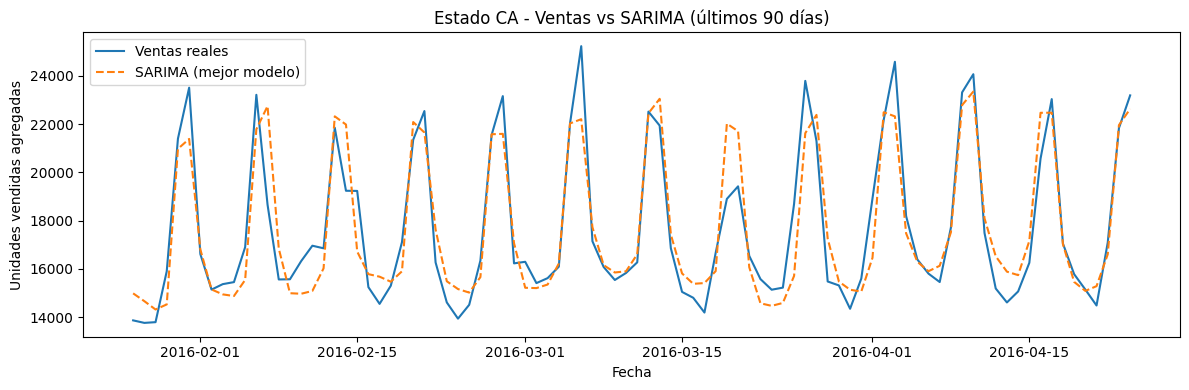

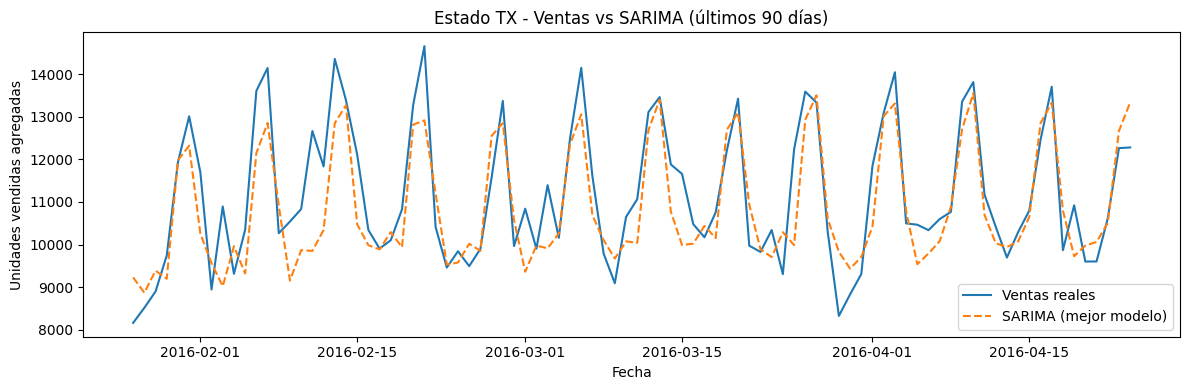

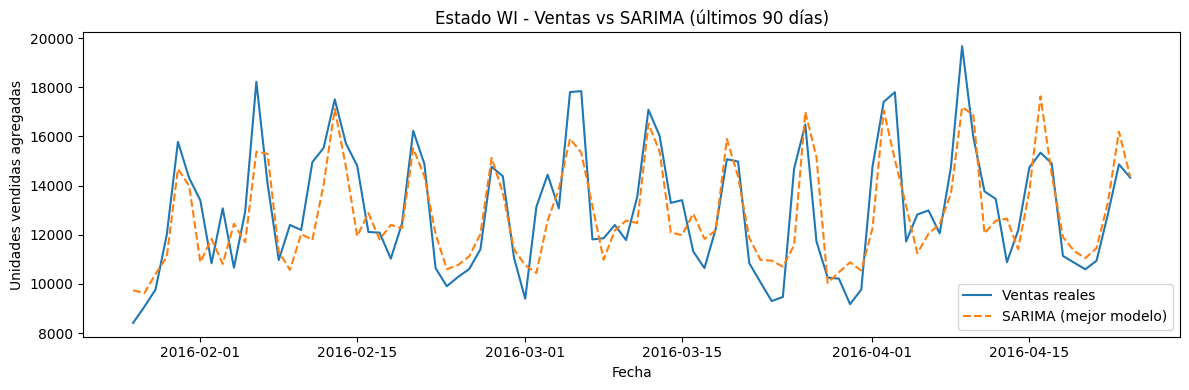

In [192]:
for state in best_by_state['state_id']:
    data_plot = sarima_last90_states[sarima_last90_states['state_id'] == state]

    plt.figure(figsize=(12,4))
    plt.plot(data_plot['date'], data_plot['sales'],
             label='Ventas reales')
    plt.plot(data_plot['date'], data_plot['sarima_pred'],
             label='SARIMA (mejor modelo)', linestyle='--')


    plt.title(f"Estado {state} - Ventas vs SARIMA (últimos 90 días)")
    plt.xlabel("Fecha")
    plt.ylabel("Unidades vendidas agregadas")
    plt.legend()
    plt.tight_layout()
    plt.show()


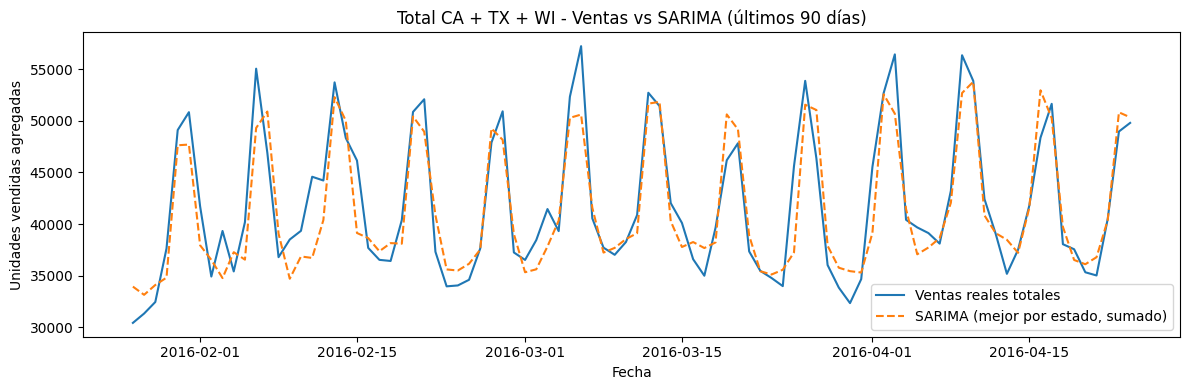

In [203]:
# Agregamos por fecha las ventas y predicciones de los 3 estados
total_last90 = (
    sarima_last90_states
    .groupby('date')[['sales', 'sarima_pred']]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,4))
plt.plot(total_last90['date'], total_last90['sales'],
         label='Ventas reales totales')
plt.plot(total_last90['date'], total_last90['sarima_pred'],
         label='SARIMA (mejor por estado, sumado)', linestyle='--')

plt.title("Total CA + TX + WI - Ventas vs SARIMA (últimos 90 días)")
plt.xlabel("Fecha")
plt.ylabel("Unidades vendidas agregadas")
plt.legend()
plt.tight_layout()
plt.show()


In [198]:
#Resumen de métricas por estado y modelo
metrics_summary = (
    sarima_cv_results
    .groupby(['state_id', 'model'])[['RMSSE', 'RMSE', 'MAE']]
    .agg(['mean', 'std'])
    .reset_index()
)

metrics_summary.columns = [
    '_'.join([c for c in col if c])
    for col in metrics_summary.columns.values
]

print("Métricas (media ± DE) por estado y modelo:")
display(metrics_summary)


Métricas (media ± DE) por estado y modelo:


state_id                    model  RMSSE_mean  RMSSE_std    RMSE_mean  \
0        CA  SARIMA(0,0,0)X(1,1,1,7)    0.606959   0.352305  1913.105914   
1        CA  SARIMA(0,0,0)X(2,1,1,7)    0.585301   0.323798  1844.839750   
2        CA  SARIMA(0,0,0)X(2,1,2,7)    0.584756   0.354483  1843.123128   
3        CA  SARIMA(0,0,1)X(1,1,1,7)    0.604386   0.346183  1904.995581   
4        CA  SARIMA(0,0,1)X(2,1,1,7)    0.584993   0.321258  1843.871194   
5        CA  SARIMA(0,0,1)X(2,1,2,7)    0.580810   0.292326  1830.684452   
6        CA  SARIMA(0,0,2)X(2,1,2,7)    0.580093   0.292708  1828.424519   
7        CA  SARIMA(0,1,1)X(2,0,2,7)    0.542477   0.305499  1709.862086   
8        CA  SARIMA(1,0,0)X(2,0,1,7)    0.601146   0.365465  1894.784089   
9        CA  SARIMA(1,0,0)X(2,0,2,7)    0.562960   0.279147  1774.423616   
10       CA  SARIMA(1,0,2)X(2,0,2,7)    0.557633   0.309628  1757.633918   
11       TX  SARIMA(0,0,0)X(1,1,1,7)    0.615363   0.230157  1182.497442   
12       TX  SARIMA(0,0,0)X(2,1,1,7)    0.622198   0.238017  1195.632532   
13       TX  SARIMA(0,0,0)X(2,1,2,7)    0.648109   0.262966  1245.423579   
14       TX  SARIMA(0,0,1)X(1,1,1,7)    0.615198   0.242856  1182.181511   
15       TX  SARIMA(0,0,1)X(2,1,1,7)    0.623627   0.212455  1198.378050   
16       TX  SARIMA(0,0,1)X(2,1,2,7)    0.635095   0.250705  1220.416032   
17       TX  SARIMA(0,0,2)X(2,1,2,7)    0.644452   0.235351  1238.396540   
18       TX  SARIMA(0,1,1)X(2,0,2,7)    0.573101   0.179668  1101.286141   
19       TX  SARIMA(1,0,0)X(2,0,1,7)    0.496954   0.179540   954.960009   
20       TX  SARIMA(1,0,0)X(2,0,2,7)    0.642272   0.287500  1234.206477   
21       TX  SARIMA(1,0,2)X(2,0,2,7)    0.640330   0.248117  1230.474657   
22       WI  SARIMA(0,0,0)X(1,1,1,7)    0.873339   0.185673  1956.305173   
23       WI  SARIMA(0,0,0)X(2,1,1,7)    0.837162   0.216778  1875.267615   
24       WI  SARIMA(0,0,0)X(2,1,2,7)    0.858987   0.296993  1924.155558   
25       WI  SARIMA(0,0,1)X(1,1,1,7)    0.873266   0.196882  1956.142530   
26       WI  SARIMA(0,0,1)X(2,1,1,7)    0.847985   0.217819  1899.511331   
27       WI  SARIMA(0,0,1)X(2,1,2,7)    0.910480   0.279412  2039.501327   
28       WI  SARIMA(0,0,2)X(2,1,2,7)    0.929475   0.260972  2082.052273   
29       WI  SARIMA(0,1,1)X(2,0,2,7)    0.900046   0.166137  2016.130434   
30       WI  SARIMA(1,0,0)X(2,0,1,7)    0.798036   0.129922  1787.623338   
31       WI  SARIMA(1,0,0)X(2,0,2,7)    0.802814   0.137504  1798.327876   
32       WI  SARIMA(1,0,2)X(2,0,2,7)    0.833994   0.148956  1868.172084   

       RMSE_std     MAE_mean     MAE_std  
0   1110.446968  1497.590360  926.708076  
1   1020.595885  1446.370221  868.403092  
2   1117.311853  1449.006782  926.629131  
3   1091.152463  1499.547225  891.904308  
4   1012.589863  1456.489288  846.275251  
5    921.396076  1455.626888  773.461715  
6    922.602577  1450.661112  786.513968  
7    962.917826  1293.457090  760.710880  
8   1151.927482  1468.155325  953.110258  
9    879.856694  1394.972560  745.860302  
10   975.931162  1384.158183  830.377311  
11   442.275807   969.423765  357.065238  
12   457.379514   976.728040  365.603972  
13   505.323341  1007.039621  402.044924  
14   466.677872   964.076330  379.928514  
15   408.259405   979.372622  303.868435  
16   481.760771   995.229482  383.181910  
17   452.256767  1017.796398  342.698605  
18   345.254197   881.456855  309.203101  
19   345.008064   786.597800  283.877171  
20   552.467521  1003.773343  463.394894  
21   476.788206  1010.950607  399.891652  
22   415.912951  1577.110749  318.858380  
23   485.588132  1471.161694  361.522751  
24   665.272831  1498.377415  467.651212  
25   441.020828  1568.786448  336.587746  
26   487.921712  1492.254926  356.034124  
27   625.891929  1584.377441  446.640747  
28   584.584599  1626.110752  415.267689  
29   372.151892  1646.986111  327.010752  
30   291.029870  1436.130308  212.355810  
31   308.012595  1444.888992  213.770777  

In [204]:
# Nos quedamos solo con las filas que ya tienen RMSSE calculado
metrics_cols = ['RMSSE', 'RMSE', 'MAE']
cv_valid = sarima_cv_results.dropna(subset=metrics_cols)

# Métricas por estado y modelo
metrics_summary = (
    cv_valid
    .groupby(['state_id', 'model'])[metrics_cols]
    .agg(['mean', 'std'])
    .reset_index()
)

metrics_summary.columns = [
    '_'.join(filter(None, c)) for c in metrics_summary.columns.to_flat_index()
]

print("Métricas (media ± DE) por estado y modelo:")
display(metrics_summary)


Métricas (media ± DE) por estado y modelo:


state_id                    model  RMSSE_mean  RMSSE_std    RMSE_mean  \
0        CA  SARIMA(0,0,0)X(1,1,1,7)    0.606959   0.352305  1913.105914   
1        CA  SARIMA(0,0,0)X(2,1,1,7)    0.585301   0.323798  1844.839750   
2        CA  SARIMA(0,0,0)X(2,1,2,7)    0.584756   0.354483  1843.123128   
3        CA  SARIMA(0,0,1)X(1,1,1,7)    0.604386   0.346183  1904.995581   
4        CA  SARIMA(0,0,1)X(2,1,1,7)    0.584993   0.321258  1843.871194   
5        CA  SARIMA(0,0,1)X(2,1,2,7)    0.580810   0.292326  1830.684452   
6        CA  SARIMA(0,0,2)X(2,1,2,7)    0.580093   0.292708  1828.424519   
7        CA  SARIMA(0,1,1)X(2,0,2,7)    0.542477   0.305499  1709.862086   
8        CA  SARIMA(1,0,0)X(2,0,1,7)    0.601146   0.365465  1894.784089   
9        CA  SARIMA(1,0,0)X(2,0,2,7)    0.562960   0.279147  1774.423616   
10       CA  SARIMA(1,0,2)X(2,0,2,7)    0.557633   0.309628  1757.633918   
11       TX  SARIMA(0,0,0)X(1,1,1,7)    0.615363   0.230157  1182.497442   
12       TX  SARIMA(0,0,0)X(2,1,1,7)    0.622198   0.238017  1195.632532   
13       TX  SARIMA(0,0,0)X(2,1,2,7)    0.648109   0.262966  1245.423579   
14       TX  SARIMA(0,0,1)X(1,1,1,7)    0.615198   0.242856  1182.181511   
15       TX  SARIMA(0,0,1)X(2,1,1,7)    0.623627   0.212455  1198.378050   
16       TX  SARIMA(0,0,1)X(2,1,2,7)    0.635095   0.250705  1220.416032   
17       TX  SARIMA(0,0,2)X(2,1,2,7)    0.644452   0.235351  1238.396540   
18       TX  SARIMA(0,1,1)X(2,0,2,7)    0.573101   0.179668  1101.286141   
19       TX  SARIMA(1,0,0)X(2,0,1,7)    0.496954   0.179540   954.960009   
20       TX  SARIMA(1,0,0)X(2,0,2,7)    0.642272   0.287500  1234.206477   
21       TX  SARIMA(1,0,2)X(2,0,2,7)    0.640330   0.248117  1230.474657   
22       WI  SARIMA(0,0,0)X(1,1,1,7)    0.873339   0.185673  1956.305173   
23       WI  SARIMA(0,0,0)X(2,1,1,7)    0.837162   0.216778  1875.267615   
24       WI  SARIMA(0,0,0)X(2,1,2,7)    0.858987   0.296993  1924.155558   
25       WI  SARIMA(0,0,1)X(1,1,1,7)    0.873266   0.196882  1956.142530   
26       WI  SARIMA(0,0,1)X(2,1,1,7)    0.847985   0.217819  1899.511331   
27       WI  SARIMA(0,0,1)X(2,1,2,7)    0.910480   0.279412  2039.501327   
28       WI  SARIMA(0,0,2)X(2,1,2,7)    0.929475   0.260972  2082.052273   
29       WI  SARIMA(0,1,1)X(2,0,2,7)    0.900046   0.166137  2016.130434   
30       WI  SARIMA(1,0,0)X(2,0,1,7)    0.798036   0.129922  1787.623338   
31       WI  SARIMA(1,0,0)X(2,0,2,7)    0.802814   0.137504  1798.327876   
32       WI  SARIMA(1,0,2)X(2,0,2,7)    0.833994   0.148956  1868.172084   

       RMSE_std     MAE_mean     MAE_std  
0   1110.446968  1497.590360  926.708076  
1   1020.595885  1446.370221  868.403092  
2   1117.311853  1449.006782  926.629131  
3   1091.152463  1499.547225  891.904308  
4   1012.589863  1456.489288  846.275251  
5    921.396076  1455.626888  773.461715  
6    922.602577  1450.661112  786.513968  
7    962.917826  1293.457090  760.710880  
8   1151.927482  1468.155325  953.110258  
9    879.856694  1394.972560  745.860302  
10   975.931162  1384.158183  830.377311  
11   442.275807   969.423765  357.065238  
12   457.379514   976.728040  365.603972  
13   505.323341  1007.039621  402.044924  
14   466.677872   964.076330  379.928514  
15   408.259405   979.372622  303.868435  
16   481.760771   995.229482  383.181910  
17   452.256767  1017.796398  342.698605  
18   345.254197   881.456855  309.203101  
19   345.008064   786.597800  283.877171  
20   552.467521  1003.773343  463.394894  
21   476.788206  1010.950607  399.891652  
22   415.912951  1577.110749  318.858380  
23   485.588132  1471.161694  361.522751  
24   665.272831  1498.377415  467.651212  
25   441.020828  1568.786448  336.587746  
26   487.921712  1492.254926  356.034124  
27   625.891929  1584.377441  446.640747  
28   584.584599  1626.110752  415.267689  
29   372.151892  1646.986111  327.010752  
30   291.029870  1436.130308  212.355810  
31   308.012595  1444.888992  213.770777  

Comparamos SNaive vs Sarima

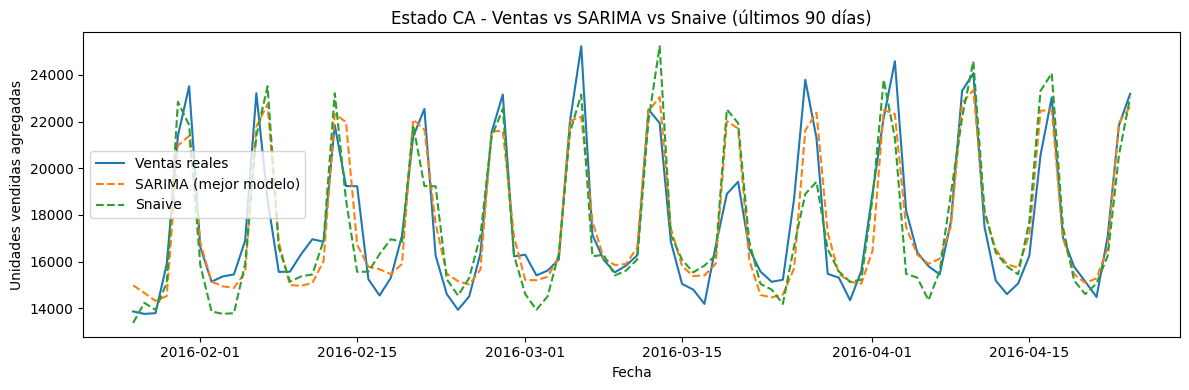

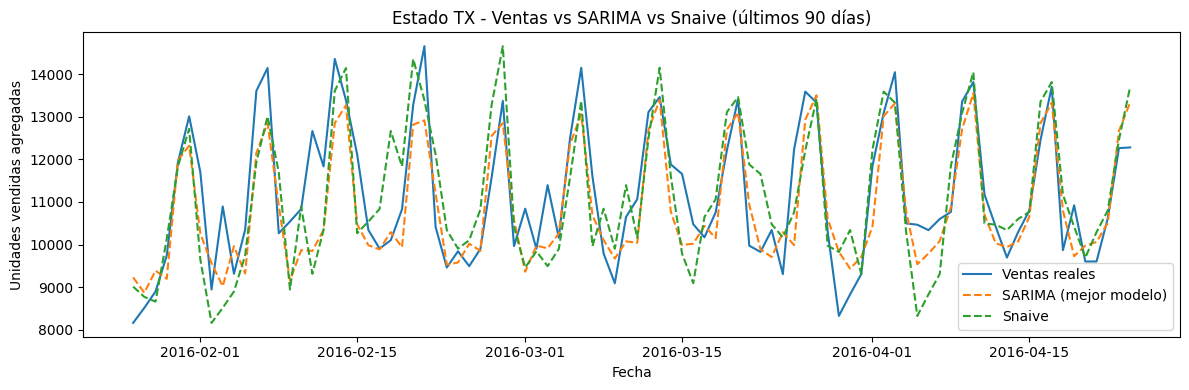

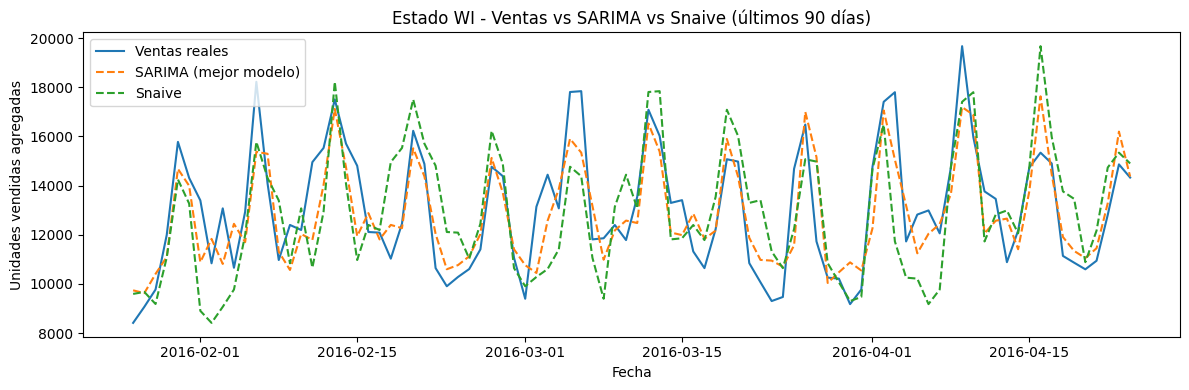

In [219]:
for state in best_by_state['state_id']:
    data_plot = sarima_last90_states[sarima_last90_states['state_id'] == state]

    plt.figure(figsize=(12,4))
    plt.plot(data_plot['date'], data_plot['sales'],
             label='Ventas reales')
    plt.plot(data_plot['date'], data_plot['sarima_pred'],
             label='SARIMA (mejor modelo)', linestyle='--')
    plt.plot(data_plot['date'], data_plot['snaive_7'],
             label='Snaive', linestyle='--')


    plt.title(f"Estado {state} - Ventas vs SARIMA vs Snaive (últimos 90 días)")
    plt.xlabel("Fecha")
    plt.ylabel("Unidades vendidas agregadas")
    plt.legend()
    plt.tight_layout()
    plt.show()


# **8. Interpretabilidad y análisis de error**

* Importancias (gain/perm) y **SHAP**/**Partial Dependence** en 1–2 modelos top.
* **≥ 2 insights accionables** (sensibilidad a precio, efecto calendario/feriados).


=== Estado CA | Modelo SARIMA(0,1,1)X(2,0,2,7) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


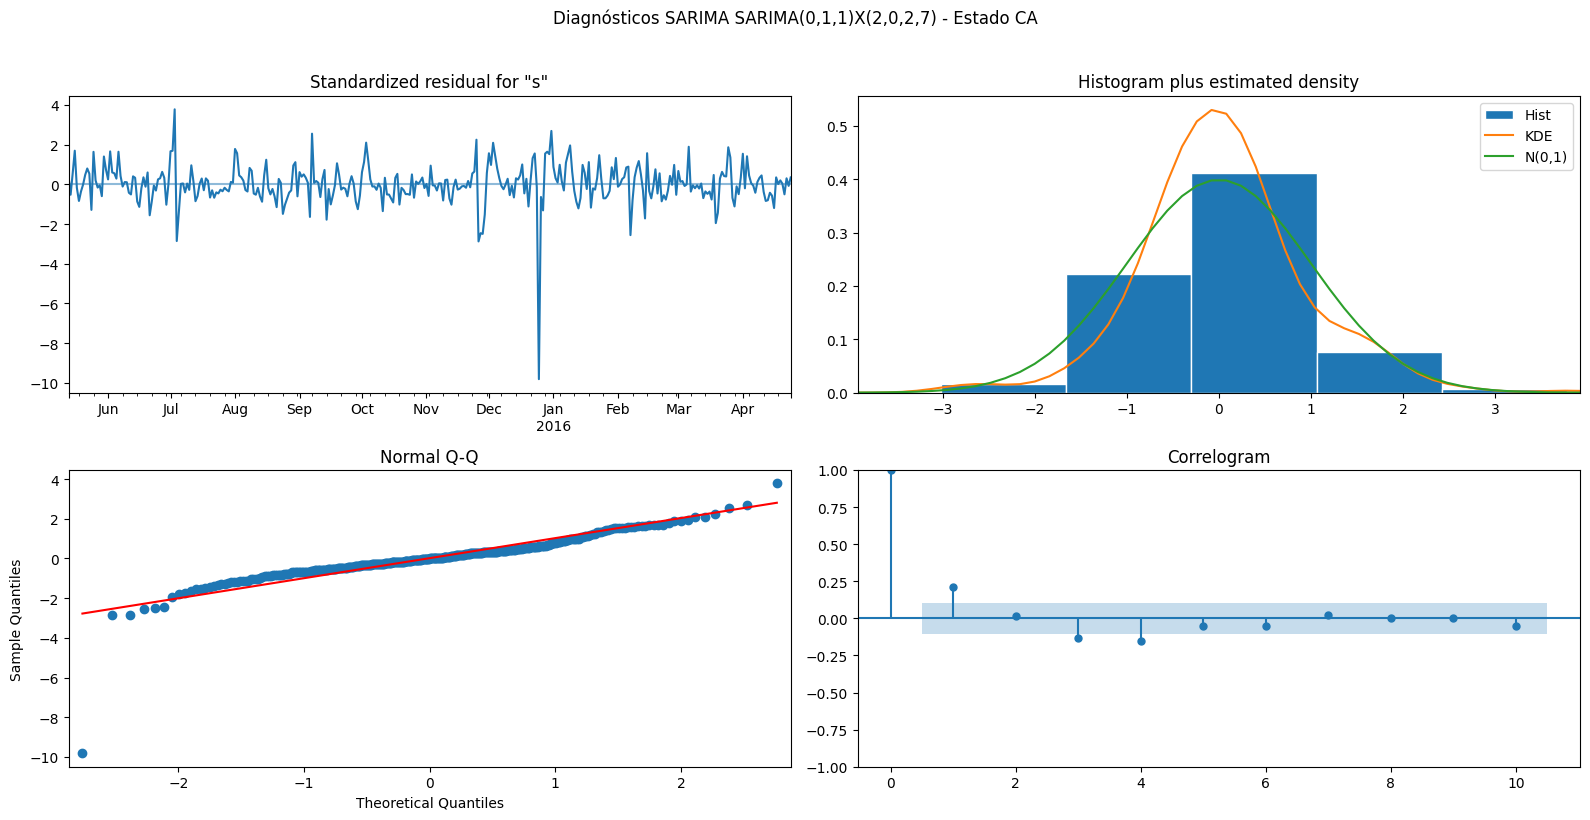


=== Estado TX | Modelo SARIMA(1,0,0)X(2,0,1,7) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


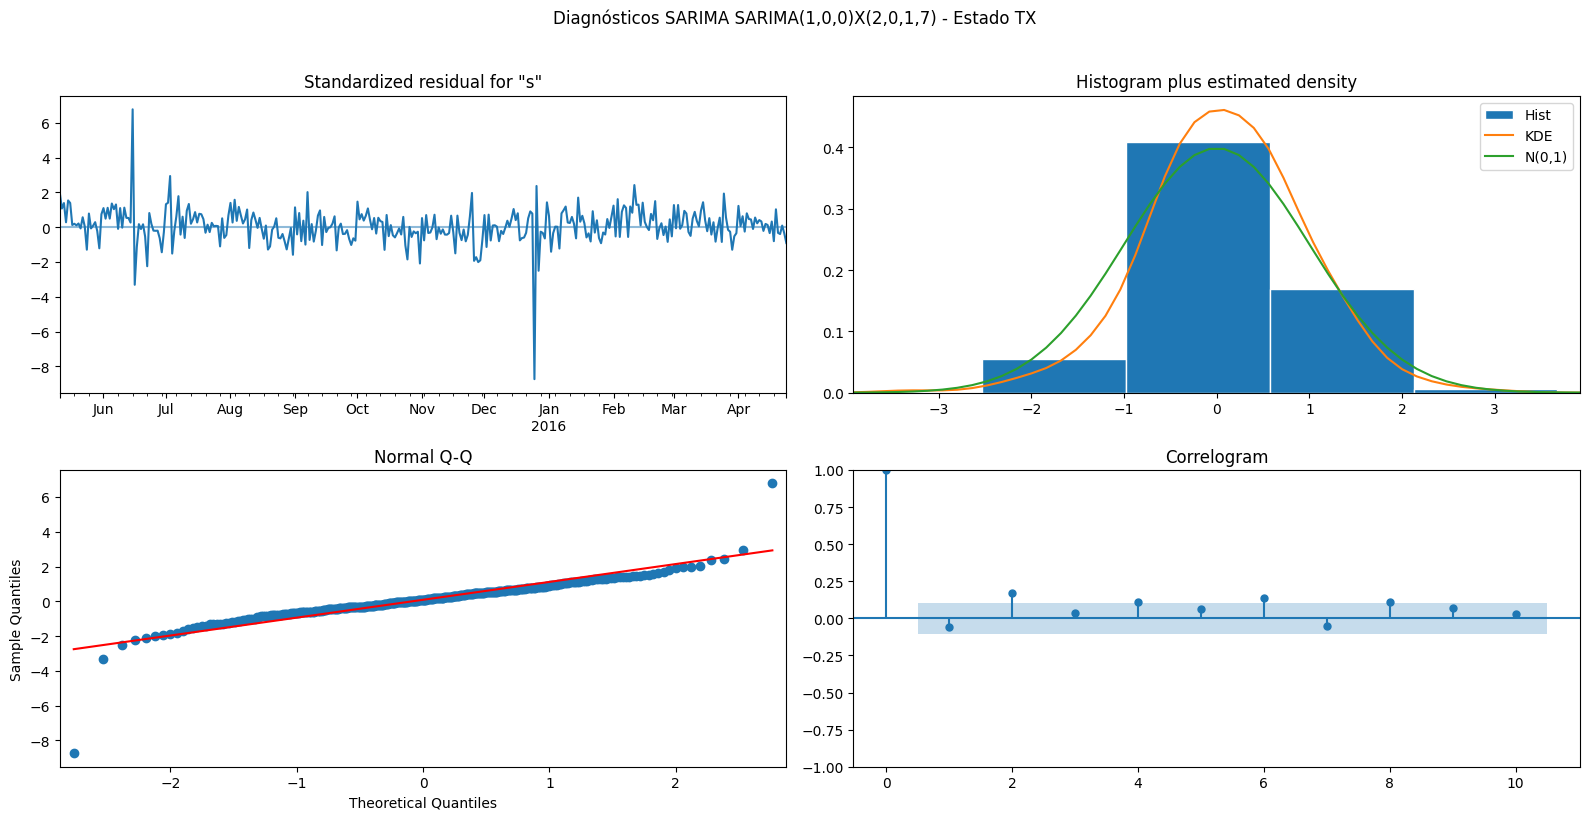


=== Estado WI | Modelo SARIMA(1,0,0)X(2,0,1,7) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


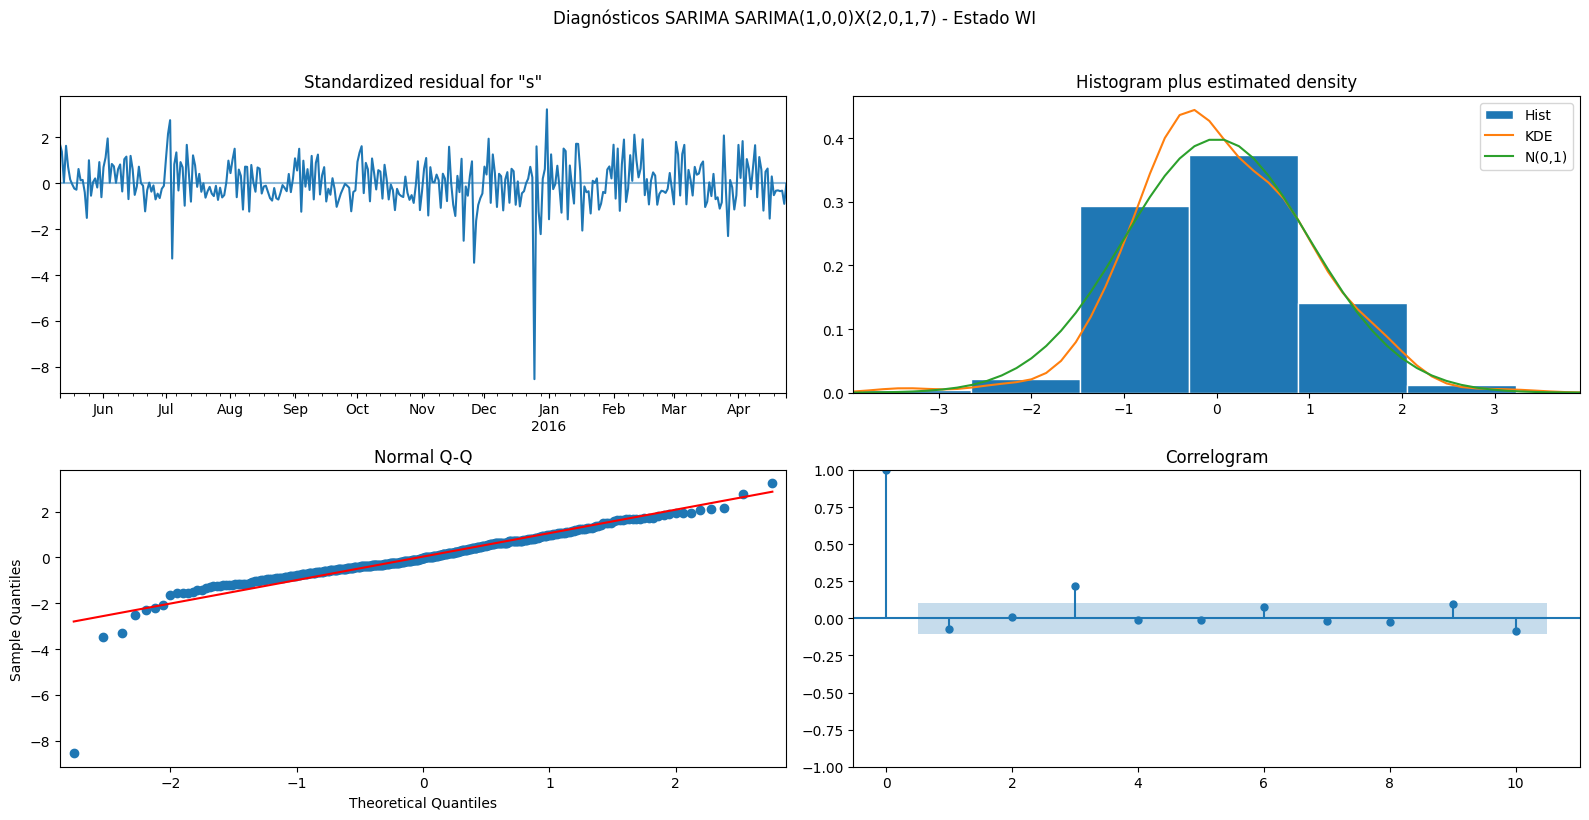

state_id       date         resid  resid_std
0       CA 2015-04-26  19426.000000   9.615685
1       CA 2015-04-27  -4653.000000  -2.308703
2       CA 2015-04-28  -4485.283896  -2.225647
3       CA 2015-04-29  -2870.493285  -1.425971
4       CA 2015-04-30   -964.900398  -0.482285

In [194]:
residuals_list = []

for _, row in best_by_state.iterrows():
    state      = row['state_id']
    model_name = row['model']

    print(f"\n=== Estado {state} | Modelo {model_name} ===")

    order, seasonal_order = parse_sarima_name(model_name)

    # Serie diaria agregada del estado
    df_state = (
        state_daily[state_daily['state_id'] == state]
        .sort_values('date')
        .copy()
    )
    df_state = df_state.set_index('date')
    y = df_state['sales'].astype(float)

    # Ajustar SARIMA con los parámetros elegidos
    sarima = SARIMAX(
        y,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    model_fit = sarima.fit(disp=False)

    # Gráficos de diagnóstico
    fig = model_fit.plot_diagnostics(figsize=(16, 8))
    fig.suptitle(f"Diagnósticos SARIMA {model_name} - Estado {state}", y=1.02)
    plt.tight_layout()
    plt.show()

    # Guardar residuos
    resid_raw = model_fit.resid
    resid_std = (resid_raw - resid_raw.mean()) / resid_raw.std()

    df_resid = pd.DataFrame({
        'state_id'      : state,
        'date'          : resid_raw.index,
        'resid'         : resid_raw.values,
        'resid_std'     : resid_std.values
    })

    residuals_list.append(df_resid)

# DataFrame final con residuos de los 3 estados
sarima_residuals = pd.concat(residuals_list, ignore_index=True)
display(sarima_residuals.head())

Errores en dias de la semana por estado

In [195]:
resid_merged = sarima_residuals.merge(calendar[['date','wday']], on='date', how='left')

error_weekday = (
    resid_merged
    .groupby(['state_id','wday'])['resid']
    .agg(['mean','std'])
    .reset_index()
)
display(error_weekday)

state_id  wday        mean          std
0        CA     1  568.409558  1681.771453
1        CA     2  120.020845  3325.190446
2        CA     3 -388.277323  1532.111964
3        CA     4 -170.281811  1287.586348
4        CA     5  -60.218887  1156.708788
5        CA     6  -15.965018  1332.130643
6        CA     7    7.041088  2711.443780
7        TX     1  405.678250  1823.754132
8        TX     2  162.643333  2076.841881
9        TX     3  233.680570  1847.097724
10       TX     4  364.073712  1396.189995
11       TX     5  271.900555  1332.474287
12       TX     6  331.882970  1395.205474
13       TX     7  329.489335  2225.393023
14       WI     1  568.291370  2011.265477
15       WI     2 -231.822305  2378.799165
16       WI     3   62.773062  1447.061872
17       WI     4  211.836325  1266.969890
18       WI     5  206.205710  1361.558529
19       WI     6  281.995956  1773.021836
20       WI     7  258.674931  2563.501703

Error en dias con y sin Eventos

In [196]:
resid_evt = (
    sarima_residuals
    .merge(calendar[['date','event_name_1']], on='date', how='left')
)
resid_evt['has_event'] = (resid_evt['event_name_1'].notna()).astype(int)

error_event = (
    resid_evt
    .groupby(['state_id','has_event'])['resid']
    .agg(['mean','std'])
    .reset_index()
)
display(error_event)


state_id  has_event         mean          std
0       CA          0   101.072745  1772.055516
1       CA          1 -1099.414818  3809.775966
2       TX          0   359.369292  1659.213657
3       TX          1  -420.666945  2517.803612
4       WI          0   307.940320  1674.653531
5       WI          1 -1192.644552  3317.495231

# **9. Conclusiones técnicas**

* **Modelo recomendado** + justificación: métrica principal, estabilidad, costo/tiempo.
* **Limitaciones** y **próximos pasos** (nuevas *features*, segmentación, mejor *tuning*).

In [231]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compute_rmsse(y_true, y_pred, y_train):
    """
    Calcula RMSSE usando la serie de entrenamiento y_train.
    Devuelve NaN si:
      - y_train tiene menos de 2 puntos tras limpiar NaN, o
      - la varianza de las diferencias es 0 (serie prácticamente constante).
    """
    y_train = np.asarray(y_train, dtype=float)
    y_train = y_train[~np.isnan(y_train)]

    if len(y_train) < 2:
        return np.nan

    diff = np.diff(y_train)
    denom = np.mean(diff ** 2)

    if denom <= 0 or np.isnan(denom):
        return np.nan

    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse / denom)


# Últimos 28 días por estado
eval_28 = (
    sarima_last90_states
    .sort_values(['state_id', 'date'])
    .groupby('state_id')
    .tail(28)
    .copy()
)

rows = []

for state, g in eval_28.groupby('state_id'):
    g = g.sort_values('date')

    y_true   = g['sales'].values
    y_snaive = g['snaive_7'].values
    y_sarima = g['sarima_pred'].values

    # tramo de entrenamiento hasta el día anterior al primer día de evaluación
    eval_start = g['date'].min()
    train_end  = eval_start - pd.Timedelta(days=1)

    y_train = (
        state_daily
        .query("state_id == @state and date <= @train_end")
        .sort_values('date')['sales']
        .values
    )

    # --- SNaive ---
    mse_snaive   = mean_squared_error(y_true, y_snaive)
    rmse_snaive  = np.sqrt(mse_snaive)
    mae_snaive   = mean_absolute_error(y_true, y_snaive)
    rmsse_snaive = compute_rmsse(y_true, y_snaive, y_train)

    # --- SARIMA ---
    mse_sarima   = mean_squared_error(y_true, y_sarima)
    rmse_sarima  = np.sqrt(mse_sarima)
    mae_sarima   = mean_absolute_error(y_true, y_sarima)
    rmsse_sarima = compute_rmsse(y_true, y_sarima, y_train)

    rows.append({
        'state_id':       state,
        'RMSSE_snaive':   rmsse_snaive,
        'RMSSE_sarima':   rmsse_sarima,
        'RMSE_snaive':    rmse_snaive,
        'RMSE_sarima':    rmse_sarima,
        'MAE_snaive':     mae_snaive,
        'MAE_sarima':     mae_sarima,
    })

metrics_28_states = pd.DataFrame(rows)

# % mejora de SARIMA sobre SNaive en RMSSE
metrics_28_states['improvement_RMSSE_%'] = (
    100 * (metrics_28_states['RMSSE_snaive'] - metrics_28_states['RMSSE_sarima'])
        / metrics_28_states['RMSSE_snaive']
)

display(metrics_28_states)


state_id  RMSSE_snaive  RMSSE_sarima  RMSE_snaive  RMSE_sarima   MAE_snaive  \
0       CA      0.410931      0.314727  1293.034222   990.317708  1035.428571   
1       TX      0.454372      0.340393   882.505888   661.128869   671.142857   
2       WI      0.944386      0.590612  2101.617617  1314.337283  1518.892857   

    MAE_sarima  improvement_RMSSE_%  
0   748.363707            23.411330  
1   541.266168            25.085047  
2  1080.545640            37.460684

El modelo recomendado para el pronóstico de demanda diaria es una familia de modelos SARIMA por estado, con estacionalidad semanal (7 días) y una diferencia para capturar la tendencia. En particular, el mejor desempeño lo entregan los modelos:

Estado CA: SARIMA(0,1,1)×(2,0,2,7)

Estado TX: SARIMA(1,0,0)×(2,0,1,7)

Estado WI: SARIMA(1,0,0)×(2,0,1,7).

La elección se basa en la métrica principal RMSSE, donde los modelos SARIMA mejoran de forma consistente al baseline SNaive s=7 en los tres estados. Además, en la validación con walk-forward los resultados se mantienen estables entre distintos splits de tiempo, lo que indica que el modelo generaliza bien y no está sobreajustado a un periodo específico.

SARIMA también tiene la ventaja de ser un modelo relativamente simple e interpretable, basado solo en el historial de ventas y con un costo computacional moderado. Comparado con los intentos de modelos más complejos (XGBoost y redes neuronales) que no lograron superar al baseline de forma robusta, SARIMA ofrece una mejor relación entre desempeño, tiempo de entrenamiento y complejidad.

A pesar de su buen desempeño, la solución presenta varias limitaciones:

* El modelo SARIMA usa solo la serie de ventas agregada por estado; no aprovecha completamente la información a nivel de tienda ni de producto, ni asegura coherencia jerárquica entre niveles (item–tienda–estado).

* No se incorporan de manera explícita factores externos como precios, promociones o feriados especiales; estos efectos se capturan solo de forma implícita a través de la estacionalidad semanal.

* El espacio de parámetros SARIMA explorado fue acotado, por restricciones de tiempo y cómputo; es posible que exista una combinación de órdenes mejor.

Como próximos pasos, se proponen las siguientes líneas de trabajo:

* Extender el modelo a un esquema SARIMAX, incorporando como regresores externos el precio, indicadores de promociones y variables de calendario (feriados, eventos locales).

* Explorar una modelación jerárquica o reconciliación top-down/bottom-up para mantener coherencia entre las predicciones por producto, tienda y estado.

* Re-evaluar modelos globales como XGBoost u otras técnicas de gradient boosting usando la misma estrategia de walk-forward y un tuning más sistemático, para comparar contra SARIMA en igualdad de condiciones.

* Incluir el cálculo de intervalos de confianza para los pronósticos, de manera de apoyar mejor la toma de decisiones en inventario y planificación.